Developed by: Fritz.Kalwa@tu-dresden.de / Thomas.Reimann@tu-dresden.de

<br>Last change: 2020 11 18

<br>Current state: funktional und nett

<br>ToDo:


<center>
    
### BWA11 - Mess- und Erkundungstechnik
### Thema: Pumpversuchsauswertung
# Diagnostische Plots  </center>
_Mit diesem Notebook soll Ihnen die Pumpversuchsauswertung mithilfe von Diagnostischen Plots nähergebracht werden. Zum Schluss sollten Sie vor allem..._
- ...den Zusammenhang zwischen dem Theis'schen Ansatz und den diagnostischen Plots erklären können.
- ...die Vorgehensweise zur Erstellung eines diagnostischen Plots zusammenfassen können.
- ...hydraulische Eigenschaften (*T* und *S*) an einem vorgegebenen diagnostischen Plot bestimmen können (iterativ __und__ rechnerisch).
- ...Abweichungen der klassischen Theis'schen Grundvoraussetzungen anhand der vorgegebenen diagnostischen Plots klassifizieren können.

In [36]:
# Notwendige Funktionen / Bibliotheken einladen
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import os
import math
from ipywidgets import *
import matplotlib.ticker as ticker

# 1. Hintergrund
Der Ansatz nach Theis (1935) erlaubt eine systematische Auswertung instationärer Verhältnisse. Allerdings ist die von ihm entwickelte Brunnenfunktion *W(u)* nicht analytisch lösbar und ihre Abhängigkeit von *1/u* ist nur über Tabellen erschließbar. Durch Cooper-Jacob (1946) wurde dieses Problem mithilfe einer Vereinfachung gelöst, allerdings war auch diese Methode meist auf hydraulische Grundvoraussetzungen nach Theis beschränkt. Laut diesen muss ein Aquifer folgende Eigenschaften besitzen

- homogener und isotroper Aufbau
- ausschließlich horizontale Strömungsprozesse
- (annähernd) infinite Ausbildung
- keine Quellen, keine Senken im Einflussbereich des Brunnens
- höchstens triviale Randbedingungen
- kaum Anwendbarkeit für den Brunnennahbereich

Deshalb war auch mit dieser Methode keine systematische Auswertung komplexerer hydrogeologischer Situationen möglich. Mit der Entwicklung der diagnostischen Plots durch Bourdet et al. (1983) wurde die Untersuchung um folgende Faktoren erweitert:

- (Großskalige) Heterogenitäten innerhalb eines Aquifers
- komplexere hydraulische Randbedingungen
- Quellen und Senken innerhalb des Absenkungsbereiches
- "Leaky" Aquifere



# 2. Grundlagen
Ausgangspunkt ist Brunnenfunktion der Theis-Gleichung:

<br>
<center>$\large W(u) = \int_{u }^{+\infty} \frac{e^{-u}}{u}du = -0,5772 - ln(u) + u - \frac{u^2}{2*2!} + \frac{u^3}{3*3!} - \frac{u^4}{4*4!}+...$</center>
<br>

mit der dimensionslosen Hilfsvariable *u*:

<br>
<center>$\large u = \frac{Sr^2}{4Tt} $</center>
<br>

Hier repräsentiert *S* den Speicherkoeffizienten, *r* den Abstand des Beobachtungspunktes zum Pumpbrunnen, *T* die Transmissivität und *t* die Zeit nach Pumpbeginn.
All dies wird benötigt, um die Absenkung *s* für die Pumprate *Q* zu berechnen:

<br>
<center>$\large s(r,t)=\frac{Q}{4\pi T}W(u) $</center>
<br>

Das Hauptproblem für die analytische Lösung stellt hierbei die unendliche Reihe in der Brunnenfunktion dar, die von Cooper-Jacob (1946) aufgrund ihrer Tendenz, bei längeren Pumpzeiten gegen *0* zu laufen, vernachlässigt wurde. Dies war mit den damaligen Werkzeugen (Stift und Papier) den einzigen gangbaren Weg darstellte. Der größte Unterschied nun zwischen diesen "alten" Methoden und den diagnostischen Plots besteht darin, dass nicht die Absenkung "selbst" betrachtet wird, sondern die Änderungsrate der Absenkung. Zu diesem Zweck wurde von Bourdet et al. (1983) die sogenannte "Bourdet-Ableitung" entwickelt. Hierbei wird zunächst die Ableitung der Brunnenfunktion betrachtet:

<br>
<center>$\large \frac{\partial }{\partial u} W(u) = \frac{e^{-u}}{u}$</center>
<br>

Die Ableitung der Absenkung lässt sich folgendermaßen beschreiben:

<br>
<center>$\large \frac{\partial} {\partial t} s(r,t) = \frac{Q}{4 \pi T}\frac{\partial} {\partial u} W(u) \frac{\partial} {\partial t} u$</center>
<br>

Das wirkt auf den ersten Blick etwas einschüchternd, lässt sich aber durch Einsetzen der Ableitung der Brunnenfunktion und der Ableitung von *u* vereinfachen zu:

<br>
<center>$\large \frac{\partial} {\partial t} s(r,t) = \frac{Q}{4 \pi T} \frac{e^{-u}}{u} \frac{{u}} {t} = \frac{Q}{4 \pi T} \frac{e^{-u}}{t} $</center>
<br>

Das "störende" *t* auf der rechten Seite der Gleichung wurde von Bourdet (1983) dadurch eliminiert, dass die Ableitung nicht nach *t*, sondern nach *ln(t)* gebildet wird. Dies führt zu folgender Gleichung:

<br>
<center>$\large \frac{\partial} {\partial ln(t)} s(r,t) = \frac{\partial} {\partial t} s(r,t) \cdot t = \frac{Q}{4 \pi T} \frac{e^{-u}}{u} \frac{{u}} {t} = \frac{Q}{4 \pi T} \frac{e^{-u}}{t} \cdot t = \frac{Q}{4 \pi T} e^{-u} =  \frac{Q}{4 \pi T} e^{-(\frac{Sr^2}{4Tt})} $</center>
<br>

Dadurch, dass sich diese Gleichung verhältnismäßig einfach analytisch lösen lässt, kann eine Fit-Funktion für die Parameter *T* und *S* entwickelt werden, wenn nicht die Ableitung, sondern der Gradient der gemessenen Absenkungswerte betrachtet wird.

In [37]:
#Plot Function
def splot(T, S, r, Q):
    tmax = 1000000
    r_max = 1000000
    s = [0 for x in range(r_max)]
    t = [1 for x in range(r_max)]
    
    for x in range(1,tmax,1):
        if x>1:
            s[x] = Q/(4*math.pi*T)*math.exp(-(S*r**2)/(4*T*x))
            t[x] = x
    #PLOT
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, s, 'green')
    3
    plt.yscale("log")
    plt.xscale("log")
    plt.axis([1,1E6,1E-3,1E+3])
    ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot')
    plt.title('Der diagnostische Plot',fontweight='bold', fontsize=16)
    ax.grid(which="both", color='grey',linewidth=0.5)
    plt.show()
    print(s[0])
    
# Computation
interact(splot,
         r = widgets.FloatSlider(value=100, min=1, max=1000, step=10, description='r [m]:', continuous_update=False, disabled=False),
         Q = widgets.FloatLogSlider(value=0.001, base=10, min=-4, max=-1, step=0.001, description='Q [m³/s]:', continuous_update=False, readout_format='.2e'),
         T = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=2, step=0.1,readout=True,description='T [m²/s]:', continuous_update=False,readout_format='.1e'),
         S = widgets.FloatLogSlider(value=0.00001,base=10,min=-6, max=0, step=0.1,readout=True,description='S [ - ]:', continuous_update=False,readout_format='.1e'))

interactive(children=(FloatLogSlider(value=0.0001, continuous_update=False, description='T [m²/s]:', max=2.0, …

<function __main__.splot(T, S, r, Q)>

<em> <font color=blue>Aufgabe 1: Verschieben Sie die Regler für die vier Parameter und notieren Sie sich den Einfluss, den diese auf die Typkurve haben. Was sind Gemeinsamkeiten, was sind Unterschiede, die sie zur Theis-Kurve ausmachen können, sowohl in der Kurvenform, als im Verhalten bei Veränderung der Parameter?
</font></em>  \
<br>

# 3. Abgleich mit gemessenen Werten

Dafür greifen wir wieder auf die gleichen Messwerte wie in den andere Arbeitsblättern zurück:

In [38]:
#DATA FROM SCHWARTZ & ZHANG (2003)
#Q = 500 m3/d, r = 300 m
# time in minutes:
m_time = [1,1.27,1.61,2.04,2.59,3.29,4.18,5.3,6.72,8.53,10.83,13.74,17.43,22.12,28.07,35.62,45.2,57.36,72.79,92.37,117.21,148.74,188.74,239.5,303.92,385.66,489.39,621.02,788.05,1000]
# drawdown in meters:
ddown = [0.03,0.05,0.09,0.15,0.22,0.31,0.41,0.53,0.66,0.8,0.95,1.11,1.27,1.44,1.61,1.79,1.97,2.15,2.33,2.52,2.7,2.89,3.07,3.26,3.45,3.64,3.83,4.02,4.21,4.39]


# DATA VARNUM (2016) (Q = 1138 m3/day)

#R4 => r = 90 m
#m_time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325] # time in minutes
#m_ddown = [2E-05,0.0303,0.05141,0.0661,0.07509,0.08408,0.09307,0.10115,0.10556,0.10997,0.11162,0.11878,0.12319,0.12577,0.13002,0.13245,0.13396,0.13822,0.14064,0.14307,0.14457,0.147,0.14851,0.14818,0.15108,0.15307,0.15322,0.15612,0.15902,0.161,0.16115,0.16313,0.16328,0.16343,0.16618,0.16618,0.16618,0.16893,0.16893,0.17077,0.17352,0.17077,0.17352,0.17352,0.17614,0.17602,0.17589,0.1776,0.17564,0.17552,0.17722,0.17527,0.17514,0.17685,0.1768,0.1795,0.17945,0.1794,0.18118,0.18113,0.18108,0.18103,0.18098,0.1791,0.17897,0.18068,0.18056,0.18227,0.18214,0.18202,0.18189,0.18177,0.17981,0.18152,0.18179,0.18207,0.18509,0.18262,0.18564,0.18592,0.18344,0.18647,0.18399,0.18427,0.18773,0.18662,0.18733,0.18622,0.18602,0.18673,0.18837,0.18633,0.18613,0.18777,0.18779,0.18782,0.18784,0.18787,0.18789,0.18792,0.18794,0.18797,0.18799,0.18802,0.19092,0.19107,0.19122,0.19137,0.19152,0.19167,0.19182,0.19197,0.19395,0.19227,0.19244,0.19262,0.19279,0.19297,0.19314,0.19332,0.19349,0.19367,0.19384,0.19402,0.19552,0.1952,0.19304,0.19455,0.19422,0.19207,0.19357,0.19325,0.19109,0.1926,0.19257,0.19255,0.19252,0.1925,0.19247,0.19245,0.19242,0.1924,0.19237,0.19235,0.19252,0.1927,0.19562,0.19305,0.19322,0.1934,0.19632,0.1965,0.19392,0.19685,0.19405,0.194,0.19395,0.19665,0.1966,0.19655,0.1965,0.19828,0.1964,0.19635,0.19635,0.19635,0.19818,0.19818,0.19635,0.19818,0.19635,0.19818,0.19818,0.19635,0.19801,0.19783,0.19766,0.19748,0.19731,0.19713,0.19971,0.19953,0.19936,0.19827,0.19661,0.19862,0.19879,0.19897,0.19731,0.19932,0.20041,0.19783,0.19801,0.20002,0.20063,0.19942,0.20003,0.19973,0.19668,0.20188,0.19792,0.19853,0.19823,0.19702,0.19793,0.19793,0.19977,0.19702,0.19793,0.19793,0.19702,0.19518,0.19793,0.19977,0.19808,0.20007,0.19747,0.20037,0.20052,0.19792,0.19898,0.19913,0.19928,0.19943,0.19938,0.19842,0.19837,0.19923,0.19827,0.19913,0.20183,0.19812,0.19898,0.19893,0.19804,0.19807,0.19901,0.19628,0.20181,0.19817,0.20094,0.20097,0.20191,0.20193,0.19953,0.19988,0.19932,0.20242,0.20002,0.20312,0.20072,0.20198,0.20417,0.20543,0.20142,0.20198,0.20347,0.20312,0.20002,0.20242,0.19932,0.19897,0.20137,0.20193,0.20122,0.19867,0.19887,0.19907,0.20293,0.20222,0.19967,0.20262,0.20007,0.20027,0.20376,0.20358,0.20249,0.20232,0.19939,0.20197,0.20179,0.20162,0.20144,0.20402,0.20233,0.20248,0.20263,0.20187,0.20293,0.20033,0.20232,0.20247,0.20262,0.20277,0.20294,0.20312,0.20329,0.20347,0.20364,0.20473,0.20399,0.20417,0.20434,0.20452,0.20159,0.20417,0.20399,0.20382,0.20364,0.2053,0.20512,0.20312,0.20477,0.20277,0.20477,0.20312,0.20329,0.20347,0.20547,0.20382,0.20399,0.20417,0.20617,0.20452,0.20417] # drawdown in meters

#R12 => r = 40 m
#m_time =  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325] # time in minutes
#m_ddown = [2E-05,0.02022,0.04591,0.0716,0.09342,0.11433,0.12882,0.14332,0.15139,0.16313,0.17396,0.18203,0.18827,0.1936,0.19878,0.2012,0.20729,0.21247,0.21489,0.22007,0.22249,0.22583,0.22826,0.23068,0.23358,0.23648,0.23938,0.24228,0.24243,0.24533,0.24915,0.2493,0.2522,0.25235,0.2551,0.2551,0.25785,0.25785,0.2606,0.2606,0.26335,0.26335,0.2661,0.2661,0.26597,0.26585,0.26847,0.2656,0.26822,0.27177,0.26797,0.27152,0.27139,0.27402,0.27397,0.27392,0.27387,0.27382,0.27652,0.27647,0.27642,0.27637,0.27907,0.27627,0.27614,0.27877,0.27589,0.27577,0.27839,0.27735,0.27814,0.2771,0.28064,0.2796,0.27712,0.2774,0.28042,0.27795,0.27822,0.2785,0.28152,0.27905,0.28207,0.28235,0.28307,0.28012,0.28175,0.2843,0.2841,0.28482,0.28462,0.28442,0.28422,0.28402,0.28404,0.28407,0.28684,0.28412,0.28689,0.28692,0.28694,0.28422,0.28699,0.28702,0.28717,0.28732,0.28747,0.28762,0.28777,0.28792,0.28807,0.28822,0.28837,0.28852,0.29144,0.28887,0.29179,0.28922,0.28939,0.28957,0.28974,0.28992,0.29009,0.29027,0.28994,0.29237,0.28929,0.29172,0.29139,0.29107,0.29074,0.29042,0.29009,0.28977,0.28974,0.28972,0.28969,0.29333,0.28964,0.28687,0.28959,0.29323,0.28954,0.28952,0.29336,0.29353,0.29371,0.29022,0.29406,0.29423,0.29441,0.29458,0.29109,0.29493,0.29488,0.29483,0.29478,0.29473,0.29468,0.29463,0.29458,0.29453,0.29723,0.29718,0.29443,0.29443,0.29443,0.29443,0.29443,0.29718,0.29443,0.29443,0.29443,0.29718,0.29701,0.29683,0.29666,0.29648,0.29631,0.29613,0.29596,0.29578,0.29561,0.29543,0.29561,0.29853,0.29596,0.29613,0.29631,0.29648,0.29666,0.29683,0.29701,0.29993,0.29688,0.29658,0.29628,0.29598,0.29568,0.29538,0.29508,0.29478,0.29723,0.29693,0.29418,0.29418,0.29418,0.29418,0.29693,0.29693,0.29418,0.29418,0.29693,0.29418,0.29433,0.29723,0.29738,0.29478,0.29768,0.29783,0.29798,0.29813,0.29828,0.29843,0.29838,0.29833,0.29828,0.29823,0.29818,0.29813,0.29808,0.29803,0.29798,0.29793,0.29796,0.29798,0.29801,0.29803,0.30081,0.30083,0.29811,0.29813,0.29816,0.30093,0.29853,0.29888,0.29923,0.29958,0.29993,0.30303,0.30338,0.30098,0.30133,0.30168,0.30408,0.30098,0.30063,0.30303,0.29993,0.30233,0.29923,0.29888,0.29853,0.29818,0.30113,0.30133,0.29878,0.29898,0.30193,0.30213,0.30233,0.30253,0.30273,0.30018,0.30001,0.30258,0.30241,0.29948,0.29931,0.29913,0.30171,0.29878,0.29861,0.29843,0.30133,0.29873,0.29888,0.29903,0.29918,0.29933,0.29948,0.29963,0.30253,0.29993,0.30011,0.30028,0.30046,0.30063,0.30081,0.30373,0.30391,0.30133,0.30151,0.30443,0.30151,0.30133,0.30116,0.30098,0.30081,0.30338,0.30046,0.30028,0.30286,0.29993,0.30286,0.30303,0.30321,0.30338,0.30356,0.30373,0.30391,0.30408,0.30426,0.30443,0.30408] # drawdown in meters

#R14 => r = 160 m
#m_time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325] # time in minutes
#m_ddown = [0.000,0.00739,0.01474,0.02577,0.03568,0.04284,0.04999,0.05349,0.05973,0.06322,0.06671,0.07387,0.07736,0.08085,0.0842,0.08387,0.08629,0.08964,0.09298,0.09265,0.096,0.09934,0.09901,0.09869,0.1025,0.10632,0.10647,0.11029,0.11044,0.11059,0.1144,0.11455,0.1147,0.11485,0.1176,0.1176,0.1176,0.12127,0.12127,0.12127,0.12127,0.12127,0.12494,0.12494,0.12481,0.12469,0.12456,0.1281,0.12431,0.12419,0.12773,0.12394,0.12748,0.12369,0.1273,0.12725,0.1272,0.12715,0.1271,0.12705,0.13067,0.12695,0.13057,0.13052,0.1304,0.13027,0.13015,0.13002,0.1299,0.12977,0.13331,0.13319,0.1294,0.12927,0.12955,0.13349,0.13376,0.13404,0.13064,0.13092,0.13486,0.13514,0.13541,0.13569,0.13549,0.13529,0.13509,0.13489,0.13469,0.13449,0.13429,0.13409,0.13389,0.13369,0.13371,0.1374,0.13743,0.13379,0.13748,0.1375,0.13753,0.13755,0.13758,0.1376,0.13775,0.1379,0.13805,0.1382,0.13835,0.1385,0.14232,0.13514,0.13895,0.1391,0.13928,0.13945,0.13963,0.1398,0.13998,0.14015,0.14033,0.1405,0.14068,0.14085,0.14053,0.1402,0.14354,0.14322,0.14289,0.1389,0.13858,0.14192,0.14159,0.14127,0.14124,0.14122,0.14119,0.14117,0.14114,0.13745,0.13743,0.14107,0.14104,0.14102,0.1412,0.14137,0.14154,0.14172,0.13823,0.14207,0.14225,0.14242,0.13893,0.14277,0.14272,0.14267,0.14262,0.14257,0.13885,0.1388,0.14242,0.14237,0.13865,0.1386,0.1386,0.14227,0.14227,0.14227,0.14227,0.14227,0.14227,0.14227,0.14227,0.14502,0.14209,0.14467,0.14174,0.14157,0.1414,0.14122,0.14379,0.14087,0.14069,0.14052,0.14069,0.14087,0.14104,0.14122,0.14139,0.14157,0.14449,0.14192,0.14484,0.14227,0.14472,0.14167,0.14137,0.14382,0.14352,0.14322,0.14292,0.14262,0.14232,0.13927,0.14202,0.14202,0.14202,0.14202,0.14202,0.14202,0.14202,0.14202,0.14202,0.14202,0.14217,0.14232,0.14247,0.14262,0.14277,0.14292,0.14307,0.14322,0.14337,0.14352,0.14347,0.14342,0.14337,0.14332,0.14327,0.14322,0.14317,0.14679,0.14307,0.14302,0.14304,0.14307,0.14309,0.14312,0.14314,0.14317,0.14319,0.14322,0.14324,0.14327,0.14362,0.14397,0.14432,0.14467,0.14502,0.14537,0.14939,0.14607,0.14642,0.14677,0.14642,0.14607,0.14572,0.14537,0.14502,0.14467,0.14432,0.14397,0.14362,0.14694,0.14347,0.14367,0.14387,0.14407,0.14427,0.14447,0.14467,0.14487,0.14507,0.14894,0.1451,0.14492,0.14474,0.14457,0.14439,0.14789,0.14405,0.14387,0.14369,0.14352,0.14367,0.14382,0.14397,0.14779,0.14427,0.14442,0.14457,0.14472,0.14487,0.14502,0.14886,0.14537,0.14555,0.14572,0.14956,0.14974,0.14625,0.15009,0.15026,0.15044,0.15026,0.15009,0.14625,0.14607,0.14589,0.14572,0.14554,0.14904,0.14886,0.14502,0.1452,0.14537,0.14921,0.14572,0.1459,0.14607,0.14625,0.14642,0.14659,0.14677,0.14642]   # drawdown in meters

#R15 => r = 2,5 m
#m_time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325] # time in minutes
#m_ddown = [0.04219,0.20264,0.24483,0.26044,0.28501,0.29492,0.30849,0.31657,0.32556,0.33272,0.33988,0.34612,0.35236,0.35769,0.36103,0.36345,0.36588,0.3683,0.37439,0.37407,0.37558,0.38075,0.38409,0.3856,0.38667,0.38957,0.3943,0.39354,0.39644,0.403,0.40315,0.40147,0.40345,0.4036,0.40635,0.4091,0.40635,0.4091,0.4091,0.4091,0.41277,0.41277,0.41277,0.41552,0.41264,0.41527,0.41514,0.41502,0.41764,0.41752,0.41739,0.42094,0.41623,0.41702,0.42064,0.42059,0.42054,0.42324,0.42319,0.4213,0.42309,0.42487,0.42574,0.42294,0.42556,0.42544,0.42531,0.42519,0.42415,0.42677,0.42848,0.42652,0.42823,0.43085,0.43113,0.42865,0.42893,0.4292,0.43223,0.42975,0.43094,0.42847,0.43058,0.43085,0.43157,0.43137,0.433,0.4328,0.43077,0.4324,0.42945,0.432,0.43364,0.43344,0.43438,0.4344,0.43443,0.43445,0.43448,0.43359,0.43361,0.43455,0.43824,0.4346,0.43475,0.43215,0.4323,0.43245,0.43535,0.4355,0.43565,0.43947,0.43595,0.43519,0.43811,0.43829,0.43846,0.43864,0.43881,0.43899,0.43916,0.43934,0.43951,0.43785,0.44119,0.43904,0.43871,0.44114,0.43806,0.44049,0.43741,0.43984,0.43951,0.43919,0.43916,0.43914,0.43911,0.43909,0.43906,0.43904,0.43901,0.43624,0.44263,0.4426,0.44278,0.43929,0.44313,0.4433,0.44348,0.43999,0.44016,0.444,0.44418,0.44069,0.44064,0.44425,0.44237,0.44232,0.43952,0.44222,0.444,0.44395,0.44665,0.44202,0.44202,0.44202,0.44202,0.44477,0.44202,0.44202,0.44477,0.44385,0.44202,0.44385,0.44368,0.44625,0.44608,0.4459,0.44573,0.4428,0.44538,0.4452,0.44228,0.44485,0.44503,0.4452,0.44538,0.4428,0.44573,0.4459,0.44608,0.44625,0.44918,0.4466,0.4463,0.446,0.4457,0.4454,0.44785,0.4448,0.4445,0.4442,0.4439,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44177,0.44375,0.4439,0.44405,0.44695,0.44435,0.44175,0.44465,0.4448,0.44495,0.4451,0.4478,0.44775,0.44495,0.4449,0.44485,0.4448,0.44659,0.4447,0.44465,0.4446,0.44463,0.44465,0.44468,0.44287,0.44473,0.44292,0.44294,0.44297,0.44299,0.44302,0.44337,0.44372,0.44407,0.44442,0.44477,0.44512,0.44547,0.44582,0.44617,0.45019,0.44984,0.44582,0.44547,0.44512,0.44477,0.44442,0.44407,0.44372,0.44337,0.44302,0.44322,0.44342,0.44362,0.44107,0.44402,0.44605,0.44625,0.44645,0.44665,0.44685,0.44668,0.4465,0.44908,0.4489,0.44873,0.44855,0.44563,0.44545,0.44528,0.44785,0.44525,0.4454,0.44555,0.4457,0.44585,0.446,0.44432,0.4463,0.44462,0.4466,0.44494,0.44512,0.4453,0.44547,0.44565,0.44582,0.44599,0.44617,0.44635,0.44377,0.44359,0.44617,0.44599,0.44582,0.44564,0.44547,0.44529,0.44237,0.44494,0.44844,0.44494,0.44512,0.44529,0.44547,0.44565,0.44582,0.44599,0.44342,0.44634,0.44377,0.44617] # drawdown in meters

#B1 => Pumping well
#m_time = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325] # time in minutes
#m_ddown = [1.06975,0.9955,1.034,1.0505,1.067,1.08075,1.08716,1.0945,1.10916,1.10366,1.11741,1.12016,1.12291,1.13116,1.13391,1.13391,1.14491,1.14216,1.15316,1.13941,1.15041,1.15041,1.15041,1.16141,1.15316,1.16141,1.16141,1.15866,1.16416,1.16966,1.16966,1.16966,1.17791,1.17241,1.17516,1.16966,1.17791,1.18066,1.18341,1.17791,1.17791,1.17516,1.17791,1.18341,1.18066,1.18341,1.17791,1.17791,1.18341,1.18341,1.18891,1.18341,1.18616,1.18066,1.18066,1.17791,1.18066,1.18891,1.18616,1.18066,1.18616,1.19166,1.19716,1.19166,1.19166,1.18616,1.19166,1.19716,1.19716,1.19166,1.19991,1.19441,1.19166,1.18891,1.18341,1.19166,1.18891,1.18891,1.19441,1.19716,1.18616,1.19441,1.19166,1.18891,1.18616,1.19166,1.18891,1.19441,1.19166,1.19441,1.19166,1.19441,1.18891,1.19991,1.19991,1.20266,1.20266,1.20633,1.19716,1.19716,1.19991,1.19991,1.19716,1.20266,1.19716,1.19716,1.19991,1.19716,1.19991,1.20633,1.20633,1.20633,1.20266,1.20908,1.21183,1.20908,1.20633,1.20908,1.20908,1.20633,1.20266,1.20633,1.20266,1.20266,1.20633,1.20908,1.21183,1.20908,1.21183,1.21183,1.20908,1.21183,1.20908,1.21183,1.20908,1.20908,1.20908,1.21458,1.20633,1.20908,1.21183,1.21458,1.21183,1.21458,1.21183,1.21733,1.20908,1.20908,1.21458,1.21458,1.21183,1.20908,1.21183,1.21183,1.21183,1.21458,1.21458,1.21183,1.21733,1.21733,1.21458,1.20908,1.21458,1.21733,1.21733,1.21733,1.21733,1.21733,1.21733,1.21458,1.21183,1.21458,1.21458,1.21183,1.21183,1.21733,1.22008,1.20908,1.21458,1.22008,1.21733,1.22008,1.21733,1.22283,1.22283,1.22283,1.22833,1.22008,1.21183,1.21733,1.22008,1.20908,1.21183,1.22008,1.22008,1.22558,1.22558,1.21458,1.21458,1.21733,1.22008,1.21733,1.20908,1.22008,1.21733,1.21733,1.21183,1.21458,1.21733,1.20908,1.21458,1.21183,1.22008,1.20908,1.22008,1.21458,1.22283,1.21733,1.22283,1.22008,1.21733,1.21733,1.22283,1.21458,1.21733,1.22283,1.21183,1.22008,1.21183,1.21733,1.22283,1.21458,1.21183,1.22008,1.21733,1.22283,1.21733,1.21733,1.22283,1.21458,1.21458,1.22283,1.21733,1.22008,1.21733,1.21733,1.22283,1.21733,1.21458,1.22008,1.21183,1.22008,1.21183,1.22833,1.22558,1.22283,1.21733,1.21733,1.22283,1.22008,1.21458,1.22283,1.22008,1.21733,1.21458,1.21458,1.22283,1.21458,1.22008,1.21458,1.21733,1.21733,1.22558,1.22008,1.22008,1.22558,1.22008,1.22008,1.22008,1.21733,1.21458,1.21458,1.22833,1.21183,1.22558,1.21458,1.21733,1.21458,1.21458,1.21733,1.22008,1.21733,1.21733,1.22008,1.22008,1.21733,1.22283,1.22833,1.22008,1.22283,1.22008,1.22833,1.21733,1.22008,1.22283,1.21733,1.22558,1.22558,1.22283,1.21733,1.22833,1.22008,1.22008,1.22558,1.22008,1.22008,1.22283,1.22283,1.21183,1.22558,1.22833,1.21458,1.22558,1.22283,1.22558] # drawdown in meters


# DATA FROM FETTER (2000) (TABLE 5.1), TRANSFERED FROM FEET TO METER
# Q = 42400 ft3/d, r = 824 ft
#m_time = [3,5,8,12,20,24,30,38,47,50,60,70,80,90,100,130,160,200,260,320,380,500] # time in minutes
#m_ddown = [0.093,0.216,0.401,0.648,0.987,1.110,1.264,1.449,1.573,1.635,1.758,1.881,1.943,2.066,2.159,2.313,2.560,2.621,2.837,2.991,3.146,3.362]   # drawdown in meters

#time in seconds:
time = [] 
for x in range(len(m_time)):
    i = m_time[x]*60
    time.append(i)
#as array:
m_t = np.array(m_time)*60
print(len(m_t))

30


Für einen Abgleich im diagnostischen Plot betrachten wir nun nicht die gemessenen Absenkungen in der Grundwassermessstelle selbst, sondern bilden für jeden Messwert den Gradienten der Absenkunge, welcher sich aus der zentralen Differenz der beiden "umliegenden" Messwerte ergibt, der mit dem jeweiligen Zeitschritt gewichtet wird:

<br>
<center>$\large \frac{\partial} {\partial t} s(r,t_i) \approx \frac{s_{i+1} - s_{i-1}}{t_{i+1} - t_{i-1}} $
<br>

Dies geschieht in der folgenden Box:

In [39]:
t_diff = []
s_diff = []
c_diff = []
# central difference in time (only possible for x>0 and x<last measured point in time):
for x in range(len(time)-2):
    if x>0:
        i = time[x+1]-time[x-1]
        t_diff.append(i)
# central difference in drawdown (only possible for x>0 and x<last measured point in time):
for x in range(len(ddown)-2):
    if x>0:
        i = ddown[x+1]-ddown[x-1]
        s_diff.append(i) 
# calculation of the weighted central difference:
for x in range(len(s_diff)):
    i = s_diff[x]/t_diff[x]
    c_diff.append(i)
print(c_diff)

[0.0016393442622950815, 0.002164502164502164, 0.0022108843537414977, 0.0021333333333333334, 0.0019916142557651986, 0.0018242122719734663, 0.001640419947506562, 0.0013931888544891646, 0.001175993511759935, 0.0009916826615483047, 0.0008080808080808082, 0.0006563245823389017, 0.0005325814536340852, 0.000432098765432099, 0.000350262697022767, 0.00027598896044158224, 0.00021747009786154403, 0.00017614015043320954, 0.00013882635449497232, 0.00010939625096091303, 8.621091383568654e-05, 6.794476274423383e-05, 5.498639810152231e-05, 4.3331508848750254e-05, 3.414748117395446e-05, 2.6909132109675927e-05, 2.1205830487287655e-05]


Um das Ganze im diagnostischen Plot darstellbar und somit vergleichbar mit der Bourdet-Ableitung zu machen, muss jeder dieser Differenzwerte noch mit dem jeweiligen Zeitpunkt multipliziert werden. Wenn die Messwerte in der Zeit äquidistant sind, kann hier einfach auf $t_i$ zurückgegriffen werden:
    
<br>
<center>$\large \frac{\partial} {\partial t} s(r,t_i) \cdot t_i \approx \frac{s_{i+1} - s_{i-1}}{t_{i+1} - t_{i-1}} \cdot t_i $
<br>
    
Da unsere Messwerte allerdings nicht äquidistant in der Zeit sind, muss jeweils der Zeitpunkt errechnet werden, für den die zentrale Differenz Gültigkeit besitzt. Das ist der Zeitpunkt, der sich genau zwischen $t_{x+1}$ und $t_{x-1}$ befindet. Die Formel muss also leicht adaptiert werden:

<br>
<center>$\large \frac{Q}{4 \pi T} \approx \frac{s_{i+1} - s_{i-1}}{t_{i+1} - t_{i-1}} \cdot \frac{t_{i+1}+t_{i-1}}{2} $
<br>

In [40]:
#new points in time (only possible for x>0 and x<last point in time):
t_av= []
for x in range (len(time)-2):
    if x>0:
        i = (time[x+1]+time[x-1])/2
        t_av.append(i)
#central difference multiplied with new points in time:
b_diff = []
for x in range(len(c_diff)):
    i = c_diff[x]*t_av[x]
    b_diff.append(i)
print(t_av)
print(b_diff)

[78.30000000000001, 99.30000000000001, 126.0, 159.9, 203.09999999999997, 257.7, 327.0, 414.9, 526.5, 668.0999999999999, 847.8, 1075.8, 1365.0, 1732.1999999999998, 2198.1, 2789.3999999999996, 3539.7000000000003, 4491.900000000001, 5700.0, 7233.300000000001, 9178.5, 11647.2, 14779.800000000001, 18754.800000000003, 23799.3, 30200.4, 38323.2]
[0.12836065573770492, 0.21493506493506492, 0.2785714285714287, 0.34112000000000003, 0.4044968553459118, 0.4700995024875622, 0.5364173228346458, 0.5780340557275544, 0.6191605839416058, 0.6625431861804223, 0.6850909090909092, 0.7060739856801904, 0.7269736842105263, 0.7484814814814819, 0.7699124343257441, 0.7698436062557494, 0.7697789054005074, 0.791203941730934, 0.7913102206213423, 0.7912959020755723, 0.791286872640849, 0.7913662406346403, 0.8126879666608795, 0.8126737821565414, 0.8126861487032943, 0.8126665533650569, 0.8126752829304221]


# 4. Abgleich mit Fit-Funktion
Diese für das diagnostische Plot transformierten Messwerte lassen sich nun mit der Fit-Funktion vergleichen:

In [41]:
#Plot Function
def splot(T, S, r, Q):
    tmax = 1000000
    r_max = 1000000
    s = [0 for x in range(r_max)]
    t = [1 for x in range(r_max)]
    
    for x in range(1,tmax,1):
        if x>1:
            s[x] = Q/(4*math.pi*T)*math.exp(-(S*r**2)/(4*T*x))
            t[x] = x
    #PLOT
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, s, 'green')
    ax.plot(t_av, b_diff,'bo', markersize=3)
    3
    plt.yscale("log")
    plt.xscale("log")
    plt.axis([1,1E5,1E-1,1E+1])
    ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot')
    plt.title('Auswertung mit diagnostischem Plot',fontweight='bold', fontsize=16)
    ax.grid(which="both", color='grey',linewidth=0.5)
    plt.legend(('Fit-Funktion','Messwerte'),loc=0)
    plt.show()
    print(s[0])
    
# Computation
interact(splot,
         r = widgets.FloatSlider(value=300, min=1, max=1000, step=10, description='r [m]:', continuous_update=False, disabled=False),
         Q = widgets.FloatLogSlider(value=0.0058, base=10, min=-4, max=-1, step=0.001, description='Q [m³/s]:', continuous_update=False, readout_format='.2e'),
         T = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=2, step=0.1,readout=True,description='T [m²/s]:', continuous_update=False,readout_format='.1e'),
         S = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=0, step=0.1,readout=True,description='S [ - ]:', continuous_update=False,readout_format='.1e'))

interactive(children=(FloatLogSlider(value=0.0001, continuous_update=False, description='T [m²/s]:', max=2.0, …

<function __main__.splot(T, S, r, Q)>

<em> <font color=blue>Aufgabe 2: Mit den Reglern für die Parameter *T* und *S* können Sie die im Plot dargestellte Fit-Funktion verschieben. Bestimmen Sie Transmissivität und Speicherkoeffizient iterativ mithilfe der Schieberegler, indem Sie versuchen, einen möglichst guten Fit zwischen Funktion und Daten herzustellen. Testen Sie gleich im Anschluss den Effekt, den eine andere Pumprate *Q* oder eine Änderung der Messstellenentfernung *r* hätten.\
Im Anschluss können Sie den Datensatz in Box "ln [2]" wechseln, und das gleiche Prinzip erneut ausprobieren.</font></em>  \
<br>

# Bestimmung von *T* und *S*
Bei der iterativen Bestimmung haben Sie sicherlich bemerkt, dass die Transmissivität ausschließlich die Lage des Plateaus beeinflusst, während der Speicherkoeffizient die Fit-Funktion vor allem in der Zeit verschiebt. Diese beiden Punkte lassen sich nutzen, um *T* und *S* auch direkt aus den Daten abzulesen:\
Für die direkte Bestimmung von *T* muss nur abgelesen werden, bei welchem Wert im diagnostischen Plot sich das Plateau einstellt. Dies ist auf die Analogie zu Cooper-Jacob zurückzuführen, nach der davon ausgegangen werden, dass dieser Wert unabhängig von der Zeit *t* ist, wenn gilt:

<br>
<center>$ u \geq 0.1$ oder $t \geq 2.25 \cdot S/T \cdot r^2 \approx 10 \cdot t_{CJ}$ </center>
<br>

Wobei $t_{CJ}$ die "Cooper-Jacob-Zeit" darstellt. Dies ist der Zeitpunkt, in dem die logarithmische Gerade im CJ-Diagramm die x-Achse schneidet. Im diagnostischen Plot stellt sie dagegen den Zeitpunkt dar, bei dem der diagnostische Plot 60 % des Plateauwertes erreicht hat. Da beim Plateau dieser Wert auf jeden Fall erreicht ist, kann die Fit-Funktion zeitunabhängig betrachtet werden, wodurch Sie sich vereinfacht zu:

<br>
<center>$ \large \frac{\partial} {\partial t} s(r,t_i) \cdot t_i \approx D_{Plateau} \approx \frac{Q}{4 \pi T} $
<br>

Was gleichbedeutend ist, mit:

<br>
    $ \large T \approx \frac{Q}{4 \pi D_{Plateau}} $
<br>

Wobei $D_{Plateau}$ den Wert im Diagnostischen Plot repräsentiert, bei dem sich das Plateau einstellt.

Um den Speicherkoeffizienten direkt abzulesen, wird wieder auf eine Analogie zu Cooper-Jacob zurückgegriffen, nur das diesmal nicht die Cooper-Jacob-Zeit *t_{CJ}*, sondern die 1/10-Zeit *t_{1/10}* betrachtet wird, bei der der Wert des diagnostischen Plots 10 % des Plateau-Wertes beträgt. Dieser lässt sich äquivalent auch als $u_{1/10}$ schreiben:

<br>
<center>$\large u_{1/10} = \frac{S r^2}{4 T t_{1/10}} \approx 2.3 $
<br>

Was gleichbedeutend ist mit:

<br>
<center>$\large S \approx \frac{10 \cdot T \cdot t_{1/10}}{r^2} $
<br>

Mit dieser Faustformel und dem aus dem diagnostischen Plot abgelesenen Wert für $t_{1/10}$ lässt sich sehr einfach der Speicherkoeffizient bestimmen.

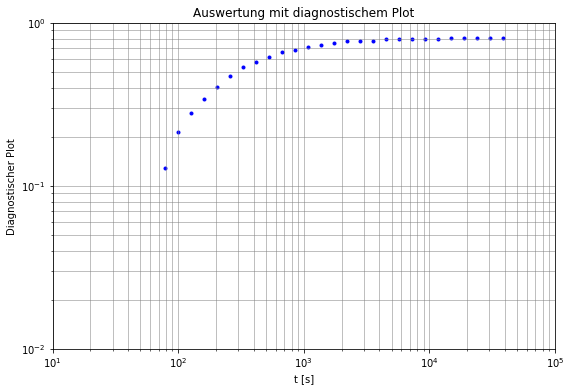

In [42]:
#Plot Function
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(t_av, b_diff, marker='.',color='blue')
3
plt.yscale("log")
plt.xscale("log")
plt.axis([10,1E5,1E-2,1E+0])
ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot',
       title='Auswertung mit diagnostischem Plot')
ax.grid(which="both", color='grey',linewidth=0.5)
plt.show()
    

<font color=blue> <em>Aufgabe 3: Lesen Sie den Wert des Plateaus und den für $t_{1/10}$ händisch aus den oben aufgeführten Messwerten ab und berechnen Sie mithilfe der oben dargestellten Formeln die Transmissivität und den Speicherkoeffizienten. Sind Ihre Ergebnisse identisch mit denen, die Sie eben iterativ bestimmt haben? Wenn nein: Für wie gravierend halten Sie den Unterschied und worauf könnte er zurückzuführen sein?</font> </em>

# 5. Abweichungen von den Theis'schen Grundvoraussetzungen
Im Folgenden sehen Sie die Daten eines weiteren Pumpversuches. Diesmal betrachten wir aber nicht nur eine einzelne Messstelle, sondern eine ganze Reihe an Messstellen, die sich in unterschiedlichen Entfernungen zum Pumpbrunnen befinden:

## Pumpversuch 5-1

In [73]:
#Pumprate [m3/s]:
Q = 1E-3
# Zeit nach Pumpbeginn in Sekunden
time2 = [0.00E+00,1.00E-02,2.00E-02,3.00E-02,4.00E-02,5.00E-02,6.00E-02,7.00E-02,8.00E-02,9.00E-02,1.00E-01,1.10E-01,1.20E-01,1.30E-01,1.40E-01,1.50E-01,1.60E-01,1.70E-01,1.80E-01,1.90E-01,2.00E-01,2.10E-01,2.20E-01,2.30E-01,2.40E-01,2.50E-01,2.60E-01,2.70E-01,2.80E-01,2.90E-01,3.00E-01,3.10E-01,3.20E-01,3.30E-01,3.40E-01,3.50E-01,3.60E-01,3.70E-01,3.80E-01,3.90E-01,4.00E-01,4.10E-01,4.20E-01,4.30E-01,4.40E-01,4.50E-01,4.60E-01,4.70E-01,4.80E-01,4.90E-01,5.00E-01,5.10E-01,5.20E-01,5.30E-01,5.40E-01,5.50E-01,5.60E-01,5.70E-01,5.80E-01,5.90E-01,6.00E-01,6.10E-01,6.20E-01,6.30E-01,6.40E-01,6.50E-01,6.60E-01,6.70E-01,6.80E-01,6.90E-01,7.00E-01,7.10E-01,7.20E-01,7.30E-01,7.40E-01,7.50E-01,7.60E-01,7.70E-01,7.80E-01,7.90E-01,8.00E-01,8.10E-01,8.20E-01,8.30E-01,8.40E-01,8.50E-01,8.60E-01,8.70E-01,8.80E-01,8.90E-01,9.00E-01,9.10E-01,9.20E-01,9.30E-01,9.40E-01,9.50E-01,9.60E-01,9.70E-01,9.80E-01,9.90E-01,1.00E+00,1.01E+00,1.02E+00,1.03E+00,1.04E+00,1.05E+00,1.06E+00,1.07E+00,1.08E+00,1.09E+00,1.10E+00,1.11E+00,1.12E+00,1.13E+00,1.14E+00,1.15E+00,1.16E+00,1.17E+00,1.18E+00,1.19E+00,1.20E+00,1.21E+00,1.22E+00,1.23E+00,1.24E+00,1.25E+00,1.26E+00,1.27E+00,1.28E+00,1.29E+00,1.30E+00,1.31E+00,1.32E+00,1.33E+00,1.34E+00,1.35E+00,1.36E+00,1.37E+00,1.38E+00,1.39E+00,1.40E+00,1.41E+00,1.42E+00,1.43E+00,1.44E+00,1.45E+00,1.46E+00,1.47E+00,1.48E+00,1.49E+00,1.50E+00,1.51E+00,1.52E+00,1.53E+00,1.54E+00,1.55E+00,1.56E+00,1.57E+00,1.58E+00,1.59E+00,1.60E+00,1.61E+00,1.62E+00,1.63E+00,1.64E+00,1.65E+00,1.66E+00,1.67E+00,1.68E+00,1.69E+00,1.70E+00,1.71E+00,1.72E+00,1.73E+00,1.74E+00,1.75E+00,1.76E+00,1.77E+00,1.78E+00,1.79E+00,1.80E+00,1.81E+00,1.82E+00,1.83E+00,1.84E+00,1.85E+00,1.86E+00,1.87E+00,1.88E+00,1.89E+00,1.90E+00,1.91E+00,1.92E+00,1.93E+00,1.94E+00,1.95E+00,1.96E+00,1.97E+00,1.98E+00,1.99E+00,2.00E+00,2.01E+00,2.02E+00,2.03E+00,2.04E+00,2.05E+00,2.06E+00,2.07E+00,2.08E+00,2.09E+00,2.10E+00,2.11E+00,2.12E+00,2.13E+00,2.14E+00,2.15E+00,2.16E+00,2.17E+00,2.18E+00,2.19E+00,2.20E+00,2.21E+00,2.22E+00,2.23E+00,2.24E+00,2.25E+00,2.26E+00,2.27E+00,2.28E+00,2.29E+00,2.30E+00,2.31E+00,2.32E+00,2.33E+00,2.34E+00,2.35E+00,2.36E+00,2.37E+00,2.38E+00,2.39E+00,2.40E+00,2.41E+00,2.42E+00,2.43E+00,2.44E+00,2.45E+00,2.46E+00,2.47E+00,2.48E+00,2.49E+00,2.50E+00,2.51E+00,2.52E+00,2.53E+00,2.54E+00,2.55E+00,2.56E+00,2.57E+00,2.58E+00,2.59E+00,2.60E+00,2.61E+00,2.62E+00,2.63E+00,2.64E+00,2.65E+00,2.66E+00,2.67E+00,2.68E+00,2.69E+00,2.70E+00,2.71E+00,2.72E+00,2.73E+00,2.74E+00,2.75E+00,2.76E+00,2.77E+00,2.78E+00,2.79E+00,2.80E+00,2.81E+00,2.82E+00,2.83E+00,2.84E+00,2.85E+00,2.86E+00,2.87E+00,2.88E+00,2.89E+00,2.90E+00,2.91E+00,2.92E+00,2.93E+00,2.94E+00,2.95E+00,2.96E+00,2.97E+00,2.98E+00,2.99E+00,3.00E+00,3.01E+00,3.02E+00,3.03E+00,3.04E+00,3.05E+00,3.06E+00,3.07E+00,3.08E+00,3.09E+00,3.10E+00,3.11E+00,3.12E+00,3.13E+00,3.14E+00,3.15E+00,3.16E+00,3.17E+00,3.18E+00,3.19E+00,3.20E+00,3.21E+00,3.22E+00,3.23E+00,3.24E+00,3.25E+00,3.26E+00,3.27E+00,3.28E+00,3.29E+00,3.30E+00,3.31E+00,3.32E+00,3.33E+00,3.34E+00,3.35E+00,3.36E+00,3.37E+00,3.38E+00,3.39E+00,3.40E+00,3.41E+00,3.42E+00,3.43E+00,3.44E+00,3.45E+00,3.46E+00,3.47E+00,3.48E+00,3.49E+00,3.50E+00,3.51E+00,3.52E+00,3.53E+00,3.54E+00,3.55E+00,3.56E+00,3.57E+00,3.58E+00,3.59E+00,3.60E+00,3.61E+00,3.62E+00,3.63E+00,3.64E+00,3.65E+00,3.66E+00,3.67E+00,3.68E+00,3.69E+00,3.70E+00,3.71E+00,3.72E+00,3.73E+00,3.74E+00,3.75E+00,3.76E+00,3.77E+00,3.78E+00,3.79E+00,3.80E+00,3.81E+00,3.82E+00,3.83E+00,3.84E+00,3.85E+00,3.86E+00,3.87E+00,3.88E+00,3.89E+00,3.90E+00,3.91E+00,3.92E+00,3.93E+00,3.94E+00,3.95E+00,3.96E+00,3.97E+00,3.98E+00,3.99E+00,4.00E+00,4.01E+00,4.02E+00,4.03E+00,4.04E+00,4.05E+00,4.06E+00,4.07E+00,4.08E+00,4.09E+00,4.10E+00,4.11E+00,4.12E+00,4.13E+00,4.14E+00,4.15E+00,4.16E+00,4.17E+00,4.18E+00,4.19E+00,4.20E+00,4.21E+00,4.22E+00,4.23E+00,4.24E+00,4.25E+00,4.26E+00,4.27E+00,4.28E+00,4.29E+00,4.30E+00,4.31E+00,4.32E+00,4.33E+00,4.34E+00,4.35E+00,4.36E+00,4.37E+00,4.38E+00,4.39E+00,4.40E+00,4.41E+00,4.42E+00,4.43E+00,4.44E+00,4.45E+00,4.46E+00,4.47E+00,4.48E+00,4.49E+00,4.50E+00,4.51E+00,4.52E+00,4.53E+00,4.54E+00,4.55E+00,4.56E+00,4.57E+00,4.58E+00,4.59E+00,4.60E+00,4.61E+00,4.62E+00,4.63E+00,4.64E+00,4.65E+00,4.66E+00,4.67E+00,4.68E+00,4.69E+00,4.70E+00,4.71E+00,4.72E+00,4.73E+00,4.74E+00,4.75E+00,4.76E+00,4.77E+00,4.78E+00,4.79E+00,4.80E+00,4.81E+00,4.82E+00,4.83E+00,4.84E+00,4.85E+00,4.86E+00,4.87E+00,4.88E+00,4.89E+00,4.90E+00,4.91E+00,4.92E+00,4.93E+00,4.94E+00,4.95E+00,4.96E+00,4.97E+00,4.98E+00,4.99E+00,5.00E+00,5.10E+00,5.20E+00,5.30E+00,5.40E+00,5.50E+00,5.60E+00,5.70E+00,5.80E+00,5.90E+00,6.00E+00,6.10E+00,6.20E+00,6.30E+00,6.40E+00,6.50E+00,6.60E+00,6.70E+00,6.80E+00,6.90E+00,7.00E+00,7.10E+00,7.20E+00,7.30E+00,7.40E+00,7.50E+00,7.60E+00,7.70E+00,7.80E+00,7.90E+00,8.00E+00,8.10E+00,8.20E+00,8.30E+00,8.40E+00,8.50E+00,8.60E+00,8.70E+00,8.80E+00,8.90E+00,9.00E+00,9.10E+00,9.20E+00,9.30E+00,9.40E+00,9.50E+00,9.60E+00,9.70E+00,9.80E+00,9.90E+00,1.00E+01,1.10E+01,1.20E+01,1.30E+01,1.40E+01,1.50E+01,1.60E+01,1.70E+01,1.80E+01,1.90E+01,2.00E+01,2.10E+01,2.20E+01,2.30E+01,2.40E+01,2.50E+01,2.60E+01,2.70E+01,2.80E+01,2.90E+01,3.00E+01,3.10E+01,3.20E+01,3.30E+01,3.40E+01,3.50E+01,3.60E+01,3.70E+01,3.80E+01,3.90E+01,4.00E+01,4.10E+01,4.20E+01,4.30E+01,4.40E+01,4.50E+01,4.60E+01,4.70E+01,4.80E+01,4.90E+01,5.00E+01,5.10E+01,5.20E+01,5.30E+01,5.40E+01,5.50E+01,5.60E+01,5.70E+01,5.80E+01,5.90E+01,6.00E+01,6.10E+01,6.20E+01,6.30E+01,6.40E+01,6.50E+01,6.60E+01,6.70E+01,6.80E+01,6.90E+01,7.00E+01,7.10E+01,7.20E+01,7.30E+01,7.40E+01,7.50E+01,7.60E+01,7.70E+01,7.80E+01,7.90E+01,8.00E+01,8.10E+01,8.20E+01,8.30E+01,8.40E+01,8.50E+01,8.60E+01,8.70E+01,8.80E+01,8.90E+01,9.00E+01,9.10E+01,9.20E+01,9.30E+01,9.40E+01,9.50E+01,9.60E+01,9.70E+01,9.80E+01,9.90E+01,1.00E+02,1.10E+02,1.20E+02,1.30E+02,1.40E+02,1.50E+02,1.60E+02,1.70E+02,1.80E+02,1.90E+02,2.00E+02,2.10E+02,2.20E+02,2.30E+02,2.40E+02,2.50E+02,2.60E+02,2.70E+02,2.80E+02,2.90E+02,3.00E+02,3.10E+02,3.20E+02,3.30E+02,3.40E+02,3.50E+02,3.60E+02,3.70E+02,3.80E+02,3.90E+02,4.00E+02,4.10E+02,4.20E+02,4.30E+02,4.40E+02,4.50E+02,4.60E+02,4.70E+02,4.80E+02,4.90E+02,5.00E+02,5.10E+02,5.20E+02,5.30E+02,5.40E+02,5.50E+02,5.60E+02,5.70E+02,5.80E+02,5.90E+02,6.00E+02,6.10E+02,6.20E+02,6.30E+02,6.40E+02,6.50E+02,6.60E+02,6.70E+02,6.80E+02,6.90E+02,7.00E+02,7.10E+02,7.20E+02,7.30E+02,7.40E+02,7.50E+02,7.60E+02,7.70E+02,7.80E+02,7.90E+02,8.00E+02,8.10E+02,8.20E+02,8.30E+02,8.40E+02,8.50E+02,8.60E+02,8.70E+02,8.80E+02,8.90E+02,9.00E+02,9.10E+02,9.20E+02,9.30E+02,9.40E+02,9.50E+02,9.60E+02,9.70E+02,9.80E+02,9.90E+02,1.00E+03,1.10E+03,1.20E+03,1.30E+03,1.40E+03,1.50E+03,1.60E+03,1.70E+03,1.80E+03,1.90E+03,2.00E+03,2.10E+03,2.20E+03,2.30E+03,2.40E+03,2.50E+03,2.60E+03,2.70E+03,2.80E+03,2.90E+03,3.00E+03,3.10E+03,3.20E+03,3.30E+03,3.40E+03,3.50E+03,3.60E+03,3.70E+03,3.80E+03,3.90E+03,4.00E+03,4.10E+03,4.20E+03,4.30E+03,4.40E+03,4.50E+03,4.60E+03,4.70E+03,4.80E+03,4.90E+03,5.00E+03,5.10E+03,5.20E+03,5.30E+03,5.40E+03,5.50E+03,5.60E+03,5.70E+03,5.80E+03,5.90E+03,6.00E+03,6.10E+03,6.20E+03,6.30E+03,6.40E+03,6.50E+03,6.60E+03,6.70E+03,6.80E+03,6.90E+03,7.00E+03,7.10E+03,7.20E+03,7.30E+03,7.40E+03,7.50E+03,7.60E+03,7.70E+03,7.80E+03,7.90E+03,8.00E+03,8.10E+03,8.20E+03,8.30E+03,8.40E+03,8.50E+03,8.60E+03,8.70E+03,8.80E+03,8.90E+03,9.00E+03,9.10E+03,9.20E+03,9.30E+03,9.40E+03,9.50E+03,9.60E+03,9.70E+03,9.80E+03,9.90E+03,1.00E+04,1.10E+04,1.20E+04,1.30E+04,1.40E+04,1.50E+04,1.60E+04,1.70E+04,1.80E+04,1.90E+04,2.00E+04,2.10E+04,2.20E+04,2.30E+04,2.40E+04,2.50E+04,2.60E+04,2.70E+04,2.80E+04,2.90E+04,3.00E+04,3.10E+04,3.20E+04,3.30E+04,3.40E+04,3.50E+04,3.60E+04,3.70E+04,3.80E+04,3.90E+04,4.00E+04,4.10E+04,4.20E+04,4.30E+04,4.40E+04,4.50E+04,4.60E+04,4.70E+04,4.80E+04,4.90E+04,5.00E+04,5.10E+04,5.20E+04,5.30E+04,5.40E+04,5.50E+04,5.60E+04,5.70E+04,5.80E+04,5.90E+04,6.00E+04,6.10E+04,6.20E+04,6.30E+04,6.40E+04,6.50E+04,6.60E+04,6.70E+04,6.80E+04,6.90E+04,7.00E+04,7.10E+04,7.20E+04,7.30E+04,7.40E+04,7.50E+04,7.60E+04,7.70E+04,7.80E+04,7.90E+04,8.00E+04,8.10E+04,8.20E+04,8.30E+04,8.40E+04,8.50E+04,8.60E+04,8.70E+04,8.80E+04,8.90E+04,9.00E+04,9.10E+04,9.20E+04,9.30E+04,9.40E+04,9.50E+04,9.60E+04,9.70E+04,9.80E+04,9.90E+04,1.00E+05,1.10E+05,1.20E+05,1.30E+05,1.40E+05,1.50E+05,1.60E+05,1.70E+05,1.80E+05,1.90E+05,2.00E+05,2.10E+05,2.20E+05,2.30E+05,2.40E+05,2.50E+05,2.60E+05,2.70E+05,2.80E+05,2.90E+05,3.00E+05,3.10E+05,3.20E+05,3.30E+05,3.40E+05,3.50E+05,3.60E+05,3.70E+05,3.80E+05,3.90E+05,4.00E+05,4.10E+05,4.20E+05,4.30E+05,4.40E+05,4.50E+05,4.60E+05,4.70E+05,4.80E+05,4.90E+05,5.00E+05,5.10E+05,5.20E+05,5.30E+05,5.40E+05,5.50E+05,5.60E+05,5.70E+05,5.80E+05,5.90E+05,6.00E+05,6.10E+05,6.20E+05,6.30E+05,6.40E+05,6.50E+05,6.60E+05,6.70E+05,6.80E+05,6.90E+05,7.00E+05,7.10E+05,7.20E+05,7.30E+05,7.40E+05,7.50E+05,7.60E+05,7.70E+05,7.80E+05,7.90E+05,8.00E+05,8.10E+05,8.20E+05,8.30E+05,8.40E+05,8.50E+05,8.60E+05,8.70E+05,8.80E+05,8.90E+05,9.00E+05,9.10E+05,9.20E+05,9.30E+05,9.40E+05,9.50E+05,9.60E+05,9.70E+05,9.80E+05,9.90E+05,1.00E+06]
#Wasserstände im Pumpbrunnen (Radius: 0.1 m) und in den Beobachtungsstellen (Entfernung zum Pumpbrunnen: 5, 10, 25, 50, 100, 200 m)
r_w = [0,0.131513596,0.197067261,0.235728264,0.261796951,0.281135559,0.296448708,0.309130669,0.319969177,0.329446793,0.337877274,0.345476151,0.352397919,0.358756065,0.364636421,0.370108604,0.375225067,0.380030632,0.384560585,0.38884449,0.39290905,0.396775246,0.400461197,0.40398407,0.407356262,0.410591125,0.41369915,0.416690826,0.41957283,0.422354698,0.425042152,0.427641869,0.430158615,0.432598114,0.434965134,0.437264442,0.439497948,0.441670418,0.443785667,0.445845604,0.447854042,0.449812889,0.451724052,0.453591347,0.455414772,0.457198143,0.45894146,0.460647583,0.46231842,0.463954926,0.465558052,0.467129707,0.468670845,0.470182419,0.471666336,0.473122597,0.474553108,0.47595787,0.477337837,0.478694916,0.480029106,0.481342316,0.482632637,0.483902931,0.485154152,0.486384392,0.487596512,0.488790512,0.489967346,0.491127014,0.492269516,0.493396759,0.494506836,0.495602608,0.496683121,0.497749329,0.498802185,0.499840736,0.500864983,0.501876831,0.502876282,0.503863335,0.50483799,0.505801201,0.506752968,0.507693291,0.508623123,0.509541512,0.510449409,0.511347771,0.512235641,0.513113976,0.513982773,0.514842033,0.515691757,0.516532898,0.517365456,0.518188477,0.519004822,0.51981163,0.520610809,0.521402359,0.522185326,0.522960663,0.523729324,0.524490356,0.525243759,0.525990486,0.526730537,0.527462959,0.528189659,0.528909683,0.529623032,0.530329704,0.531030655,0.531725883,0.532414436,0.533097267,0.533774376,0.534445763,0.535111427,0.53577137,0.536426544,0.53707695,0.53772068,0.538359642,0.538993835,0.53962326,0.540246964,0.540866852,0.541481018,0.54209137,0.542696953,0.543297768,0.543893814,0.544486046,0.545073509,0.545656204,0.546235085,0.54681015,0.547381401,0.547947884,0.548510551,0.549069405,0.549624443,0.550175667,0.550723076,0.55126667,0.551807404,0.552343369,0.552876472,0.553405762,0.55393219,0.55445385,0.554973602,0.555488586,0.556001663,0.556510925,0.557017326,0.557519913,0.558019638,0.558515549,0.559008598,0.559499741,0.559987068,0.560471535,0.56095314,0.561432838,0.561908722,0.562381744,0.562851906,0.563319206,0.563784599,0.564246178,0.564705849,0.565162659,0.565617561,0.566069603,0.566518784,0.566965103,0.567409515,0.567851067,0.56829071,0.568728447,0.569162369,0.569595337,0.570025444,0.57045269,0.570878029,0.57130146,0.571722984,0.572141647,0.572558403,0.572972298,0.573385239,0.573795319,0.574203491,0.574609756,0.575013161,0.575415611,0.575815201,0.576213837,0.576609612,0.577004433,0.577396393,0.577787399,0.578175545,0.578562737,0.578947067,0.579330444,0.57971096,0.580090523,0.580468178,0.580843925,0.581217766,0.581589699,0.581960678,0.58232975,0.582696915,0.583062172,0.583426476,0.583788872,0.584149361,0.584507942,0.58486557,0.585221291,0.585576057,0.585928917,0.586279869,0.586628914,0.586977959,0.587324142,0.587669373,0.588013649,0.588355064,0.58869648,0.589035988,0.589373589,0.589710236,0.590044975,0.590378761,0.590711594,0.591042519,0.591371536,0.5916996,0.592026711,0.592352867,0.592677116,0.592999458,0.5933218,0.593642235,0.593961716,0.594279289,0.594595909,0.594911575,0.595225334,0.595539093,0.595849991,0.596160889,0.596469879,0.59677887,0.597085953,0.597391129,0.597696304,0.597999573,0.598301888,0.598603249,0.598903656,0.599202156,0.599500656,0.599797249,0.600092888,0.600387573,0.600681305,0.600974083,0.601265907,0.601555824,0.601845741,0.602133751,0.602420807,0.602707863,0.602993011,0.603277206,0.603560448,0.603842735,0.604124069,0.604404449,0.604683876,0.604962349,0.605239868,0.605516434,0.605792046,0.606066704,0.606340408,0.606613159,0.606884956,0.6071558,0.607426643,0.60769558,0.607963562,0.608231544,0.60849762,0.608763695,0.609027863,0.60929203,0.609555244,0.609817505,0.610078812,0.610339165,0.610598564,0.610857964,0.611115456,0.611372948,0.611628532,0.611884117,0.612139702,0.612393379,0.612646103,0.612898827,0.613150597,0.613400459,0.613651276,0.613900185,0.61414814,0.614396095,0.614643097,0.614889145,0.615134239,0.615379333,0.615623474,0.615866661,0.616108894,0.616350174,0.616591454,0.616831779,0.617071152,0.617310524,0.617547989,0.617785454,0.618022919,0.618258476,0.618494034,0.618728638,0.618962288,0.619195938,0.619428635,0.619660378,0.61989212,0.620121956,0.620352745,0.620581627,0.620810509,0.621038437,0.621265411,0.621492386,0.621718407,0.621943474,0.622168541,0.622393608,0.622616768,0.622839928,0.623062134,0.62328434,0.623504639,0.623724937,0.623945236,0.624164581,0.624382973,0.624601364,0.624818802,0.62503624,0.625252724,0.625468254,0.625682831,0.625898361,0.626111984,0.626325607,0.626538277,0.626750946,0.626962662,0.627174377,0.627384186,0.627594948,0.627804756,0.628013611,0.628221512,0.628429413,0.628637314,0.628844261,0.629050255,0.629256248,0.629461288,0.629666328,0.629870415,0.630074501,0.630277634,0.630480766,0.630682945,0.630884171,0.631085396,0.631286621,0.631486893,0.631686211,0.631885529,0.632083893,0.632282257,0.632480621,0.632677078,0.632874489,0.633069992,0.633266449,0.633460999,0.633656502,0.633851051,0.634044647,0.634238243,0.634430885,0.634623528,0.63481617,0.635007858,0.635198593,0.635389328,0.635580063,0.635769844,0.635958672,0.636147499,0.636336327,0.6365242,0.636712074,0.636898994,0.637085915,0.637271881,0.637457848,0.637643814,0.637828827,0.638012886,0.638196945,0.638381004,0.63856411,0.638747215,0.638929367,0.639111519,0.639293671,0.639474869,0.639655113,0.639836311,0.640015602,0.640195847,0.640374184,0.640553474,0.640731812,0.640910149,0.641087532,0.641264915,0.641441345,0.641617775,0.641794205,0.641969681,0.642145157,0.642319679,0.642494202,0.642668724,0.642842293,0.643015862,0.643188477,0.643361092,0.643533707,0.643705368,0.643877029,0.644048691,0.644219398,0.644389153,0.64455986,0.644729614,0.644898415,0.645067215,0.645236015,0.645404816,0.645572662,0.645740509,0.645907402,0.646074295,0.646241188,0.646407127,0.646573067,0.646739006,0.646903992,0.647068977,0.647233009,0.647397041,0.647561073,0.647725105,0.647888184,0.648051262,0.648213387,0.648375511,0.648536682,0.648698807,0.648859978,0.649021149,0.64918232,0.650756836,0.652300835,0.653817177,0.655305862,0.656766891,0.658203125,0.659613609,0.661000252,0.662363052,0.663703918,0.66502285,0.666319847,0.667596817,0.66885376,0.670091629,0.671310425,0.672511101,0.673694611,0.674860001,0.676010132,0.677143097,0.678260803,0.679362297,0.680449486,0.681522369,0.682580948,0.683625221,0.684656143,0.685674667,0.68667984,0.687672615,0.688652992,0.689621925,0.690579414,0.691524506,0.692459106,0.693383217,0.694296837,0.695199966,0.696092606,0.696975708,0.697849274,0.698713303,0.699567795,0.70041275,0.701250076,0.702077866,0.702898026,0.703708649,0.704511642,0.711853981,0.718610764,0.724865913,0.73068428,0.736122131,0.741223335,0.746026993,0.750563622,0.754860878,0.758943558,0.762830734,0.766539574,0.770086288,0.773483276,0.776750565,0.779878616,0.782904625,0.785805702,0.788620949,0.791326523,0.793955803,0.796490669,0.798958778,0.801342964,0.803667068,0.805916786,0.808114052,0.810243607,0.812326431,0.814349175,0.816329002,0.818253517,0.820139885,0.821976662,0.823778152,0.825533867,0.827257156,0.828939438,0.830592155,0.832205772,0.833792686,0.835344315,0.836870193,0.838363647,0.839834213,0.841273308,0.842691422,0.844080925,0.845450401,0.846793175,0.848117828,0.849416733,0.850698471,0.851956367,0.853198051,0.854417801,0.855622292,0.856805801,0.857975006,0.859125137,0.860260963,0.86137867,0.862483025,0.863570213,0.864645004,0.865702629,0.866749763,0.867780685,0.868801117,0.86980629,0.870800018,0.871780396,0.872751236,0.873707771,0.874655724,0.875590324,0.876515388,0.877429008,0.878333092,0.879226685,0.880110741,0.880984306,0.881849289,0.882704735,0.883551598,0.88438797,0.885217667,0.886036873,0.886850357,0.887653351,0.895002365,0.901783943,0.908041954,0.913890839,0.919335365,0.924466133,0.929279327,0.933843613,0.938153267,0.942263603,0.946164131,0.949890137,0.953467369,0.956882477,0.960173607,0.963372231,0.966389656,0.969311714,0.972145081,0.974895477,0.977523804,0.980075836,0.982561111,0.984983444,0.987286568,0.98957634,0.991798401,0.9939394,0.996021271,0.998066902,1.000062943,1.00198555,1.003892899,1.005759239,1.007544518,1.009324074,1.011071205,1.012742996,1.014410973,1.016052246,1.017623901,1.019193649,1.020740509,1.022222519,1.023715973,1.025150299,1.026589394,1.027975082,1.029364586,1.030703545,1.032046318,1.033341408,1.034640312,1.035895348,1.037153244,1.038370132,1.039588928,1.040769577,1.041952133,1.043099403,1.044248581,1.045362473,1.046480179,1.047563553,1.048650742,1.049706459,1.050764084,1.051792145,1.052823067,1.053825378,1.054830551,1.055808067,1.056788445,1.057743073,1.058699608,1.059632301,1.060566902,1.061477661,1.062390327,1.063281059,1.064174652,1.065045357,1.065918922,1.066771507,1.067625999,1.068460464,1.069297791,1.070115089,1.070935249,1.071736336,1.079128265,1.085912704,1.092216492,1.098059654,1.103539467,1.108667374,1.113501549,1.11809063,1.122407913,1.126506805,1.13045311,1.134186745,1.137776375,1.141212463,1.144512177,1.147675514,1.150727272,1.153652191,1.156481743,1.159198761,1.161832809,1.164369583,1.16683197,1.169207573,1.171515465,1.173747063,1.175918579,1.178017616,1.180062294,1.182044029,1.183974266,1.185845375,1.187669754,1.189441681,1.191167831,1.19284153,1.194476128,1.196063042,1.197621346,1.199128151,1.200608253,1.202044487,1.203440666,1.204803467,1.206129074,1.207418442,1.208688736,1.209916115,1.211121559,1.21229744,1.213434219,1.214553833,1.215636253,1.216691971,1.217730522,1.218742371,1.219723701,1.220685959,1.221622467,1.222529411,1.223428726,1.224298477,1.225144386,1.225975037,1.226783752,1.227573395,1.228347778,1.229097366,1.229826927,1.23055172,1.231248856,1.231935501,1.232585907,1.23324585,1.233872414,1.23449707,1.235096931,1.235691071,1.236268044,1.236825943,1.237372398,1.237914085,1.238435745,1.238945961,1.239442825,1.239929199,1.240395546,1.2408638,1.241312027,1.241758347,1.245306969,1.248157501,1.250433922,1.252264023,1.253765106,1.254948616,1.255914688,1.256662369,1.257273674,1.257762909,1.258153915,1.258471489,1.258722305,1.258928299,1.259090424,1.259222031,1.259327888,1.259391785,1.259397507,1.259405136,1.259415627,1.259423256,1.259431839,1.259438515,1.259446144,1.259451866,1.259459496,1.25946331,1.259471893,1.259475708,1.259483337,1.259486198,1.259493828,1.259496689,1.259504318,1.259506226,1.259513855,1.259515762,1.259522438,1.259525299,1.259531975,1.259533882,1.259539604,1.259541512,1.259548187,1.259550095,1.259555817,1.259557724,1.259563446,1.259565353,1.259571075,1.259572029,1.259577751,1.259578705,1.259584427,1.259585381,1.259591103,1.259592056,1.259596825,1.259597778,1.259602547,1.2596035,1.259608269,1.259609222,1.259613991,1.259614944,1.259619713,1.259620667,1.259624481,1.259625435,1.25962925,1.259630203,1.259634018,1.259634972,1.259638786,1.25963974,1.259643555,1.259644508,1.259647369,1.259648323,1.259651184,1.259652138,1.259655952,1.259655952,1.259659767,1.259659767,1.259662628,1.259663582,1.259666443,1.259667397,1.259691238,1.259694099,1.259700775,1.259705544,1.259710312,1.259714127,1.259717941,1.259720802,1.259723663,1.259726524,1.259728432,1.259731293,1.259732246,1.259735107,1.259736061,1.259737968,1.259738922,1.259740829,1.259741783,1.25974369,1.25974369,1.259745598,1.259745598,1.259747505,1.259747505,1.259748459,1.259749413,1.259750366,1.259750366,1.25975132,1.25975132,1.259752274,1.259752274,1.259753227,1.259753227,1.259754181,1.259754181,1.259755135,1.259755135,1.259755135,1.259755135,1.259756088,1.259756088,1.259756088,1.259756088,1.259757042,1.259757042,1.259757042,1.259757042,1.259757042,1.259757996,1.259757996,1.259757996,1.259757996,1.259757996,1.259757996,1.259757996,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259758949,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903,1.259759903]
r_5 = [0,0,9.54E-07,2.86E-06,7.63E-06,1.62E-05,3.15E-05,5.34E-05,8.58E-05,0.000127792,0.000184059,0.000253677,0.000338554,0.00043869,0.000555992,0.00069046,0.000843048,0.001012802,0.001199722,0.001404762,0.001626015,0.001864433,0.002119064,0.002388954,0.002674103,0.002973557,0.003286362,0.003612518,0.003950119,0.004300117,0.00466156,0.005032539,0.005414009,0.005804062,0.006202698,0.006609917,0.007024765,0.007445335,0.007873535,0.008307457,0.008747101,0.009190559,0.00963974,0.010093689,0.010550499,0.011011124,0.011475563,0.011942863,0.012412071,0.01288414,0.013358116,0.013834,0.01431179,0.014790535,0.015271187,0.015751839,0.016234398,0.016716957,0.01720047,0.017683029,0.018167496,0.018651009,0.019134521,0.019618034,0.020101547,0.020584106,0.021066666,0.021548271,0.022028923,0.022509575,0.022989273,0.023467064,0.023944855,0.024421692,0.024896622,0.025371552,0.025844574,0.026315689,0.026786804,0.027256012,0.027724266,0.028190613,0.028656006,0.029119492,0.02958107,0.030041695,0.030501366,0.030959129,0.031414986,0.031869888,0.032322884,0.032773972,0.033224106,0.033671379,0.034118652,0.034563065,0.035005569,0.035447121,0.035886765,0.036325455,0.036761284,0.037196159,0.037629128,0.038060188,0.038490295,0.038917542,0.039343834,0.039768219,0.04019165,0.040612221,0.041031837,0.041449547,0.041865349,0.042280197,0.042693138,0.043104172,0.043513298,0.043920517,0.044326782,0.04473114,0.045133591,0.045534134,0.045933723,0.046332359,0.046728134,0.047122955,0.047515869,0.047906876,0.048296928,0.048685074,0.049072266,0.04945755,0.049840927,0.050222397,0.050602913,0.050981522,0.051359177,0.051734924,0.052109718,0.052482605,0.052853584,0.05322361,0.053591728,0.053958893,0.054325104,0.054688454,0.05505085,0.055412292,0.055771828,0.056130409,0.056487083,0.056842804,0.057196617,0.057549477,0.057900429,0.058250427,0.058599472,0.058946609,0.05929184,0.05963707,0.059980392,0.060321808,0.06066227,0.061001778,0.061339378,0.061676025,0.062011719,0.062345505,0.062678337,0.063010216,0.063341141,0.063670158,0.063998222,0.064324379,0.064650536,0.064974785,0.06529808,0.065619469,0.065940857,0.066260338,0.066578865,0.066896439,0.067212105,0.067526817,0.067840576,0.068153381,0.068465233,0.068775177,0.069085121,0.069393158,0.069700241,0.070005417,0.070310593,0.070614815,0.07091713,0.071219444,0.071519852,0.071819305,0.072117805,0.072415352,0.072711945,0.073007584,0.073302269,0.073596001,0.073887825,0.074179649,0.074469566,0.074759483,0.075047493,0.075335503,0.075621605,0.075907707,0.076191902,0.076476097,0.076759338,0.077040672,0.077322006,0.077601433,0.077880859,0.078158379,0.078435898,0.078712463,0.078987122,0.07926178,0.079535484,0.079808235,0.080080032,0.080350876,0.080621719,0.080890656,0.081159592,0.08142662,0.081693649,0.081958771,0.082223892,0.08248806,0.082751274,0.083013535,0.083275795,0.083536148,0.083796501,0.084055901,0.0843153,0.084572792,0.08482933,0.085085869,0.085341454,0.085596085,0.085849762,0.086102486,0.086355209,0.086606026,0.086856842,0.087106705,0.087356567,0.087604523,0.087852478,0.08809948,0.088346481,0.088591576,0.08883667,0.089080811,0.089323997,0.089567184,0.089809418,0.090050697,0.090291023,0.090531349,0.090770721,0.09100914,0.091246605,0.09148407,0.091720581,0.091956139,0.092191696,0.0924263,0.09265995,0.0928936,0.093126297,0.09335804,0.093588829,0.093819618,0.094049454,0.094278336,0.094507217,0.094735146,0.094963074,0.095190048,0.095416069,0.095641136,0.095866203,0.09609127,0.09631443,0.09653759,0.09676075,0.096982002,0.097204208,0.097424507,0.097644806,0.097864151,0.098083496,0.098301888,0.098519325,0.098736763,0.098954201,0.099169731,0.099385262,0.099600792,0.099815369,0.100028992,0.100242615,0.100455284,0.100667,0.100878716,0.101090431,0.101301193,0.101511002,0.10172081,0.101929665,0.102137566,0.102345467,0.102553368,0.102760315,0.102966309,0.103172302,0.103377342,0.103582382,0.103786469,0.103990555,0.104193687,0.10439682,0.104598999,0.104801178,0.105002403,0.105202675,0.105402946,0.105603218,0.105802536,0.1060009,0.106200218,0.106397629,0.106595039,0.10679245,0.106988907,0.107185364,0.107380867,0.107575417,0.107769966,0.107964516,0.108158112,0.108350754,0.108543396,0.108736038,0.108927727,0.109119415,0.10931015,0.109500885,0.10969162,0.109881401,0.110070229,0.110259056,0.110447884,0.110634804,0.110822678,0.111009598,0.111196518,0.111382484,0.111568451,0.111753464,0.111938477,0.112123489,0.112307549,0.112490654,0.112674713,0.112857819,0.11303997,0.113222122,0.113404274,0.113585472,0.113765717,0.113945961,0.114126205,0.114305496,0.114484787,0.114664078,0.114842415,0.115020752,0.115198135,0.115375519,0.115551949,0.115729332,0.115904808,0.116081238,0.116256714,0.116431236,0.116605759,0.116780281,0.11695385,0.117127419,0.117300987,0.117473602,0.117646217,0.117817879,0.11798954,0.118161201,0.118331909,0.118502617,0.118673325,0.118843079,0.119011879,0.119181633,0.119350433,0.11951828,0.11968708,0.119853973,0.12002182,0.120188713,0.120355606,0.120522499,0.120688438,0.120853424,0.121019363,0.121184349,0.121348381,0.121513367,0.121677399,0.121840477,0.122004509,0.122167587,0.122329712,0.122491837,0.122653961,0.122816086,0.122977257,0.123138428,0.123299599,0.123459816,0.123620033,0.123780251,0.123939514,0.124098778,0.124258041,0.124416351,0.124574661,0.124732018,0.124889374,0.125047684,0.125204086,0.125361443,0.125517845,0.125674248,0.125829697,0.125985146,0.126140594,0.12629509,0.126450539,0.126605034,0.126758575,0.126912117,0.127065659,0.1272192,0.127371788,0.127524376,0.127676964,0.127828598,0.127980232,0.128131866,0.128283501,0.128434181,0.128584862,0.128735542,0.128885269,0.129034996,0.129184723,0.129333496,0.129482269,0.129631042,0.129779816,0.129927635,0.130075455,0.130223274,0.13037014,0.130517006,0.130663872,0.130810738,0.13095665,0.131102562,0.131248474,0.131393433,0.131538391,0.13168335,0.131828308,0.131972313,0.132117271,0.132261276,0.132404327,0.132548332,0.132691383,0.132833481,0.132976532,0.133119583,0.134518623,0.135894775,0.137248039,0.138578415,0.139888763,0.141177177,0.142446518,0.143695831,0.144926071,0.146138191,0.147332191,0.148509026,0.149668694,0.150812149,0.151939392,0.153051376,0.154148102,0.155230522,0.156298637,0.157352448,0.158391953,0.15941906,0.160433769,0.161435127,0.162424088,0.16340065,0.164365768,0.165319443,0.166262627,0.167194366,0.168114662,0.169025421,0.16992569,0.170816422,0.171696663,0.172567368,0.173428535,0.17428112,0.175125122,0.175959587,0.176785469,0.177602768,0.178411484,0.17921257,0.180006027,0.180791855,0.181569099,0.182338715,0.183101654,0.183857918,0.19080162,0.197218895,0.203181267,0.208745956,0.213959694,0.218863487,0.223491669,0.227871895,0.232028961,0.235984802,0.239756584,0.243360519,0.246810913,0.250120163,0.253300667,0.256362915,0.259309769,0.262156487,0.264902115,0.267560959,0.270130157,0.272623062,0.275038719,0.277385712,0.279663086,0.281880379,0.284035683,0.286136627,0.288181305,0.290177345,0.292123795,0.294024467,0.295880318,0.29769516,0.29946804,0.301204681,0.302902222,0.304566383,0.306195259,0.307792664,0.309357643,0.310894012,0.312399864,0.313879013,0.315330505,0.316757202,0.318157196,0.319535255,0.320887566,0.322219849,0.32352829,0.324816704,0.326084137,0.327332497,0.328560829,0.329771042,0.330963135,0.332138062,0.333294868,0.334436417,0.335561752,0.336670876,0.33776474,0.338844299,0.339909554,0.340960503,0.3419981,0.343022346,0.344033241,0.345031738,0.346017838,0.346992493,0.34795475,0.348905563,0.349845886,0.350774765,0.351693153,0.352601051,0.353498459,0.35438633,0.35526371,0.356132507,0.356991768,0.357841492,0.358682632,0.35951519,0.360338211,0.361153603,0.361960411,0.36275959,0.370073318,0.376806259,0.383049965,0.388858795,0.394294739,0.399393082,0.4041996,0.40873909,0.41304493,0.417133331,0.421030045,0.424757004,0.428312302,0.43173027,0.435002327,0.438169479,0.441198349,0.444139481,0.446947098,0.449681282,0.452309608,0.454877853,0.457343102,0.459749222,0.462085724,0.464343071,0.466556549,0.468695641,0.47079277,0.472819328,0.474811554,0.476746559,0.478639603,0.48048687,0.48229599,0.484065056,0.485790253,0.487483978,0.489145279,0.490765572,0.492357254,0.49392128,0.495448112,0.496949196,0.49842453,0.499875069,0.501296997,0.502696991,0.504069328,0.505421638,0.506748199,0.508056641,0.509340286,0.510606766,0.511850357,0.51307869,0.514284134,0.515475273,0.516646385,0.517803192,0.518939972,0.520064354,0.521169662,0.522263527,0.523339272,0.524403572,0.525450706,0.52648735,0.527508736,0.528518677,0.529514313,0.530499458,0.531471252,0.532432556,0.533381462,0.534319878,0.535246849,0.536164284,0.537069321,0.537966728,0.538851738,0.539729118,0.540595055,0.541454315,0.542302132,0.543142319,0.543972969,0.54479599,0.545609474,0.546416283,0.553801537,0.560572624,0.566877365,0.572715759,0.578196526,0.58334446,0.588163376,0.592734337,0.597067833,0.601172447,0.605114937,0.608834267,0.61242485,0.615858078,0.619168282,0.622320175,0.625382423,0.628295898,0.631134987,0.633841515,0.6364851,0.639011383,0.641483307,0.643848419,0.646165848,0.648386955,0.650566101,0.652655602,0.654709816,0.656681061,0.658618927,0.660480499,0.662312508,0.664074898,0.665807724,0.667473793,0.66911602,0.670698166,0.672261238,0.673762321,0.675225258,0.676664352,0.678062439,0.679427147,0.680773735,0.682048798,0.683321953,0.68454361,0.685736656,0.686911583,0.688051224,0.689169884,0.690266609,0.691316605,0.692343712,0.693353653,0.694338799,0.695300102,0.696247101,0.697154045,0.698040962,0.698914528,0.699773788,0.700591087,0.701406479,0.702189445,0.702952385,0.703712463,0.704450607,0.705163002,0.705856323,0.706548691,0.707206726,0.707860947,0.708489418,0.709112167,0.709711075,0.71030426,0.710873604,0.711433411,0.711987495,0.712522507,0.713038445,0.713553429,0.714047432,0.714539528,0.715006828,0.715467453,0.715922356,0.716358185,0.719910622,0.722740173,0.725031853,0.726893425,0.728356361,0.729530334,0.730504036,0.731240273,0.731865883,0.732347488,0.732744217,0.733059883,0.733312607,0.733517647,0.733680725,0.733815193,0.73391819,0.734002113,0.733984947,0.734012604,0.734002113,0.734027863,0.734018326,0.734041214,0.734032631,0.734053612,0.734045982,0.734065056,0.73405838,0.734075546,0.734068871,0.734086037,0.734080315,0.734095573,0.734089851,0.73410511,0.734099388,0.734113693,0.734108925,0.734122276,0.734118462,0.734130859,0.734127045,0.734138489,0.734134674,0.734147072,0.734142303,0.734153748,0.734149933,0.734161377,0.734157562,0.734168053,0.734165192,0.734174728,0.734171867,0.734181404,0.734177589,0.734187126,0.734184265,0.734193802,0.734189987,0.734199524,0.734196663,0.734204292,0.734202385,0.734210014,0.734207153,0.734214783,0.734212875,0.734220505,0.734217644,0.734225273,0.734222412,0.734229088,0.73422718,0.734233856,0.734231949,0.734238625,0.734235764,0.734242439,0.734240532,0.734246254,0.734244347,0.734250069,0.734248161,0.734253883,0.734251976,0.734257698,0.734255791,0.734260559,0.734276772,0.734284401,0.734292984,0.734296799,0.734301567,0.734305382,0.734308243,0.734312057,0.734314919,0.73431778,0.734319687,0.734322548,0.734323502,0.734326363,0.734327316,0.734329224,0.734330177,0.734332085,0.734333038,0.734334946,0.734334946,0.734336853,0.734336853,0.73433876,0.73433876,0.734339714,0.734340668,0.734341621,0.734341621,0.734342575,0.734342575,0.734343529,0.734343529,0.734344482,0.734344482,0.734345436,0.734345436,0.734345436,0.73434639,0.73434639,0.73434639,0.734347343,0.734347343,0.734347343,0.734347343,0.734348297,0.734348297,0.734348297,0.734348297,0.734348297,0.734348297,0.734349251,0.734349251,0.734349251,0.734349251,0.734349251,0.734349251,0.734349251,0.734349251,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734350204,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158,0.734351158]
r_10 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.54E-07,9.54E-07,9.54E-07,1.91E-06,1.91E-06,2.86E-06,3.81E-06,4.77E-06,6.68E-06,7.63E-06,9.54E-06,1.24E-05,1.43E-05,1.72E-05,2.10E-05,2.38E-05,2.77E-05,3.24E-05,3.72E-05,4.39E-05,5.05E-05,5.72E-05,6.48E-05,7.34E-05,8.20E-05,9.16E-05,0.000102043,0.000114441,0.000126839,0.00014019,0.000154495,0.000169754,0.000185966,0.000203133,0.000221252,0.000240326,2.60E-04,2.82E-04,3.04E-04,3.27E-04,3.52E-04,3.78E-04,4.04E-04,4.33E-04,4.62E-04,4.92E-04,5.24E-04,5.56E-04,5.90E-04,6.26E-04,6.62E-04,7.00E-04,7.38E-04,7.78E-04,8.19E-04,8.62E-04,9.05E-04,9.50E-04,9.96E-04,1.04E-03,1.09E-03,1.14E-03,1.19E-03,1.24E-03,1.30E-03,1.35E-03,1.41E-03,1.46E-03,1.52E-03,0.001578331,1.64E-03,1.70E-03,1.76E-03,0.001824379,0.001888275,0.001953125,0.002018929,0.002086639,0.00215435,0.002223969,0.002293587,0.002365112,0.002437592,0.002511024,0.002584457,0.002659798,0.002735138,0.002812386,0.002890587,0.002968788,0.003048897,0.003129005,0.003210068,0.003292084,0.003375053,0.003458977,0.003543854,0.003628731,0.003715515,0.003802299,0.003890038,0.003977776,0.004067421,0.004157066,0.004247665,0.004339218,0.004431725,0.004524231,0.004616737,0.004711151,0.004805565,0.004900932,0.004997253,0.005093575,0.005190849,0.005289078,0.005387306,0.005486488,0.00558567,0.005685806,0.005785942,0.005887032,0.005988121,0.006091118,0.006193161,0.006297112,0.006400108,0.006504059,0.006608963,0.006713867,0.006818771,0.006924629,0.007031441,0.007138252,0.007245064,0.007352829,0.007460594,0.007569313,0.007678032,0.007786751,0.007896423,0.008006096,0.008115768,0.008226395,0.008337021,0.008448601,0.008560181,0.008671761,0.00878334,0.008895874,0.009008408,0.009121895,0.009234428,0.009347916,0.009462357,0.009575844,0.009690285,0.009804726,0.009919167,0.010034561,0.010149956,0.01026535,0.010380745,0.010497093,0.010612488,0.010728836,0.010845184,0.010962486,0.011078835,0.011196136,0.011313438,0.01143074,0.011548996,0.011666298,0.011784554,0.011902809,0.012020111,0.01213932,0.012257576,0.012375832,0.012495041,0.01261425,0.012732506,0.012851715,0.012970924,0.013091087,0.013209343,0.013329506,0.013448715,0.013568878,0.013688087,0.01380825,0.013928413,0.014048576,0.014168739,0.014288902,0.014410019,0.014530182,0.014650345,0.014770508,0.014891624,0.015011787,0.015132904,0.015253067,0.015374184,0.0154953,0.015615463,0.01573658,0.015857697,0.015978813,0.01609993,0.016221046,0.016342163,0.01646328,0.016584396,0.016705513,0.01682663,0.016947746,0.017068863,0.01718998,0.017311096,0.017432213,0.017553329,0.017674446,0.017795563,0.017916679,0.018037796,0.018159866,0.018280983,0.0184021,0.018523216,0.018644333,0.01876545,0.018886566,0.019006729,0.019128799,0.019249916,0.019370079,0.019491196,0.019612312,0.019732475,0.019853592,0.019974709,0.020094872,0.020215988,0.020336151,0.020457268,0.020577431,0.020698547,0.02081871,0.020939827,0.02105999,0.021181107,0.02130127,0.021421432,0.021541595,0.021661758,0.021781921,0.021903038,0.022023201,0.02214241,0.022262573,0.022382736,0.022502899,0.022623062,0.022742271,0.022861481,0.022981644,0.023100853,0.023221016,0.023340225,0.023459435,0.023578644,0.023697853,0.023817062,0.023936272,0.024055481,0.024173737,0.024292946,0.024411201,0.024530411,0.024648666,0.024767876,0.024886131,0.025004387,0.025122643,0.025240898,0.025359154,0.025476456,0.025594711,0.025712967,0.025830269,0.025948524,0.026065826,0.026184082,0.026301384,0.026418686,0.026535988,0.02665329,0.026770592,0.026887894,0.027005196,0.027121544,0.027238846,0.027355194,0.027472496,0.027588844,0.027705193,0.027821541,0.027937889,0.028053284,0.028169632,0.02828598,0.028401375,0.028517723,0.028633118,0.028748512,0.028863907,0.028979301,0.029094696,0.029210091,0.029325485,0.02944088,0.029555321,0.029669762,0.029784203,0.029899597,0.030014038,0.030128479,0.03024292,0.030357361,0.030470848,0.030585289,0.03069973,0.030813217,0.030926704,0.031040192,0.031153679,0.031267166,0.031380653,0.031494141,0.031606674,0.031720161,0.031832695,0.031946182,0.032058716,0.032171249,0.032283783,0.032396317,0.032507896,0.03262043,0.03273201,0.032844543,0.032956123,0.033067703,0.033180237,0.033291817,0.033403397,0.033514977,0.033625603,0.033737183,0.033847809,0.033958435,0.034069061,0.034179688,0.034290314,0.03440094,0.034511566,0.034622192,0.034731865,0.034842491,0.034952164,0.035061836,0.035171509,0.035281181,0.035390854,0.035500526,0.035609245,0.035718918,0.03582859,0.035937309,0.036046028,0.036154747,0.036263466,0.036372185,0.036480904,0.036588669,0.036697388,0.036806107,0.036913872,0.037021637,0.037129402,0.037237167,0.037344933,0.037452698,0.037559509,0.037667274,0.037774086,0.037880898,0.037988663,0.038095474,0.038202286,0.038309097,0.038415909,0.038521767,0.038627625,0.038733482,0.03883934,0.038945198,0.03905201,0.039157867,0.039262772,0.039368629,0.039474487,0.039580345,0.039685249,0.039790154,0.039895058,0.039999962,0.040104866,0.04020977,0.040313721,0.040418625,0.040523529,0.04062748,0.04073143,0.040835381,0.040939331,0.041043282,0.041147232,0.041251183,0.041354179,0.04145813,0.041561127,0.041665077,0.041768074,0.041871071,0.041974068,0.042076111,0.042179108,0.042282104,0.042384148,0.042487144,0.042589188,0.042691231,0.042793274,0.042895317,0.04299736,0.043099403,0.043200493,0.043302536,0.043403625,0.043504715,0.043606758,0.043707848,0.043808937,0.043910027,0.044011116,0.044111252,0.044211388,0.044312477,0.044412613,0.044512749,0.044612885,0.04471302,0.044813156,0.044913292,0.045013428,0.04511261,0.045212746,0.045311928,0.04541111,0.045510292,0.045609474,0.045707703,0.045806885,0.045906067,0.046005249,0.046103477,0.04620266,0.046300888,0.046399117,0.046496391,0.046595573,0.047567368,0.048528671,0.049480438,0.050422668,0.051356316,0.052279472,0.053193092,0.054098129,0.054994583,0.0558815,0.056760788,0.057630539,0.058491707,0.059345245,0.060190201,0.061027527,0.061857224,0.062678337,0.063491821,0.064297676,0.065095901,0.065887451,0.066672325,0.067448616,0.068219185,0.068982124,0.069738388,0.070487976,0.071230888,0.071968079,0.072698593,0.073422432,0.074140549,0.07485199,0.075557709,0.076258659,0.076951981,0.077640533,0.078323364,0.079001427,0.079672813,0.080339432,0.081000328,0.081656456,0.082307816,0.082953453,0.083594322,0.084229469,0.084860802,0.085487366,0.091329575,0.096800804,0.101942062,0.106788635,0.11137104,0.115715027,0.119843483,0.123775482,0.127529144,0.131118774,0.134557724,0.137857437,0.141029358,0.144082069,0.147026062,0.149867058,0.152611732,0.155267715,0.157837868,0.160328865,0.162746429,0.165092468,0.16737175,0.169589043,0.171746254,0.173848152,0.175895691,0.177892685,0.179841042,0.181742668,0.183601379,0.185417175,0.187192917,0.188930511,0.190630913,0.192296028,0.193927765,0.195527077,0.197093964,0.19863224,0.200139999,0.201621056,0.203074455,0.204503059,0.205905914,0.207283974,0.208640099,0.209972382,0.211283684,0.212573051,0.213843346,0.215092659,0.216322899,0.217535019,0.218728065,0.2199049,0.221063614,0.222206116,0.223332405,0.224443436,0.225539207,0.22661972,0.227686882,0.228738785,0.229777336,0.23080349,0.231815338,0.232815742,0.233802795,0.234778404,0.235741615,0.236694336,0.237635612,0.238565445,0.239484787,0.240393639,0.241292953,0.242180824,0.243060112,0.243929863,0.244790077,0.245640755,0.246482849,0.24731636,0.248141289,0.248957634,0.249765396,0.250565529,0.251357079,0.252140999,0.259331703,0.265962601,0.2721138,0.277845383,0.283209801,0.288249016,0.293000221,0.297492027,0.301753044,0.305803299,0.309663773,0.313352585,0.316885948,0.320270538,0.323522568,0.326659203,0.329672813,0.332586288,0.335382462,0.338094711,0.340711594,0.34325695,0.345713615,0.348104477,0.350426674,0.352677345,0.354869843,0.357005119,0.359090805,0.361109734,0.3630867,0.365022659,0.366900444,0.368745804,0.370546341,0.372302055,0.374027252,0.375714302,0.377362251,0.37898159,0.380568504,0.382120132,0.383646011,0.38514328,0.386611938,0.388056755,0.389473915,0.390868187,0.39223671,0.393584251,0.394906998,0.39621067,0.397490501,0.398753166,0.399992943,0.401216507,0.402420044,0.403607368,0.404774666,0.405927658,0.407062531,0.408183098,0.409286499,0.410376549,0.411450386,0.412511826,0.413557053,0.414590836,0.41560936,0.416617393,0.417610168,0.418593407,0.41956234,0.420521736,0.421468735,0.422405243,0.423330307,0.424245834,0.425148964,0.42604351,0.426927567,0.42780304,0.428668022,0.429524422,0.430370331,0.431209564,0.432038307,0.432859421,0.433671951,0.434476852,0.44182682,0.448617935,0.454893112,0.460741997,0.466201782,0.471340179,0.476165771,0.480723381,0.485051155,0.489171028,0.493082047,0.496828079,0.500414848,0.503832817,0.507125854,0.5102911,0.513334274,0.516263962,0.51908493,0.521805763,0.524432182,0.526971817,0.529428482,0.531805038,0.534108162,0.536341667,0.538507462,0.540607452,0.542648315,0.544630051,0.546556473,0.548427582,0.550248146,0.552019119,0.553742409,0.5554142,0.55704689,0.558636665,0.560189247,0.561695099,0.563163757,0.564602852,0.56599617,0.567358971,0.568688393,0.569978714,0.571242332,0.572468758,0.573665619,0.574841499,0.575977325,0.577094078,0.578180313,0.579236031,0.580265999,0.581278801,0.582258224,0.583219528,0.584157944,0.585065842,0.585957527,0.586827278,0.587676048,0.588504791,0.5893116,0.590100288,0.590867996,0.591618538,0.592352867,0.593069077,0.593765259,0.594449997,0.595108986,0.595759392,0.596391678,0.597009659,0.597612381,0.598201752,0.598775864,0.59933567,0.599884987,0.600419998,0.600939751,0.601451874,0.601946831,0.602433205,0.602901459,0.603364944,0.603816032,0.604255676,0.607802391,0.610640526,0.6129179,0.614760399,0.616234779,0.617422104,0.618375778,0.619132996,0.619737625,0.620232582,0.620619774,0.620940208,0.621189117,0.621396065,0.621557236,0.62169075,0.621794701,0.621870041,0.621862411,0.621882439,0.621879578,0.621898651,0.621896744,0.621912956,0.621911049,0.621925354,0.621923447,0.621936798,0.621935844,0.621948242,0.621947289,0.621958733,0.621957779,0.621968269,0.621967316,0.621977806,0.621977806,0.621987343,0.621986389,0.621995926,0.621995926,0.622004509,0.622003555,0.622012138,0.622012138,0.622019768,0.622019768,0.622027397,0.622027397,0.622035027,0.622035027,0.622041702,0.622041702,0.622048378,0.622048378,0.622055054,0.622055054,0.622061729,0.622061729,0.622067451,0.622067451,0.622073174,0.622073174,0.622078896,0.622078896,0.622084618,0.622084618,0.622089386,0.622089386,0.622094154,0.622094154,0.622098923,0.622098923,0.622103691,0.622103691,0.622108459,0.622108459,0.622112274,0.622112274,0.622117043,0.622117043,0.622120857,0.622120857,0.622124672,0.622124672,0.622128487,0.622128487,0.622132301,0.622132301,0.622135162,0.622154236,0.622159958,0.622168541,0.622171402,0.622177124,0.622179985,0.6221838,0.622187614,0.622190475,0.622193336,0.622195244,0.622198105,0.622199059,0.62220192,0.622202873,0.622204781,0.622205734,0.622207642,0.622208595,0.622209549,0.622210503,0.62221241,0.62221241,0.622213364,0.622214317,0.622215271,0.622215271,0.622216225,0.622217178,0.622218132,0.622218132,0.622219086,0.622219086,0.622220039,0.622220039,0.622220039,0.622220993,0.622220993,0.622220993,0.622221947,0.622221947,0.622221947,0.622221947,0.6222229,0.6222229,0.6222229,0.6222229,0.622223854,0.622223854,0.622223854,0.622223854,0.622223854,0.622223854,0.622224808,0.622224808,0.622224808,0.622224808,0.622224808,0.622224808,0.622224808,0.622224808,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622225761,0.622226715,0.622226715,0.622226715,0.622226715,0.622226715,0.622226715,0.622226715,0.622226715,0.622226715]
r_25 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,1.91E-06,1.91E-06,1.91E-06,1.91E-06,1.91E-06,1.91E-06,1.91E-06,1.91E-06,1.91E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,2.86E-06,3.81E-06,3.81E-06,3.81E-06,3.81E-06,3.81E-06,3.81E-06,3.81E-06,3.81E-06,4.77E-06,4.77E-06,4.77E-06,5.72E-06,5.72E-06,6.68E-06,6.68E-06,7.63E-06,7.63E-06,7.63E-06,8.58E-06,9.54E-06,9.54E-06,9.54E-06,1.05E-05,1.05E-05,1.14E-05,1.14E-05,1.24E-05,1.24E-05,1.34E-05,1.34E-05,1.43E-05,1.53E-05,1.53E-05,1.53E-05,1.62E-05,1.62E-05,1.72E-05,1.81E-05,1.91E-05,2.10E-05,2.10E-05,2.29E-05,2.38E-05,2.48E-05,2.57E-05,2.67E-05,2.77E-05,2.86E-05,3.05E-05,3.15E-05,3.15E-05,3.34E-05,3.43E-05,3.53E-05,3.72E-05,3.72E-05,3.91E-05,4.01E-05,4.10E-05,4.20E-05,4.39E-05,4.48E-05,4.58E-05,4.67E-05,4.77E-05,4.96E-05,5.05E-05,5.15E-05,5.25E-05,5.44E-05,5.53E-05,5.63E-05,5.82E-05,5.91E-05,6.01E-05,6.10E-05,6.29E-05,6.48E-05,6.58E-05,6.68E-05,6.87E-05,6.96E-05,7.15E-05,7.25E-05,7.44E-05,7.53E-05,7.72E-05,7.92E-05,8.01E-05,8.20E-05,8.39E-05,8.58E-05,8.77E-05,8.96E-05,9.06E-05,9.25E-05,9.44E-05,9.63E-05,9.82E-05,0.000100136,0.000102043,0.000103951,0.000105858,0.000107765,0.000110626,0.000112534,0.000114441,0.000116348,0.000118256,0.000120163,0.000123024,0.000124931,0.000126839,0.000128746,0.000130653,0.000133514,0.000135422,0.000138283,0.00014019,0.000142097,0.000144958,0.000146866,0.000149727,0.000151634,0.000153542,0.000156403,0.000159264,0.000161171,0.000164032,0.000165939,0.0001688,0.000170708,0.000172615,0.000175476,0.000178337,0.000180244,0.000183105,0.000185966,0.000188828,0.000191689,0.000193596,0.000197411,0.000200272,0.000203133,0.000205994,0.000208855,0.000212669,0.00021553,0.000218391,0.000221252,0.000225067,0.000228882,0.000231743,0.000234604,0.000238419,0.00024128,0.000245094,0.000247955,0.00025177,0.000254631,0.000258446,0.000261307,0.000265121,0.000268936,0.000271797,0.000274658,0.000278473,0.000282288,0.000285149,0.000288963,0.000292778,0.000296593,0.000300407,0.000304222,0.000307083,0.000310898,0.000314713,0.000318527,0.000322342,0.000326157,0.000329971,0.00033474,0.000338554,0.000342369,0.000346184,0.000350952,0.000354767,0.000358582,0.000362396,0.000367165,0.000370979,0.000375748,0.000379562,0.000384331,0.000389099,0.000392914,0.000397682,0.000401497,0.000406265,0.00041008,0.000414848,0.000419617,0.000424385,0.0004282,0.000432968,0.000436783,0.000441551,0.000445366,0.000450134,0.000454903,0.000459671,0.000465393,0.000470161,0.00047493,0.000479698,0.000484467,0.000489235,0.000494003,0.000499725,0.000504494,0.000509262,0.000514984,0.000519753,0.000525475,0.000530243,0.000535965,0.000540733,0.000546455,0.000551224,0.000556946,0.000562668,0.000567436,0.000573158,0.00057888,0.000583649,0.000589371,0.000594139,0.000599861,0.000605583,0.000610352,0.000616074,0.000621796,0.000627518,0.00063324,0.000638962,0.000644684,0.000650406,0.000656128,0.00066185,0.000667572,0.000673294,0.000679016,0.000685692,0.000691414,0.000697136,0.000703812,0.000709534,0.000716209,0.000721931,0.000728607,0.000734329,0.000741005,0.000747681,0.000754356,0.000760078,0.000766754,0.00077343,0.000779152,0.000785828,0.000792503,0.000798225,0.000804901,0.000811577,0.000818253,0.000823975,0.00083065,0.00083828,0.000844955,0.000851631,0.000857353,0.000864983,0.000871658,0.000878334,0.000885963,0.000892639,0.000899315,0.000906944,0.00091362,0.000921249,0.000928879,0.000936508,0.000943184,0.000950813,0.000957489,0.000965118,0.000971794,0.000979424,0.000987053,0.000993729,0.001001358,0.001008987,0.001016617,0.001024246,0.001030922,0.001038551,0.001046181,0.001123428,0.001204491,0.001288414,0.001374245,0.001462936,0.001554489,0.001648903,0.001746178,0.00184536,0.001947403,0.002052307,0.002159119,0.002268791,0.002380371,0.002493858,0.002610207,0.002729416,0.002850533,0.002973557,0.003098488,0.003225327,0.003355026,0.00348568,0.003619194,0.003753662,0.003890038,0.00402832,0.00416851,0.004310608,0.004454613,0.004599571,0.004745483,0.004894257,0.005043983,0.005194664,0.005347252,0.005501747,0.005656242,0.005813599,0.005970955,0.006130219,0.006290436,0.006451607,0.006614685,0.006777763,0.006942749,0.007107735,0.007274628,0.007442474,0.007611275,0.009363174,0.011164665,0.012999535,0.014854431,0.016720772,0.01858902,0.020452499,0.022306442,0.02414608,0.025969505,0.027773857,0.029556274,0.031316757,0.033052444,0.03476429,0.036450386,0.03811264,0.039749146,0.041361809,0.042948723,0.044511795,0.046051025,0.04756546,0.049057007,0.050525665,0.051971436,0.053395271,0.054797173,0.056177139,0.057537079,0.058876991,0.060195923,0.061496735,0.062777519,0.064041138,0.065285683,0.066513062,0.067723274,0.068916321,0.070093155,0.07125473,0.072400093,0.073530197,0.074645996,0.075746536,0.076833725,0.077906609,0.078965187,0.080011368,0.081045151,0.082065582,0.08307457,0.084070206,0.085055351,0.086028099,0.086989403,0.087940216,0.088880539,0.089810371,0.09072876,0.091638565,0.092536926,0.093426704,0.094306946,0.095176697,0.096038818,0.096891403,0.097735405,0.09856987,0.099396706,0.100215912,0.101026535,0.101828575,0.102622986,0.103410721,0.104189873,0.104962349,0.105727196,0.106485367,0.107235909,0.107979774,0.108716965,0.109448433,0.110172272,0.110890388,0.11160183,0.112307549,0.113006592,0.113699913,0.114387512,0.120760918,0.126692772,0.132238388,0.137442589,0.142343521,0.146972656,0.151358604,0.155524254,0.159490585,0.163274765,0.166893005,0.170361519,0.173689842,0.17688942,0.179966927,0.182940483,0.185804367,0.188575745,0.19124794,0.193840027,0.196345329,0.198781967,0.201141357,0.203437805,0.205670357,0.207839012,0.209954262,0.212013245,0.21402359,0.215979576,0.2178936,0.219761848,0.221587181,0.223373413,0.225119591,0.226827621,0.228502274,0.230140686,0.231746674,0.233322144,0.234866142,0.236380577,0.237867355,0.239326477,0.240760803,0.24216938,0.243555069,0.244915962,0.246254921,0.247570992,0.248866081,0.250141144,0.251395226,0.252630234,0.253846169,0.255044937,0.256224632,0.257388115,0.258534431,0.259664536,0.260779381,0.261878014,0.262962341,0.264032364,0.265088081,0.266129494,0.267157555,0.268173218,0.269176483,0.270166397,0.271144867,0.272110939,0.273065567,0.274008751,0.274941444,0.275863647,0.276774406,0.277675629,0.27856636,0.279447556,0.280319214,0.281182289,0.282034874,0.282878876,0.283714294,0.28454113,0.285359383,0.286169052,0.286971092,0.287765503,0.295040131,0.301744461,0.307959557,0.313746452,0.319160461,0.324251175,0.32903862,0.333569527,0.337862968,0.341946602,0.345840454,0.349555969,0.353125572,0.35652256,0.359801292,0.362947464,0.36597538,0.368886948,0.371695518,0.374401093,0.377017021,0.379543304,0.381989479,0.384354591,0.386648178,0.388870239,0.391027451,0.393118858,0.395151138,0.397123337,0.39904213,0.400904655,0.402718544,0.40447998,0.406196594,0.407862663,0.409487724,0.411070824,0.412615776,0.414117813,0.415583611,0.417010307,0.418401718,0.419755936,0.421077728,0.422365189,0.423621178,0.424844742,0.426039696,0.427204132,0.428339958,0.429448128,0.430528641,0.431581497,0.432610512,0.433612823,0.434592247,0.435545921,0.436478615,0.437386513,0.438274384,0.439138412,0.439982414,0.440806389,0.441610336,0.44239521,0.443161011,0.443907738,0.444637299,0.44534874,0.446043968,0.446721077,0.44738102,0.448027611,0.448657036,0.449272156,0.449872017,0.450458527,0.451030731,0.451587677,0.452133179,0.452665329,0.453184128,0.453690529,0.454185486,0.454666138,0.455136299,0.455596924,0.456047058,0.456482887,0.460021973,0.462837219,0.465115547,0.466937065,0.468419075,0.469594955,0.470545769,0.471295357,0.471897125,0.472384453,0.472769737,0.473086357,0.473334312,0.473538399,0.473698616,0.473828316,0.473934174,0.473988533,0.474002838,0.474007607,0.474021912,0.474024773,0.474038124,0.474040031,0.474052429,0.474053383,0.474065781,0.474065781,0.474077225,0.474077225,0.474088669,0.474088669,0.474099159,0.474099159,0.47410965,0.474108696,0.474119186,0.474118233,0.474127769,0.474127769,0.474136353,0.474136353,0.474144936,0.474143982,0.474153519,0.474152565,0.474161148,0.474160194,0.474167824,0.47416687,0.474175453,0.4741745,0.474182129,0.474181175,0.474188805,0.474187851,0.47419548,0.474194527,0.474201202,0.474200249,0.474206924,0.474205971,0.474212646,0.474211693,0.474218369,0.474217415,0.474223137,0.474223137,0.474228859,0.474227905,0.474233627,0.474232674,0.474238396,0.474237442,0.47424221,0.47424221,0.474246979,0.474246025,0.474250793,0.474250793,0.474255562,0.474254608,0.474259377,0.474258423,0.474263191,0.474262238,0.474266052,0.474266052,0.474269867,0.474268913,0.474297523,0.474293709,0.474308014,0.474306107,0.474315643,0.47431469,0.474322319,0.474322319,0.474328041,0.474328041,0.474332809,0.474332809,0.474336624,0.474336624,0.474339485,0.474339485,0.474342346,0.474342346,0.474345207,0.474345207,0.474347115,0.474347115,0.474349022,0.474349022,0.474350929,0.474349976,0.474351883,0.474351883,0.474352837,0.474352837,0.47435379,0.47435379,0.474354744,0.474354744,0.474355698,0.474355698,0.474356651,0.474356651,0.474356651,0.474356651,0.474357605,0.474357605,0.474358559,0.474357605,0.474358559,0.474358559,0.474358559,0.474358559,0.474359512,0.474359512,0.474359512,0.474359512,0.474359512,0.474359512,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.474360466,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142,0.47436142]
r_50 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.54E-07,9.54E-07,9.54E-07,9.54E-07,1.91E-06,1.91E-06,1.91E-06,2.86E-06,3.81E-06,4.77E-06,5.72E-06,6.68E-06,6.68E-06,7.63E-06,8.58E-06,9.54E-06,1.05E-05,1.24E-05,1.34E-05,1.43E-05,1.62E-05,1.72E-05,1.91E-05,2.10E-05,2.29E-05,2.38E-05,2.57E-05,2.77E-05,2.96E-05,3.15E-05,6.39E-05,0.000109673,0.000169754,0.000245094,0.000338554,0.000448227,0.000576973,0.000722885,0.000886917,0.001068115,0.001267433,0.001483917,0.001716614,0.001965523,0.002227783,0.002505302,0.002797127,0.003101349,0.003418922,0.003748894,0.004089355,0.004441261,0.004802704,0.005173683,0.005554199,0.005942345,0.00633812,0.006741524,0.007151604,0.007568359,0.007989883,0.00841713,0.008849144,0.009285927,0.009726524,0.010170937,0.010619164,0.011070251,0.0115242,0.011980057,0.012438774,0.012900352,0.013362885,0.01382637,0.014291763,0.014759064,0.015226364,0.015694618,0.016163826,0.016633987,0.017104149,0.01757431,0.018044472,0.018514633,0.018984795,0.019454956,0.019924164,0.020393372,0.020861626,0.02132988,0.02179718,0.022263527,0.022729874,0.023194313,0.023658752,0.024121284,0.024583817,0.025044441,0.025504112,0.02596283,0.02641964,0.026875496,0.027330399,0.027783394,0.028235435,0.028686523,0.029135704,0.029583931,0.030030251,0.030474663,0.030918121,0.031360626,0.031801224,0.032239914,0.03267765,0.03311348,0.033547401,0.03398037,0.03441143,0.034840584,0.038977623,0.042959213,0.046791077,0.050477982,0.054027557,0.05744648,0.060743332,0.063922882,0.066993713,0.069960594,0.0728302,0.075609207,0.078300476,0.080909729,0.083440781,0.085899353,0.088289261,0.090613365,0.092873573,0.095074654,0.09721756,0.09930706,0.101345062,0.103334427,0.105276108,0.107172012,0.109025955,0.11083889,0.112612724,0.114346504,0.116045952,0.117711067,0.11934185,0.120941162,0.122509956,0.124047279,0.125557899,0.127039909,0.128495216,0.129925728,0.13133049,0.132710457,0.134068489,0.135403633,0.136716843,0.138010025,0.139282227,0.140535355,0.141769409,0.14298439,0.144181252,0.145359993,0.146522522,0.147668839,0.148797989,0.149912834,0.151011467,0.152095795,0.153164864,0.154220581,0.155262947,0.156291008,0.157306671,0.158309937,0.15929985,0.160279274,0.161245346,0.162200928,0.163145065,0.164077759,0.164999962,0.165912628,0.16681385,0.167705536,0.168587685,0.169459343,0.170322418,0.17117691,0.172021866,0.172857285,0.173685074,0.17450428,0.175314903,0.176116943,0.176912308,0.177699089,0.178478241,0.179249763,0.18001461,0.180771828,0.18773365,0.194177628,0.200165749,0.205757141,0.210996628,0.215935707,0.22058773,0.224998474,0.229182243,0.233168602,0.236971855,0.240605354,0.244099617,0.247426033,0.250638962,0.253724098,0.25669384,0.259552956,0.262310982,0.264971733,0.267543793,0.270029068,0.272436142,0.274765015,0.277023315,0.279211998,0.281336784,0.283397675,0.285400391,0.287344933,0.289236069,0.291072845,0.292860985,0.294598579,0.296291351,0.297935486,0.299539566,0.301098824,0.302621841,0.304103851,0.305548668,0.306956291,0.308328629,0.309663773,0.310967445,0.31223774,0.313476563,0.314683914,0.315862656,0.31701088,0.318130493,0.319223404,0.320289612,0.321328163,0.322342873,0.323331833,0.324296951,0.325238228,0.32615757,0.32705307,0.327928543,0.328780174,0.329612732,0.330425262,0.331217766,0.331991196,0.332746506,0.333483696,0.334202766,0.334903717,0.335589409,0.336256027,0.33690834,0.337544441,0.338165283,0.33877182,0.339363098,0.339941025,0.340504646,0.341054916,0.341591835,0.342116356,0.342627525,0.343127251,0.343614578,0.344088554,0.344552994,0.345005989,0.345448494,0.345879555,0.349351883,0.352142334,0.354380608,0.356182098,0.357635498,0.358797073,0.359729767,0.360469818,0.361068726,0.361543655,0.361931801,0.362236023,0.362486839,0.362683296,0.362845421,0.362973213,0.363075256,0.363136292,0.363140106,0.363156319,0.36315918,0.363172531,0.363175392,0.363185883,0.363188744,0.36319828,0.363202095,0.363210678,0.363213539,0.363221169,0.363224983,0.363231659,0.363235474,0.363242149,0.36324501,0.363251686,0.363254547,0.363260269,0.36326313,0.363268852,0.363271713,0.363277435,0.363280296,0.363285065,0.363287926,0.363292694,0.363295555,0.363300323,0.363303185,0.363307953,0.36330986,0.363314629,0.36331749,0.363321304,0.363323212,0.36332798,0.363329887,0.363333702,0.363335609,0.363339424,0.363342285,0.363345146,0.363347054,0.363350868,0.363352776,0.363355637,0.363358498,0.363361359,0.363363266,0.363366127,0.363368034,0.363370895,0.363372803,0.363375664,0.363377571,0.363379478,0.363381386,0.363384247,0.363386154,0.363388062,0.363389969,0.363391876,0.363393784,0.363395691,0.363397598,0.363399506,0.363401413,0.36340332,0.363404274,0.363406181,0.363427162,0.363430977,0.36343956,0.363442421,0.363449097,0.363451004,0.363456726,0.36345768,0.363462448,0.363463402,0.363467216,0.363467216,0.363471031,0.363471031,0.363474846,0.363474846,0.363477707,0.363477707,0.363479614,0.363479614,0.363481522,0.363481522,0.363483429,0.363483429,0.363485336,0.363485336,0.36348629,0.36348629,0.363487244,0.363487244,0.363488197,0.363488197,0.363489151,0.363489151,0.363490105,0.363490105,0.363491058,0.363491058,0.363492012,0.363491058,0.363492012,0.363492012,0.363492966,0.363492966,0.363492966,0.363492966,0.363492966,0.363492966,0.363493919,0.363493919,0.363493919,0.363493919,0.363493919,0.363493919,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363494873,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827,0.363495827]
r_100 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,1.91E-06,1.91E-06,2.86E-06,2.86E-06,3.81E-06,5.72E-06,7.63E-06,9.54E-06,1.14E-05,1.34E-05,1.62E-05,2.00E-05,2.38E-05,2.77E-05,3.15E-05,3.62E-05,4.20E-05,4.86E-05,5.53E-05,6.29E-05,7.06E-05,7.92E-05,8.87E-05,9.92E-05,0.000109673,0.00012207,0.000134468,0.00014782,0.000162125,0.000177383,0.000192642,0.000209808,0.000227928,0.000247002,0.000266075,0.000287056,0.00030899,0.000331879,0.000355721,0.000380516,0.000406265,0.000432968,0.000461578,0.000490189,0.000520706,0.000551224,0.000583649,0.000617027,0.000652313,0.000687599,0.000723839,0.000761986,0.000801086,0.000840187,0.000881195,0.000923157,0.000967026,0.001010895,0.001055717,0.001102448,0.001150131,0.001197815,0.001247406,0.001297951,0.001349449,0.001402855,0.001456261,0.00151062,0.001566887,0.001623154,0.001681328,0.001739502,0.001799583,0.001859665,0.001921654,0.001984596,0.002047539,0.002112389,0.002177238,0.002906799,0.003710747,0.004577637,0.005500793,0.006471634,0.007482529,0.008527756,0.009600639,0.010696411,0.011810303,0.012938499,0.014074326,0.015217781,0.016365051,0.01751709,0.018658638,0.01981163,0.020955086,0.022106171,0.023244858,0.024388313,0.02551651,0.02664566,0.027761459,0.02887249,0.029977798,0.031070709,0.032158852,0.033233643,0.034305573,0.035363197,0.036412239,0.037452698,0.038481712,0.039503098,0.040514946,0.04151535,0.042508125,0.043491364,0.044464111,0.045428276,0.046382904,0.047328949,0.048265457,0.049192429,0.050110817,0.051019669,0.051919937,0.052812576,0.053696632,0.054571152,0.055438995,0.056297302,0.05714798,0.057991028,0.058826447,0.059654236,0.060474396,0.061286926,0.062091827,0.062889099,0.063679695,0.064463615,0.065239906,0.066009521,0.066773415,0.067529678,0.068279266,0.069023132,0.069759369,0.070490837,0.07121563,0.071933746,0.072646141,0.073352814,0.074053764,0.074748993,0.075438499,0.076122284,0.0768013,0.077474594,0.078142166,0.078804016,0.079462051,0.080114365,0.080760956,0.081403732,0.082040787,0.082674026,0.083301544,0.089174271,0.09467411,0.099842072,0.104716301,0.109324455,0.113698959,0.117852211,0.121810913,0.125589371,0.12920475,0.132668495,0.135991096,0.139187813,0.14225769,0.145217896,0.14807415,0.150829315,0.15349102,0.156062126,0.158548355,0.160955429,0.163286209,0.165545464,0.1677351,0.169859886,0.171922684,0.1739254,0.175869942,0.177761078,0.179598808,0.181386948,0.183125496,0.184817314,0.186463356,0.188066483,0.189624786,0.19114399,0.192624092,0.194067001,0.195472717,0.196843147,0.198178291,0.199480057,0.200748444,0.201985359,0.203190804,0.204366684,0.205513,0.20663166,0.20772171,0.208785057,0.209822655,0.210834503,0.211820602,0.212783813,0.213723183,0.21463871,0.215533257,0.216404915,0.217256546,0.218086243,0.218895912,0.219686508,0.220457077,0.221209526,0.221944809,0.222661018,0.223360062,0.224042892,0.224708557,0.225358963,0.225993156,0.226611137,0.227214813,0.227804184,0.22837925,0.228940964,0.229489326,0.230024338,0.230545998,0.23105526,0.231553078,0.232038498,0.232512474,0.232974052,0.23342514,0.233864784,0.234294891,0.234714508,0.235123634,0.238422394,0.241070747,0.243195534,0.244905472,0.246274948,0.247375488,0.248258591,0.24896431,0.249528885,0.24998188,0.25034523,0.250637054,0.250871658,0.251059532,0.251210213,0.251331329,0.251428604,0.251485825,0.251489639,0.251504898,0.251508713,0.251520157,0.251523972,0.251532555,0.251537323,0.251544952,0.251548767,0.251556396,0.251560211,0.251566887,0.251570702,0.251576424,0.251580238,0.25158596,0.251589775,0.251595497,0.251598358,0.25160408,0.251606941,0.25161171,0.251615524,0.251619339,0.251623154,0.251626968,0.251630783,0.251634598,0.251638412,0.251641273,0.251645088,0.251648903,0.251651764,0.251654625,0.25165844,0.251661301,0.251664162,0.251667023,0.251669884,0.251672745,0.251675606,0.251678467,0.251681328,0.251684189,0.25168705,0.251689911,0.251691818,0.251694679,0.251696587,0.251699448,0.251701355,0.251704216,0.251706123,0.251708031,0.251710892,0.251712799,0.251714706,0.251716614,0.251718521,0.251721382,0.251723289,0.251725197,0.251727104,0.251729012,0.251729965,0.251731873,0.25173378,0.251735687,0.251737595,0.251738548,0.251740456,0.251742363,0.251761436,0.251765251,0.251772881,0.251775742,0.251781464,0.251784325,0.251789093,0.251791,0.251794815,0.251795769,0.25179863,0.251800537,0.251802444,0.251804352,0.251806259,0.251807213,0.25180912,0.251810074,0.251811028,0.251811981,0.251812935,0.251813889,0.251814842,0.251815796,0.25181675,0.25181675,0.251817703,0.251818657,0.251818657,0.251819611,0.251819611,0.251820564,0.251820564,0.251821518,0.251821518,0.251821518,0.251822472,0.251822472,0.251822472,0.251823425,0.251823425,0.251823425,0.251823425,0.251823425,0.251824379,0.251824379,0.251824379,0.251824379,0.251824379,0.251825333,0.251825333,0.251825333,0.251825333,0.251825333,0.251825333,0.251825333,0.251825333,0.251825333,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.251826286,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724,0.25182724]
r_200 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.54E-07,9.54E-07,9.54E-07,9.54E-07,9.54E-07,1.91E-06,1.91E-06,1.91E-06,1.91E-06,2.86E-06,2.86E-06,2.86E-06,3.81E-06,3.81E-06,8.58E-06,1.53E-05,2.57E-05,3.91E-05,5.72E-05,7.92E-05,0.000106812,0.000139236,0.000177383,0.000222206,0.000273705,0.000329971,0.000393867,0.000463486,0.00053978,0.000620842,0.000711441,0.000805855,0.000911713,0.001020432,0.001139641,0.001261711,0.001394272,0.001529694,0.001673698,0.001825333,0.001979828,0.002142906,0.002309799,0.002486229,0.00266552,0.002849579,0.003040314,0.003234863,0.003435135,0.003640175,0.00384903,0.004062653,0.004281044,0.004502296,0.004729271,0.004959106,0.005191803,0.005429268,0.005669594,0.005911827,0.006157875,0.006406784,0.006658554,0.006913185,0.007170677,0.007430077,0.007692337,0.007956505,0.008223534,0.008491516,0.00876236,0.00903511,0.009308815,0.009584427,0.009861946,0.010141373,0.010421753,0.010703087,0.010986328,0.011270523,0.011555672,0.011841774,0.012129784,0.012417793,0.012706757,0.012996674,0.013287544,0.013578415,0.013870239,0.014163017,0.014456749,0.014750481,0.015044212,0.015338898,0.015633583,0.015928268,0.016223907,0.016519547,0.016815186,0.017110825,0.017407417,0.017703056,0.017999649,0.018296242,0.02122879,0.024130821,0.026989937,0.029797554,0.032548904,0.035233498,0.037861824,0.04042244,0.042921066,0.045353889,0.047722816,0.050031662,0.052274704,0.054467201,0.056596756,0.058671951,0.060693741,0.062664032,0.064582825,0.066452026,0.068272591,0.070046425,0.071774483,0.073457718,0.075098038,0.076696396,0.078252792,0.079771042,0.081249237,0.082691193,0.084095955,0.085465431,0.086800575,0.088101387,0.089370728,0.090606689,0.091813087,0.092989922,0.094137192,0.095255852,0.096346855,0.097411156,0.098449707,0.099461555,0.100448608,0.101411819,0.102352142,0.103268623,0.10416317,0.105034828,0.105886459,0.106716156,0.107526779,0.108316422,0.109087944,0.109839439,0.110573769,0.111289978,0.111988068,0.112669945,0.113335609,0.113984108,0.114617348,0.115235329,0.115839005,0.116427422,0.117001534,0.11756134,0.118108749,0.118641853,0.119163513,0.119670868,0.120166779,0.120650291,0.12112236,0.121583939,0.122033119,0.122472763,0.122900963,0.123318672,0.123726845,0.124125481,0.12451458,0.124893188,0.125264168,0.125624657,0.125977516,0.126321793,0.126657486,0.12698555,0.129640579,0.131764412,0.13346386,0.134824753,0.135918617,0.136790276,0.137497902,0.138062477,0.138515472,0.138877869,0.139168739,0.139401436,0.139588356,0.139739037,0.1398592,0.139956474,0.140033722,0.140080452,0.140083313,0.140093803,0.140097618,0.140106201,0.140109062,0.140116692,0.140119553,0.140126228,0.140130043,0.140135765,0.140138626,0.140143394,0.140147209,0.140151978,0.140154839,0.140159607,0.140162468,0.140166283,0.140169144,0.140172958,0.140175819,0.140179634,0.140182495,0.14018631,0.140189171,0.140192032,0.140194893,0.140197754,0.140200615,0.140203476,0.140206337,0.140209198,0.140211105,0.140213966,0.140216827,0.140219688,0.140221596,0.140224457,0.140226364,0.140228271,0.140231133,0.14023304,0.140234947,0.140237808,0.140239716,0.140241623,0.14024353,0.140245438,0.140247345,0.140249252,0.14025116,0.140253067,0.140254974,0.140256882,0.140258789,0.140260696,0.14026165,0.140263557,0.140265465,0.140266418,0.140268326,0.140270233,0.140271187,0.140273094,0.140274048,0.140275955,0.140276909,0.140278816,0.14027977,0.140280724,0.140282631,0.140283585,0.140298843,0.140301704,0.140307426,0.140310287,0.140315056,0.140316963,0.140320778,0.140322685,0.140325546,0.1403265,0.140329361,0.140330315,0.140332222,0.140333176,0.140335083,0.140336037,0.14033699,0.140337944,0.140338898,0.140339851,0.140340805,0.140340805,0.140341759,0.140342712,0.140343666,0.140343666,0.14034462,0.14034462,0.140345573,0.140345573,0.140345573,0.140346527,0.140346527,0.140346527,0.140347481,0.140347481,0.140347481,0.140347481,0.140348434,0.140348434,0.140348434,0.140348434,0.140349388,0.140349388,0.140349388,0.140349388,0.140349388,0.140349388,0.140349388,0.140349388,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140350342,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295,0.140351295]


Im Cooper-Jacob-Diagramm ergibt sich bei diesem Datensatz folgendes Bild:

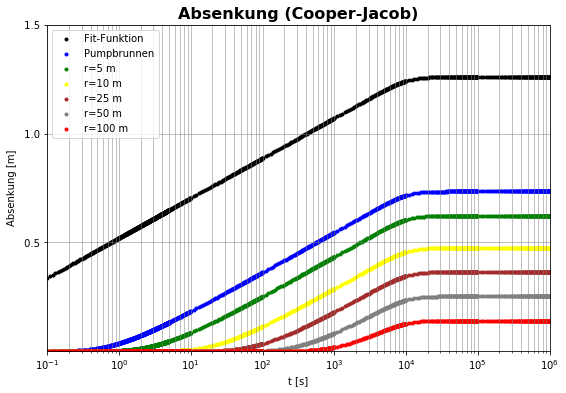

In [70]:
#Plot Function
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(time2, r_w,marker='.', color='black')
ax.scatter(time2, r_5,marker='.', color='blue')
ax.scatter(time2, r_10,marker='.', color='green')
ax.scatter(time2, r_25,marker='.', color='yellow')
ax.scatter(time2, r_50,marker='.', color='brown')
ax.scatter(time2, r_100,marker='.', color='grey')
ax.scatter(time2, r_200,marker='.', color='red')
3
plt.xscale("log")
plt.axis([1E-1,1E6,1E-3,1.5])
ax.set(xlabel='t [s]', ylabel='Absenkung [m]')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.1f'))
plt.title('Absenkung (Cooper-Jacob)',fontweight='bold', fontsize=16)
ax.grid(which="both", color='grey',linewidth=0.5)
plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
plt.show()

<font color=blue> <em>Aufgabe 4: Überlegen Sie: Was sagt uns das Cooper-Jacob Diagramm über den Verlauf des Pumpversuches? Wodurch könnte sich ein solches Bild ergeben?</font> </em>

Um diesen Datensatz im diagnostischen Plot zu betrachten, muss auch hier zunächst die zentrale Differenz berechnet werden:

In [72]:
#Berechnen der zentralen Differenz
t_diff = []

sw_diff = []
s5_diff = []
s10_diff = []
s25_diff = []
s50_diff = []
s100_diff = []
s200_diff = []

cw_diff = []
c5_diff = []
c10_diff = []
c25_diff = []
c50_diff = []
c100_diff = []
c200_diff = []
    
for x in range(len(time2)-1):
    if x>0:
        i = time2[x+1]-time2[x-1]
        t_diff.append(i)
for x in range(len(r_w)-1):
    if x>0:
        i = r_w[x+1]-r_w[x-1]
        sw_diff.append(i)
        j = r_5[x+1]-r_5[x-1]
        s5_diff.append(j)
        k = r_10[x+1]-r_10[x-1]
        s10_diff.append(k)
        l = r_25[x+1]-r_25[x-1]
        s25_diff.append(l)
        m = r_50[x+1]-r_50[x-1]
        s50_diff.append(m)
        n = r_100[x+1]-r_100[x-1]
        s100_diff.append(n)
        o = r_200[x+1]-r_200[x-1]
        s200_diff.append(o)
for x in range(len(t_diff)):
    i = sw_diff[x]/t_diff[x]
    j = s5_diff[x]/t_diff[x]
    k = s10_diff[x]/t_diff[x]
    l = s25_diff[x]/t_diff[x]
    m = s50_diff[x]/t_diff[x]
    n = s100_diff[x]/t_diff[x]
    o = s200_diff[x]/t_diff[x]
    cw_diff.append(i)
    c5_diff.append(j)
    c10_diff.append(k)
    c25_diff.append(l)
    c50_diff.append(m)
    c100_diff.append(n)
    c200_diff.append(o)

#new points in time:
t_av2= []
for x in range (len(cw_diff)):
    i = (time2[x+2]+time2[x])/2
    t_av2.append(i)
#central difference multiplied with new points in time:
bw_diff = []
b5_diff = []
b10_diff = []
b25_diff = []
b50_diff = []
b100_diff = []
b200_diff = []
for x in range(len(t_av2)):
    i = cw_diff[x]*t_av2[x]
    j = c5_diff[x]*t_av2[x]
    k = c10_diff[x]*t_av2[x]
    l = c25_diff[x]*t_av2[x]
    m = c50_diff[x]*t_av2[x]
    n = c100_diff[x]*t_av2[x]
    o = c200_diff[x]*t_av2[x]
    bw_diff.append(i)
    b5_diff.append(j)
    b10_diff.append(k)
    b25_diff.append(l)
    b50_diff.append(m)
    b100_diff.append(n)
    b200_diff.append(o)

print(len(t_av2))
print(len(b5_diff))

999
999


Auch diese Datensätze übertragen wir jetzt ins diagnostische Plot. Auch hier ergibt sich ein zunächst ungewohntes Bild.

In [65]:
#Plot Function
def splot(T, S, r, Q):
    tmax = 1000000
    r_max = 1000000
    s = [0 for x in range(r_max)]
    t = [1 for x in range(r_max)]
    
    for x in range(1,tmax,1):
        if x>0:
            s[x] = Q/(4*math.pi*T)*math.exp(-(S*r**2)/(4*T*x))
            t[x] = x
    #PLOT
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, s, 'red')
    ax.scatter(t_av2, bw_diff,marker='.', color='black')
    ax.scatter(t_av2, b5_diff,marker='.', color='blue')
    ax.scatter(t_av2, b10_diff,marker='.', color='green')
    ax.scatter(t_av2, b25_diff,marker='.', color='orange')
    ax.scatter(t_av2, b50_diff,marker='.', color='lime')
    ax.scatter(t_av2, b100_diff,marker='.', color='grey')
    ax.scatter(t_av2, b200_diff,marker='.', color='violet')
    3
    plt.yscale("log")
    plt.xscale("log")
    plt.axis([1E0,1E6,1E-3,1E0])
    ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot')
    plt.title('Auswertung mit diagnostischem Plot',fontweight='bold', fontsize=16)
    ax.grid(which="both", color='grey',linewidth=0.5)
    plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
    plt.show()
# Computation
interact(splot,
         r = widgets.FloatSlider(value=200, min=0, max=200, step=5, description='r [m]:', continuous_update=False, disabled=False, readout_format='.1d'),
         Q = widgets.FloatLogSlider(value=1E-3, base=10, min=-4, max=-1, step=0.001, description='Q [m³/s]:', continuous_update=False, readout_format='.0e'),
         T = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=2, step=0.1,readout=True,description='T [m²/s]:', continuous_update=False,readout_format='.1e'),
         S = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=0, step=0.1,readout=True,description='S [ - ]:', continuous_update=False,readout_format='.1e'))

interactive(children=(FloatLogSlider(value=0.0001, continuous_update=False, description='T [m²/s]:', max=2.0, …

<function __main__.splot(T, S, r, Q)>

<font color=blue> <em>Aufgabe 5: <br> a) Was sagt uns die Darstellung im diagnostischen Plot? Decken sich Ihre Vermutungen aus dem Cooper-Jacob Diagramm mit den Gedanken, die Ihnen bei Betrachtung des diagnostischen Plots in den Sinn kommen? <br>
    b) Lässt sich aus diesen Werten guten Gewissens eine Transmissivität und ein Speicherkoeffizient bestimmen? Wenn ja, mit welchen Einschränkungen wären diese Aussagen gültig? <br>
    c) Betrachten Sie die Abbildungen zu folgenden beiden Datensätzen. Worauf könnten die Abweichungen vom "lehrbuchmäßigen" Verlauf hier zurückzuführen sein?</font> </em>

## Pumpversuch 5-2

In [83]:
#Pumprate [m3/s]:
Q = 1E-3
# Zeit nach Pumpbeginn in Sekunden
time3 = [0.00E+00,1.00E-02,2.00E-02,3.00E-02,4.00E-02,5.00E-02,6.00E-02,7.00E-02,8.00E-02,9.00E-02,1.00E-01,1.10E-01,1.20E-01,1.30E-01,1.40E-01,1.50E-01,1.60E-01,1.70E-01,1.80E-01,1.90E-01,2.00E-01,2.10E-01,2.20E-01,2.30E-01,2.40E-01,2.50E-01,2.60E-01,2.70E-01,2.80E-01,2.90E-01,3.00E-01,3.10E-01,3.20E-01,3.30E-01,3.40E-01,3.50E-01,3.60E-01,3.70E-01,3.80E-01,3.90E-01,4.00E-01,4.10E-01,4.20E-01,4.30E-01,4.40E-01,4.50E-01,4.60E-01,4.70E-01,4.80E-01,4.90E-01,5.00E-01,5.10E-01,5.20E-01,5.30E-01,5.40E-01,5.50E-01,5.60E-01,5.70E-01,5.80E-01,5.90E-01,6.00E-01,6.10E-01,6.20E-01,6.30E-01,6.40E-01,6.50E-01,6.60E-01,6.70E-01,6.80E-01,6.90E-01,7.00E-01,7.10E-01,7.20E-01,7.30E-01,7.40E-01,7.50E-01,7.60E-01,7.70E-01,7.80E-01,7.90E-01,8.00E-01,8.10E-01,8.20E-01,8.30E-01,8.40E-01,8.50E-01,8.60E-01,8.70E-01,8.80E-01,8.90E-01,9.00E-01,9.10E-01,9.20E-01,9.30E-01,9.40E-01,9.50E-01,9.60E-01,9.70E-01,9.80E-01,9.90E-01,1.00E+00,1.01E+00,1.02E+00,1.03E+00,1.04E+00,1.05E+00,1.06E+00,1.07E+00,1.08E+00,1.09E+00,1.10E+00,1.11E+00,1.12E+00,1.13E+00,1.14E+00,1.15E+00,1.16E+00,1.17E+00,1.18E+00,1.19E+00,1.20E+00,1.21E+00,1.22E+00,1.23E+00,1.24E+00,1.25E+00,1.26E+00,1.27E+00,1.28E+00,1.29E+00,1.30E+00,1.31E+00,1.32E+00,1.33E+00,1.34E+00,1.35E+00,1.36E+00,1.37E+00,1.38E+00,1.39E+00,1.40E+00,1.41E+00,1.42E+00,1.43E+00,1.44E+00,1.45E+00,1.46E+00,1.47E+00,1.48E+00,1.49E+00,1.50E+00,1.51E+00,1.52E+00,1.53E+00,1.54E+00,1.55E+00,1.56E+00,1.57E+00,1.58E+00,1.59E+00,1.60E+00,1.61E+00,1.62E+00,1.63E+00,1.64E+00,1.65E+00,1.66E+00,1.67E+00,1.68E+00,1.69E+00,1.70E+00,1.71E+00,1.72E+00,1.73E+00,1.74E+00,1.75E+00,1.76E+00,1.77E+00,1.78E+00,1.79E+00,1.80E+00,1.81E+00,1.82E+00,1.83E+00,1.84E+00,1.85E+00,1.86E+00,1.87E+00,1.88E+00,1.89E+00,1.90E+00,1.91E+00,1.92E+00,1.93E+00,1.94E+00,1.95E+00,1.96E+00,1.97E+00,1.98E+00,1.99E+00,2.00E+00,2.01E+00,2.02E+00,2.03E+00,2.04E+00,2.05E+00,2.06E+00,2.07E+00,2.08E+00,2.09E+00,2.10E+00,2.11E+00,2.12E+00,2.13E+00,2.14E+00,2.15E+00,2.16E+00,2.17E+00,2.18E+00,2.19E+00,2.20E+00,2.21E+00,2.22E+00,2.23E+00,2.24E+00,2.25E+00,2.26E+00,2.27E+00,2.28E+00,2.29E+00,2.30E+00,2.31E+00,2.32E+00,2.33E+00,2.34E+00,2.35E+00,2.36E+00,2.37E+00,2.38E+00,2.39E+00,2.40E+00,2.41E+00,2.42E+00,2.43E+00,2.44E+00,2.45E+00,2.46E+00,2.47E+00,2.48E+00,2.49E+00,2.50E+00,2.51E+00,2.52E+00,2.53E+00,2.54E+00,2.55E+00,2.56E+00,2.57E+00,2.58E+00,2.59E+00,2.60E+00,2.61E+00,2.62E+00,2.63E+00,2.64E+00,2.65E+00,2.66E+00,2.67E+00,2.68E+00,2.69E+00,2.70E+00,2.71E+00,2.72E+00,2.73E+00,2.74E+00,2.75E+00,2.76E+00,2.77E+00,2.78E+00,2.79E+00,2.80E+00,2.81E+00,2.82E+00,2.83E+00,2.84E+00,2.85E+00,2.86E+00,2.87E+00,2.88E+00,2.89E+00,2.90E+00,2.91E+00,2.92E+00,2.93E+00,2.94E+00,2.95E+00,2.96E+00,2.97E+00,2.98E+00,2.99E+00,3.00E+00,3.01E+00,3.02E+00,3.03E+00,3.04E+00,3.05E+00,3.06E+00,3.07E+00,3.08E+00,3.09E+00,3.10E+00,3.11E+00,3.12E+00,3.13E+00,3.14E+00,3.15E+00,3.16E+00,3.17E+00,3.18E+00,3.19E+00,3.20E+00,3.21E+00,3.22E+00,3.23E+00,3.24E+00,3.25E+00,3.26E+00,3.27E+00,3.28E+00,3.29E+00,3.30E+00,3.31E+00,3.32E+00,3.33E+00,3.34E+00,3.35E+00,3.36E+00,3.37E+00,3.38E+00,3.39E+00,3.40E+00,3.41E+00,3.42E+00,3.43E+00,3.44E+00,3.45E+00,3.46E+00,3.47E+00,3.48E+00,3.49E+00,3.50E+00,3.51E+00,3.52E+00,3.53E+00,3.54E+00,3.55E+00,3.56E+00,3.57E+00,3.58E+00,3.59E+00,3.60E+00,3.61E+00,3.62E+00,3.63E+00,3.64E+00,3.65E+00,3.66E+00,3.67E+00,3.68E+00,3.69E+00,3.70E+00,3.71E+00,3.72E+00,3.73E+00,3.74E+00,3.75E+00,3.76E+00,3.77E+00,3.78E+00,3.79E+00,3.80E+00,3.81E+00,3.82E+00,3.83E+00,3.84E+00,3.85E+00,3.86E+00,3.87E+00,3.88E+00,3.89E+00,3.90E+00,3.91E+00,3.92E+00,3.93E+00,3.94E+00,3.95E+00,3.96E+00,3.97E+00,3.98E+00,3.99E+00,4.00E+00,4.01E+00,4.02E+00,4.03E+00,4.04E+00,4.05E+00,4.06E+00,4.07E+00,4.08E+00,4.09E+00,4.10E+00,4.11E+00,4.12E+00,4.13E+00,4.14E+00,4.15E+00,4.16E+00,4.17E+00,4.18E+00,4.19E+00,4.20E+00,4.21E+00,4.22E+00,4.23E+00,4.24E+00,4.25E+00,4.26E+00,4.27E+00,4.28E+00,4.29E+00,4.30E+00,4.31E+00,4.32E+00,4.33E+00,4.34E+00,4.35E+00,4.36E+00,4.37E+00,4.38E+00,4.39E+00,4.40E+00,4.41E+00,4.42E+00,4.43E+00,4.44E+00,4.45E+00,4.46E+00,4.47E+00,4.48E+00,4.49E+00,4.50E+00,4.51E+00,4.52E+00,4.53E+00,4.54E+00,4.55E+00,4.56E+00,4.57E+00,4.58E+00,4.59E+00,4.60E+00,4.61E+00,4.62E+00,4.63E+00,4.64E+00,4.65E+00,4.66E+00,4.67E+00,4.68E+00,4.69E+00,4.70E+00,4.71E+00,4.72E+00,4.73E+00,4.74E+00,4.75E+00,4.76E+00,4.77E+00,4.78E+00,4.79E+00,4.80E+00,4.81E+00,4.82E+00,4.83E+00,4.84E+00,4.85E+00,4.86E+00,4.87E+00,4.88E+00,4.89E+00,4.90E+00,4.91E+00,4.92E+00,4.93E+00,4.94E+00,4.95E+00,4.96E+00,4.97E+00,4.98E+00,4.99E+00,5.00E+00,5.10E+00,5.20E+00,5.30E+00,5.40E+00,5.50E+00,5.60E+00,5.70E+00,5.80E+00,5.90E+00,6.00E+00,6.10E+00,6.20E+00,6.30E+00,6.40E+00,6.50E+00,6.60E+00,6.70E+00,6.80E+00,6.90E+00,7.00E+00,7.10E+00,7.20E+00,7.30E+00,7.40E+00,7.50E+00,7.60E+00,7.70E+00,7.80E+00,7.90E+00,8.00E+00,8.10E+00,8.20E+00,8.30E+00,8.40E+00,8.50E+00,8.60E+00,8.70E+00,8.80E+00,8.90E+00,9.00E+00,9.10E+00,9.20E+00,9.30E+00,9.40E+00,9.50E+00,9.60E+00,9.70E+00,9.80E+00,9.90E+00,1.00E+01,1.10E+01,1.20E+01,1.30E+01,1.40E+01,1.50E+01,1.60E+01,1.70E+01,1.80E+01,1.90E+01,2.00E+01,2.10E+01,2.20E+01,2.30E+01,2.40E+01,2.50E+01,2.60E+01,2.70E+01,2.80E+01,2.90E+01,3.00E+01,3.10E+01,3.20E+01,3.30E+01,3.40E+01,3.50E+01,3.60E+01,3.70E+01,3.80E+01,3.90E+01,4.00E+01,4.10E+01,4.20E+01,4.30E+01,4.40E+01,4.50E+01,4.60E+01,4.70E+01,4.80E+01,4.90E+01,5.00E+01,5.10E+01,5.20E+01,5.30E+01,5.40E+01,5.50E+01,5.60E+01,5.70E+01,5.80E+01,5.90E+01,6.00E+01,6.10E+01,6.20E+01,6.30E+01,6.40E+01,6.50E+01,6.60E+01,6.70E+01,6.80E+01,6.90E+01,7.00E+01,7.10E+01,7.20E+01,7.30E+01,7.40E+01,7.50E+01,7.60E+01,7.70E+01,7.80E+01,7.90E+01,8.00E+01,8.10E+01,8.20E+01,8.30E+01,8.40E+01,8.50E+01,8.60E+01,8.70E+01,8.80E+01,8.90E+01,9.00E+01,9.10E+01,9.20E+01,9.30E+01,9.40E+01,9.50E+01,9.60E+01,9.70E+01,9.80E+01,9.90E+01,1.00E+02,1.10E+02,1.20E+02,1.30E+02,1.40E+02,1.50E+02,1.60E+02,1.70E+02,1.80E+02,1.90E+02,2.00E+02,2.10E+02,2.20E+02,2.30E+02,2.40E+02,2.50E+02,2.60E+02,2.70E+02,2.80E+02,2.90E+02,3.00E+02,3.10E+02,3.20E+02,3.30E+02,3.40E+02,3.50E+02,3.60E+02,3.70E+02,3.80E+02,3.90E+02,4.00E+02,4.10E+02,4.20E+02,4.30E+02,4.40E+02,4.50E+02,4.60E+02,4.70E+02,4.80E+02,4.90E+02,5.00E+02,5.10E+02,5.20E+02,5.30E+02,5.40E+02,5.50E+02,5.60E+02,5.70E+02,5.80E+02,5.90E+02,6.00E+02,6.10E+02,6.20E+02,6.30E+02,6.40E+02,6.50E+02,6.60E+02,6.70E+02,6.80E+02,6.90E+02,7.00E+02,7.10E+02,7.20E+02,7.30E+02,7.40E+02,7.50E+02,7.60E+02,7.70E+02,7.80E+02,7.90E+02,8.00E+02,8.10E+02,8.20E+02,8.30E+02,8.40E+02,8.50E+02,8.60E+02,8.70E+02,8.80E+02,8.90E+02,9.00E+02,9.10E+02,9.20E+02,9.30E+02,9.40E+02,9.50E+02,9.60E+02,9.70E+02,9.80E+02,9.90E+02,1.00E+03,1.10E+03,1.20E+03,1.30E+03,1.40E+03,1.50E+03,1.60E+03,1.70E+03,1.80E+03,1.90E+03,2.00E+03,2.10E+03,2.20E+03,2.30E+03,2.40E+03,2.50E+03,2.60E+03,2.70E+03,2.80E+03,2.90E+03,3.00E+03,3.10E+03,3.20E+03,3.30E+03,3.40E+03,3.50E+03,3.60E+03,3.70E+03,3.80E+03,3.90E+03,4.00E+03,4.10E+03,4.20E+03,4.30E+03,4.40E+03,4.50E+03,4.60E+03,4.70E+03,4.80E+03,4.90E+03,5.00E+03,5.10E+03,5.20E+03,5.30E+03,5.40E+03,5.50E+03,5.60E+03,5.70E+03,5.80E+03,5.90E+03,6.00E+03,6.10E+03,6.20E+03,6.30E+03,6.40E+03,6.50E+03,6.60E+03,6.70E+03,6.80E+03,6.90E+03,7.00E+03,7.10E+03,7.20E+03,7.30E+03,7.40E+03,7.50E+03,7.60E+03,7.70E+03,7.80E+03,7.90E+03,8.00E+03,8.10E+03,8.20E+03,8.30E+03,8.40E+03,8.50E+03,8.60E+03,8.70E+03,8.80E+03,8.90E+03,9.00E+03,9.10E+03,9.20E+03,9.30E+03,9.40E+03,9.50E+03,9.60E+03,9.70E+03,9.80E+03,9.90E+03,1.00E+04,1.10E+04,1.20E+04,1.30E+04,1.40E+04,1.50E+04,1.60E+04,1.70E+04,1.80E+04,1.90E+04,2.00E+04,2.10E+04,2.20E+04,2.30E+04,2.40E+04,2.50E+04,2.60E+04,2.70E+04,2.80E+04,2.90E+04,3.00E+04,3.10E+04,3.20E+04,3.30E+04,3.40E+04,3.50E+04,3.60E+04,3.70E+04,3.80E+04,3.90E+04,4.00E+04,4.10E+04,4.20E+04,4.30E+04,4.40E+04,4.50E+04,4.60E+04,4.70E+04,4.80E+04,4.90E+04,5.00E+04,5.10E+04,5.20E+04,5.30E+04,5.40E+04,5.50E+04,5.60E+04,5.70E+04,5.80E+04,5.90E+04,6.00E+04,6.10E+04,6.20E+04,6.30E+04,6.40E+04,6.50E+04,6.60E+04,6.70E+04,6.80E+04,6.90E+04,7.00E+04,7.10E+04,7.20E+04,7.30E+04,7.40E+04,7.50E+04,7.60E+04,7.70E+04,7.80E+04,7.90E+04,8.00E+04,8.10E+04,8.20E+04,8.30E+04,8.40E+04,8.50E+04,8.60E+04,8.70E+04,8.80E+04,8.90E+04,9.00E+04,9.10E+04,9.20E+04,9.30E+04,9.40E+04,9.50E+04,9.60E+04,9.70E+04,9.80E+04,9.90E+04,1.00E+05,1.10E+05,1.20E+05,1.30E+05,1.40E+05,1.50E+05,1.60E+05,1.70E+05,1.80E+05,1.90E+05,2.00E+05,2.10E+05,2.20E+05,2.30E+05,2.40E+05,2.50E+05,2.60E+05,2.70E+05,2.80E+05,2.90E+05,3.00E+05,3.10E+05,3.20E+05,3.30E+05,3.40E+05,3.50E+05,3.60E+05,3.70E+05,3.80E+05,3.90E+05,4.00E+05,4.10E+05,4.20E+05,4.30E+05,4.40E+05,4.50E+05,4.60E+05,4.70E+05,4.80E+05,4.90E+05,5.00E+05,5.10E+05,5.20E+05,5.30E+05,5.40E+05,5.50E+05,5.60E+05,5.70E+05,5.80E+05,5.90E+05,6.00E+05,6.10E+05,6.20E+05,6.30E+05,6.40E+05,6.50E+05,6.60E+05,6.70E+05,6.80E+05,6.90E+05,7.00E+05,7.10E+05,7.20E+05,7.30E+05,7.40E+05,7.50E+05,7.60E+05,7.70E+05,7.80E+05,7.90E+05,8.00E+05,8.10E+05,8.20E+05,8.30E+05,8.40E+05,8.50E+05,8.60E+05,8.70E+05,8.80E+05,8.90E+05,9.00E+05,9.10E+05,9.20E+05,9.30E+05,9.40E+05,9.50E+05,9.60E+05,9.70E+05,9.80E+05,9.90E+05,1.00E+06]
#Wasserstände im Pumpbrunnen (Radius: 0.1 m) und in den Beobachtungsstellen (Entfernung zum Pumpbrunnen: 5, 10, 25, 50, 100, 200 m)
r_w3 = [0,0.131513596,0.197067261,0.235728264,0.261796951,0.281135559,0.296448708,0.309130669,0.319969177,0.329446793,0.337877274,0.345476151,0.352397919,0.358756065,0.364636421,0.370108604,0.375225067,0.380030632,0.384560585,0.38884449,0.39290905,0.396775246,0.400461197,0.40398407,0.407356262,0.410591125,0.41369915,0.416690826,0.41957283,0.422354698,0.425042152,0.427641869,0.430158615,0.432598114,0.434965134,0.437264442,0.439497948,0.441670418,0.443785667,0.445845604,0.447854042,0.449812889,0.451724052,0.453591347,0.455414772,0.457198143,0.45894146,0.460647583,0.46231842,0.463954926,0.465558052,0.467129707,0.468670845,0.470182419,0.471666336,0.473122597,0.474553108,0.47595787,0.477337837,0.478694916,0.480029106,0.481342316,0.482632637,0.483902931,0.485154152,0.486384392,0.487596512,0.488790512,0.489967346,0.491127014,0.492269516,0.493396759,0.494506836,0.495602608,0.496683121,0.497749329,0.498802185,0.499840736,0.500864983,0.501876831,0.502876282,0.503863335,0.50483799,0.505801201,0.506752968,0.507693291,0.508623123,0.509541512,0.510449409,0.511347771,0.512235641,0.513113976,0.513982773,0.514842033,0.515691757,0.516532898,0.517365456,0.518188477,0.519004822,0.51981163,0.520610809,0.521402359,0.522185326,0.522960663,0.523729324,0.524490356,0.525243759,0.525990486,0.526730537,0.527462959,0.528189659,0.528909683,0.529623032,0.530329704,0.531030655,0.531725883,0.532414436,0.533097267,0.533774376,0.534445763,0.535111427,0.53577137,0.536426544,0.53707695,0.53772068,0.538359642,0.538993835,0.53962326,0.540246964,0.540866852,0.541481018,0.54209137,0.542696953,0.543297768,0.543893814,0.544486046,0.545073509,0.545656204,0.546235085,0.54681015,0.547381401,0.547947884,0.548510551,0.549069405,0.549624443,0.550175667,0.550723076,0.55126667,0.551807404,0.552343369,0.552876472,0.553405762,0.55393219,0.55445385,0.554973602,0.555488586,0.556001663,0.556510925,0.557017326,0.557519913,0.558019638,0.558515549,0.559008598,0.559499741,0.559987068,0.560471535,0.56095314,0.561432838,0.561908722,0.562381744,0.562851906,0.563319206,0.563784599,0.564246178,0.564705849,0.565162659,0.565617561,0.566069603,0.566518784,0.566965103,0.567409515,0.567851067,0.56829071,0.568728447,0.569162369,0.569595337,0.570025444,0.57045269,0.570878029,0.57130146,0.571722984,0.572141647,0.572558403,0.572972298,0.573385239,0.573795319,0.574203491,0.574609756,0.575013161,0.575415611,0.575815201,0.576213837,0.576609612,0.577004433,0.577396393,0.577787399,0.578175545,0.578562737,0.578947067,0.579330444,0.57971096,0.580090523,0.580468178,0.580843925,0.581217766,0.581589699,0.581960678,0.58232975,0.582696915,0.583062172,0.583426476,0.583788872,0.584149361,0.584507942,0.58486557,0.585221291,0.585576057,0.585928917,0.586279869,0.586628914,0.586977959,0.587324142,0.587669373,0.588013649,0.588355064,0.58869648,0.589035988,0.589373589,0.589710236,0.590044975,0.590378761,0.590711594,0.591042519,0.591371536,0.5916996,0.592026711,0.592352867,0.592677116,0.592999458,0.5933218,0.593642235,0.593961716,0.594279289,0.594595909,0.594911575,0.595225334,0.595539093,0.595849991,0.596160889,0.596469879,0.59677887,0.597085953,0.597391129,0.597696304,0.597999573,0.598301888,0.598603249,0.598903656,0.599202156,0.599500656,0.599797249,0.600092888,0.600387573,0.600681305,0.600974083,0.601265907,0.601555824,0.601845741,0.602133751,0.602420807,0.602707863,0.602993011,0.603277206,0.603560448,0.603842735,0.604124069,0.604404449,0.604683876,0.604962349,0.605239868,0.605516434,0.605792046,0.606066704,0.606340408,0.606613159,0.606884956,0.6071558,0.607426643,0.60769558,0.607963562,0.608231544,0.60849762,0.608763695,0.609027863,0.60929203,0.609555244,0.609817505,0.610078812,0.610339165,0.610598564,0.610857964,0.611115456,0.611372948,0.611628532,0.611884117,0.612139702,0.612393379,0.612646103,0.612898827,0.613150597,0.613400459,0.613651276,0.613900185,0.61414814,0.614396095,0.614643097,0.614889145,0.615134239,0.615379333,0.615623474,0.615866661,0.616108894,0.616350174,0.616591454,0.616831779,0.617071152,0.617310524,0.617547989,0.617785454,0.618022919,0.618258476,0.618494034,0.618728638,0.618962288,0.619195938,0.619428635,0.619660378,0.61989212,0.620121956,0.620352745,0.620581627,0.620810509,0.621038437,0.621265411,0.621492386,0.621718407,0.621943474,0.622168541,0.622393608,0.622616768,0.622839928,0.623062134,0.62328434,0.623504639,0.623724937,0.623945236,0.624164581,0.624382973,0.624601364,0.624818802,0.62503624,0.625252724,0.625468254,0.625682831,0.625898361,0.626111984,0.626325607,0.626538277,0.626750946,0.626962662,0.627174377,0.627384186,0.627594948,0.627804756,0.628013611,0.628221512,0.628429413,0.628637314,0.628844261,0.629050255,0.629256248,0.629461288,0.629666328,0.629870415,0.630074501,0.630277634,0.630480766,0.630682945,0.630884171,0.631085396,0.631286621,0.631486893,0.631686211,0.631885529,0.632083893,0.632282257,0.632480621,0.632677078,0.632874489,0.633069992,0.633266449,0.633460999,0.633656502,0.633851051,0.634044647,0.634238243,0.634430885,0.634623528,0.63481617,0.635007858,0.635198593,0.635389328,0.635580063,0.635769844,0.635958672,0.636147499,0.636336327,0.6365242,0.636712074,0.636898994,0.637085915,0.637271881,0.637457848,0.637643814,0.637828827,0.638012886,0.638196945,0.638381004,0.63856411,0.638747215,0.638929367,0.639111519,0.639293671,0.639474869,0.639655113,0.639836311,0.640015602,0.640195847,0.640374184,0.640553474,0.640731812,0.640910149,0.641087532,0.641264915,0.641441345,0.641617775,0.641794205,0.641969681,0.642145157,0.642319679,0.642494202,0.642668724,0.642842293,0.643015862,0.643188477,0.643361092,0.643533707,0.643705368,0.643877029,0.644048691,0.644219398,0.644389153,0.64455986,0.644729614,0.644898415,0.645067215,0.645236015,0.645404816,0.645572662,0.645740509,0.645907402,0.646074295,0.646241188,0.646407127,0.646573067,0.646739006,0.646903992,0.647068977,0.647233009,0.647397041,0.647561073,0.647725105,0.647888184,0.648051262,0.648213387,0.648375511,0.648536682,0.648698807,0.648859978,0.649021149,0.64918232,0.650756836,0.652300835,0.653817177,0.655305862,0.656766891,0.658203125,0.659613609,0.661000252,0.662363052,0.663703918,0.66502285,0.666319847,0.667596817,0.66885376,0.670091629,0.671310425,0.672511101,0.673694611,0.674860001,0.676010132,0.677143097,0.678260803,0.679362297,0.680449486,0.681522369,0.682580948,0.683625221,0.684656143,0.685674667,0.68667984,0.687672615,0.688652992,0.689621925,0.690579414,0.691524506,0.692459106,0.693383217,0.694296837,0.695199966,0.696092606,0.696975708,0.697849274,0.698713303,0.699567795,0.70041275,0.701250076,0.702077866,0.702898026,0.703708649,0.704511642,0.711853981,0.718610764,0.724865913,0.73068428,0.736122131,0.741223335,0.746026993,0.750563622,0.754860878,0.758943558,0.762830734,0.766539574,0.770086288,0.773483276,0.776750565,0.779878616,0.782904625,0.785805702,0.788620949,0.791326523,0.793955803,0.796490669,0.798958778,0.801342964,0.803667068,0.805916786,0.808114052,0.810243607,0.812326431,0.814349175,0.816329002,0.818253517,0.820139885,0.821976662,0.823778152,0.825533867,0.827257156,0.828939438,0.830592155,0.832205772,0.833792686,0.835344315,0.836870193,0.838363647,0.839834213,0.841273308,0.842691422,0.844080925,0.845450401,0.846793175,0.848117828,0.849416733,0.850698471,0.851956367,0.853198051,0.854417801,0.855622292,0.856805801,0.857975006,0.859125137,0.860260963,0.86137867,0.862483025,0.863570213,0.864645004,0.865702629,0.866749763,0.867780685,0.868801117,0.86980629,0.870800018,0.871780396,0.872751236,0.873707771,0.874655724,0.875590324,0.876515388,0.877429008,0.878333092,0.879226685,0.880110741,0.880984306,0.881849289,0.882704735,0.883551598,0.88438797,0.885217667,0.886036873,0.886850357,0.887653351,0.895002365,0.901783943,0.908041954,0.913890839,0.919335365,0.924466133,0.929279327,0.933843613,0.938153267,0.942263603,0.946164131,0.949890137,0.953467369,0.956882477,0.960173607,0.963372231,0.966389656,0.969311714,0.972145081,0.974895477,0.977523804,0.980075836,0.982561111,0.984983444,0.987286568,0.98957634,0.991798401,0.9939394,0.996021271,0.998066902,1.000062943,1.00198555,1.003892899,1.005759239,1.007544518,1.009324074,1.011071205,1.012742996,1.014410973,1.016052246,1.017623901,1.019193649,1.020740509,1.022222519,1.023715973,1.025150299,1.026589394,1.027975082,1.029364586,1.030703545,1.032046318,1.033342361,1.034640312,1.035895348,1.037153244,1.038370132,1.039588928,1.040769577,1.041952133,1.043099403,1.044248581,1.045362473,1.046480179,1.047563553,1.048650742,1.049706459,1.050764084,1.051792145,1.052823067,1.053825378,1.054830551,1.055808067,1.056788445,1.057743073,1.058699608,1.059632301,1.060566902,1.061477661,1.062390327,1.063281059,1.064174652,1.065045357,1.065918922,1.066771507,1.067625999,1.068460464,1.069297791,1.070116043,1.070935249,1.071736336,1.079128265,1.085913658,1.092216492,1.098061562,1.103541374,1.108670235,1.113505363,1.118097305,1.122416496,1.126519203,1.13047123,1.13421154,1.137812614,1.14125824,1.144573212,1.147755623,1.150827408,1.153776169,1.15663147,1.159379005,1.162047386,1.164621353,1.167126656,1.169549942,1.17191124,1.174201012,1.176435471,1.178606987,1.180728912,1.182794571,1.184815407,1.186786652,1.188717842,1.190603256,1.192453384,1.194268227,1.196042061,1.197790146,1.199492455,1.201174736,1.202824593,1.204451561,1.206048965,1.207622528,1.209176064,1.210697174,1.212203026,1.213683128,1.215147972,1.216588974,1.218015671,1.21942234,1.220812798,1.22218895,1.22355175,1.224895477,1.226225853,1.227545738,1.228850365,1.230145454,1.231426239,1.232697487,1.233956337,1.235206604,1.236444473,1.237674713,1.238894463,1.240106583,1.24131012,1.242506027,1.243693352,1.244874954,1.246047974,1.247215271,1.248374939,1.249529839,1.250677109,1.251820564,1.25295639,1.254088402,1.255214691,1.256336212,1.257452965,1.258565903,1.259674072,1.260777473,1.261878014,1.262974739,1.264065742,1.265155792,1.275794029,1.286282539,1.296674728,1.306905746,1.317079544,1.327188492,1.337270737,1.347325325,1.357364655,1.367395401,1.377412796,1.387432098,1.397438049,1.407452583,1.417455673,1.427465439,1.437466621,1.447473526,1.457471848,1.467476845,1.477480888,1.487480164,1.497481346,1.507484436,1.517482758,1.527488709,1.537485123,1.547487259,1.557483673,1.567492485,1.577487946,1.587491989,1.597492218,1.607489586,1.617491722,1.627492905,1.637493134,1.647493362,1.657492638,1.66749382,1.677492142,1.687495232,1.697490692,1.707496643,1.717492104,1.727495193,1.737495422,1.747496605,1.757493973,1.767495155,1.777494431,1.78749752,1.797494888,1.807498932,1.817493439,1.827498436,1.837493896,1.847495079,1.857493401,1.86749649,1.877494812,1.887498856,1.897494316,1.907494545,1.917494774,1.927497864,1.937494278,1.947497368,1.957493782,1.967495918,1.977493286,1.987499237,1.997493744,2.007498264,2.017494202,2.027495384,2.037494183,2.047496796,2.057495117,2.067497253,2.077492714,2.087496281,2.097492695,2.107496738,2.117493629,2.127499104,2.13749361,2.147498131,2.157493114,2.167495251,2.267498016,2.367497444,2.467499733,2.567499161,2.667500973,2.767496109,2.867491722,2.967498302,3.067485332,3.167503357,3.267468929,3.367520809,3.467496872,3.567496777,3.667498589,3.767493248,3.867493153,3.967507362,4.067489624,4.167516232,4.267492294,4.367496967,4.467484474,4.567492962,4.66749239,4.767500877,4.867493153,4.967494965,5.067490101,5.167497635,5.26748848,5.367501259,5.467479706,5.567490101,5.667497158,5.767486095,5.867501259,5.967481613,6.067515373,6.167491913,6.267498016,6.367484093,6.467503071,6.567467213,6.66749382,6.767484665,6.867494583,6.967482567,7.067495823,7.167482376,7.267493248,7.367485046,7.467494011,7.567475319,7.667502403,7.767486572,7.867489815,7.967487812,8.06748867,8.167484283,8.267481804,8.367490768,8.46749115,8.567487717,8.667480469,8.767496109,8.867490768,8.967480659,9.067492485,9.167476654,9.267479897,9.367490768,9.467479706,9.567492485,9.667489052,9.767476082,9.867502213,9.967461586,10.06748295,10.16748619,10.2674818,10.36748791,10.4674778,10.56748581,10.66747856,10.76748371,10.86747742,10.96748734,11.06748581,11.16747856]
r_53 = [0,0,9.53674E-07,2.86102E-06,7.62939E-06,1.62125E-05,3.14713E-05,5.34058E-05,8.58307E-05,0.000127792,0.000184059,0.000253677,0.000338554,0.00043869,0.000555992,0.00069046,0.000843048,0.001012802,0.001199722,0.001404762,0.001626015,0.001864433,0.002119064,0.002388954,0.002674103,0.002973557,0.003286362,0.003612518,0.003950119,0.004300117,0.00466156,0.005032539,0.005414009,0.005804062,0.006202698,0.006609917,0.007024765,0.007445335,0.007873535,0.008307457,0.008747101,0.009190559,0.00963974,0.010093689,0.010550499,0.011011124,0.011475563,0.011942863,0.012412071,0.01288414,0.013358116,0.013834,0.01431179,0.014790535,0.015271187,0.015751839,0.016234398,0.016716957,0.01720047,0.017683029,0.018167496,0.018651009,0.019134521,0.019618034,0.020101547,0.020584106,0.021066666,0.021548271,0.022028923,0.022509575,0.022989273,0.023467064,0.023944855,0.024421692,0.024896622,0.025371552,0.025844574,0.026315689,0.026786804,0.027256012,0.027724266,0.028190613,0.028656006,0.029119492,0.02958107,0.030041695,0.030501366,0.030959129,0.031414986,0.031869888,0.032322884,0.032773972,0.033224106,0.033671379,0.034118652,0.034563065,0.035005569,0.035447121,0.035886765,0.036325455,0.036761284,0.037196159,0.037629128,0.038060188,0.038490295,0.038917542,0.039343834,0.039768219,0.04019165,0.040612221,0.041031837,0.041449547,0.041865349,0.042280197,0.042693138,0.043104172,0.043513298,0.043920517,0.044326782,0.04473114,0.045133591,0.045534134,0.045933723,0.046332359,0.046728134,0.047122955,0.047515869,0.047906876,0.048296928,0.048685074,0.049072266,0.04945755,0.049840927,0.050222397,0.050602913,0.050981522,0.051359177,0.051734924,0.052109718,0.052482605,0.052853584,0.05322361,0.053591728,0.053958893,0.054325104,0.054688454,0.05505085,0.055412292,0.055771828,0.056130409,0.056487083,0.056842804,0.057196617,0.057549477,0.057900429,0.058250427,0.058599472,0.058946609,0.05929184,0.05963707,0.059980392,0.060321808,0.06066227,0.061001778,0.061339378,0.061676025,0.062011719,0.062345505,0.062678337,0.063010216,0.063341141,0.063670158,0.063998222,0.064324379,0.064650536,0.064974785,0.06529808,0.065619469,0.065940857,0.066260338,0.066578865,0.066896439,0.067212105,0.067526817,0.067840576,0.068153381,0.068465233,0.068775177,0.069085121,0.069393158,0.069700241,0.070005417,0.070310593,0.070614815,0.07091713,0.071219444,0.071519852,0.071819305,0.072117805,0.072415352,0.072711945,0.073007584,0.073302269,0.073596001,0.073887825,0.074179649,0.074469566,0.074759483,0.075047493,0.075335503,0.075621605,0.075907707,0.076191902,0.076476097,0.076759338,0.077040672,0.077322006,0.077601433,0.077880859,0.078158379,0.078435898,0.078712463,0.078987122,0.07926178,0.079535484,0.079808235,0.080080032,0.080350876,0.080621719,0.080890656,0.081159592,0.08142662,0.081693649,0.081958771,0.082223892,0.08248806,0.082751274,0.083013535,0.083275795,0.083536148,0.083796501,0.084055901,0.0843153,0.084572792,0.08482933,0.085085869,0.085341454,0.085596085,0.085849762,0.086102486,0.086355209,0.086606026,0.086856842,0.087106705,0.087356567,0.087604523,0.087852478,0.08809948,0.088346481,0.088591576,0.08883667,0.089080811,0.089323997,0.089567184,0.089809418,0.090050697,0.090291023,0.090531349,0.090770721,0.09100914,0.091246605,0.09148407,0.091720581,0.091956139,0.092191696,0.0924263,0.09265995,0.0928936,0.093126297,0.09335804,0.093588829,0.093819618,0.094049454,0.094278336,0.094507217,0.094735146,0.094963074,0.095190048,0.095416069,0.095641136,0.095866203,0.09609127,0.09631443,0.09653759,0.09676075,0.096982002,0.097204208,0.097424507,0.097644806,0.097864151,0.098083496,0.098301888,0.098519325,0.098736763,0.098954201,0.099169731,0.099385262,0.099600792,0.099815369,0.100028992,0.100242615,0.100455284,0.100667,0.100878716,0.101090431,0.101301193,0.101511002,0.10172081,0.101929665,0.102137566,0.102345467,0.102553368,0.102760315,0.102966309,0.103172302,0.103377342,0.103582382,0.103786469,0.103990555,0.104193687,0.10439682,0.104598999,0.104801178,0.105002403,0.105202675,0.105402946,0.105603218,0.105802536,0.1060009,0.106200218,0.106397629,0.106595039,0.10679245,0.106988907,0.107185364,0.107380867,0.107575417,0.107769966,0.107964516,0.108158112,0.108350754,0.108543396,0.108736038,0.108927727,0.109119415,0.10931015,0.109500885,0.10969162,0.109881401,0.110070229,0.110259056,0.110447884,0.110634804,0.110822678,0.111009598,0.111196518,0.111382484,0.111568451,0.111753464,0.111938477,0.112123489,0.112307549,0.112490654,0.112674713,0.112857819,0.11303997,0.113222122,0.113404274,0.113585472,0.113765717,0.113945961,0.114126205,0.114305496,0.114484787,0.114664078,0.114842415,0.115020752,0.115198135,0.115375519,0.115551949,0.115729332,0.115904808,0.116081238,0.116256714,0.116431236,0.116605759,0.116780281,0.11695385,0.117127419,0.117300987,0.117473602,0.117646217,0.117817879,0.11798954,0.118161201,0.118331909,0.118502617,0.118673325,0.118843079,0.119011879,0.119181633,0.119350433,0.11951828,0.11968708,0.119853973,0.12002182,0.120188713,0.120355606,0.120522499,0.120688438,0.120853424,0.121019363,0.121184349,0.121348381,0.121513367,0.121677399,0.121840477,0.122004509,0.122167587,0.122329712,0.122491837,0.122653961,0.122816086,0.122977257,0.123138428,0.123299599,0.123459816,0.123620033,0.123780251,0.123939514,0.124098778,0.124258041,0.124416351,0.124574661,0.124732018,0.124889374,0.125047684,0.125204086,0.125361443,0.125517845,0.125674248,0.125829697,0.125985146,0.126140594,0.12629509,0.126450539,0.126605034,0.126758575,0.126912117,0.127065659,0.1272192,0.127371788,0.127524376,0.127676964,0.127828598,0.127980232,0.128131866,0.128283501,0.128434181,0.128584862,0.128735542,0.128885269,0.129034996,0.129184723,0.129333496,0.129482269,0.129631042,0.129779816,0.129927635,0.130075455,0.130223274,0.13037014,0.130517006,0.130663872,0.130810738,0.13095665,0.131102562,0.131248474,0.131393433,0.131538391,0.13168335,0.131828308,0.131972313,0.132117271,0.132261276,0.132404327,0.132548332,0.132691383,0.132833481,0.132976532,0.133119583,0.134518623,0.135894775,0.137248039,0.138578415,0.139888763,0.141177177,0.142446518,0.143695831,0.144926071,0.146138191,0.147332191,0.148509026,0.149668694,0.150812149,0.151939392,0.153051376,0.154148102,0.155230522,0.156298637,0.157352448,0.158391953,0.15941906,0.160433769,0.161435127,0.162424088,0.16340065,0.164365768,0.165319443,0.166262627,0.167194366,0.168114662,0.169025421,0.16992569,0.170816422,0.171696663,0.172567368,0.173428535,0.17428112,0.175125122,0.175959587,0.176785469,0.177602768,0.178411484,0.17921257,0.180006027,0.180791855,0.181569099,0.182338715,0.183101654,0.183857918,0.19080162,0.197218895,0.203181267,0.208745956,0.213959694,0.218863487,0.223491669,0.227871895,0.232028961,0.235984802,0.239756584,0.243360519,0.246810913,0.250120163,0.253300667,0.256362915,0.259309769,0.262156487,0.264902115,0.267560959,0.270130157,0.272623062,0.275038719,0.277385712,0.279663086,0.281880379,0.284035683,0.286136627,0.288181305,0.290177345,0.292123795,0.294024467,0.295880318,0.29769516,0.29946804,0.301204681,0.302902222,0.304566383,0.306195259,0.307792664,0.309357643,0.310894012,0.312399864,0.313879013,0.315330505,0.316757202,0.318157196,0.319535255,0.320887566,0.322219849,0.32352829,0.324816704,0.326084137,0.327332497,0.328560829,0.329771042,0.330963135,0.332138062,0.333294868,0.334436417,0.335561752,0.336670876,0.33776474,0.338844299,0.339909554,0.340960503,0.3419981,0.343022346,0.344033241,0.345031738,0.346017838,0.346992493,0.34795475,0.348905563,0.349845886,0.350774765,0.351693153,0.352601051,0.353498459,0.35438633,0.35526371,0.356132507,0.356991768,0.357841492,0.358682632,0.35951519,0.360338211,0.361153603,0.361960411,0.36275959,0.370073318,0.376806259,0.383049965,0.388858795,0.394294739,0.399393082,0.4041996,0.40873909,0.41304493,0.417133331,0.421030045,0.424757004,0.428312302,0.43173027,0.435002327,0.438169479,0.441198349,0.444139481,0.446947098,0.449681282,0.452309608,0.454877853,0.457343102,0.459749222,0.462085724,0.464343071,0.466556549,0.468695641,0.47079277,0.472819328,0.474811554,0.476746559,0.478639603,0.48048687,0.48229599,0.484065056,0.485790253,0.487483978,0.489145279,0.490765572,0.492357254,0.49392128,0.495448112,0.496949196,0.49842453,0.499875069,0.501296997,0.502696991,0.504069328,0.505421638,0.506748199,0.508056641,0.509340286,0.510606766,0.511850357,0.51307869,0.514284134,0.515475273,0.516646385,0.517803192,0.518939972,0.520064354,0.521169662,0.522263527,0.523339272,0.524403572,0.525450706,0.52648735,0.527508736,0.528518677,0.529514313,0.530499458,0.531471252,0.532432556,0.533381462,0.534320831,0.535246849,0.536164284,0.537069321,0.537966728,0.538851738,0.539729118,0.540596008,0.541454315,0.542302132,0.543142319,0.543972969,0.54479599,0.545609474,0.546416283,0.553801537,0.560572624,0.566878319,0.572716713,0.578198433,0.583347321,0.588167191,0.592741013,0.59707737,0.601185799,0.60513401,0.608859062,0.61246109,0.615903854,0.619229317,0.622400284,0.625484467,0.62842083,0.631285667,0.634023666,0.636701584,0.639266014,0.6417799,0.644192696,0.64656353,0.648843765,0.651086807,0.653248787,0.655379295,0.657435417,0.659464836,0.661427498,0.663365364,0.665244102,0.667099953,0.668897629,0.670676231,0.67242527,0.674132347,0.675826073,0.6774683,0.679100037,0.680691719,0.682269096,0.683812141,0.685330391,0.686841011,0.688318253,0.689786911,0.691226006,0.692655563,0.694070816,0.695456505,0.696835518,0.698191643,0.699533463,0.700871468,0.702184677,0.703495979,0.704784393,0.706071854,0.707337379,0.708601952,0.709846497,0.711091042,0.712315559,0.713541985,0.714748383,0.715957642,0.717149734,0.718341827,0.719519615,0.720696449,0.721860886,0.723024368,0.724176407,0.725327492,0.726467133,0.727606773,0.728736877,0.729866028,0.730985641,0.732105255,0.733215332,0.734326363,0.735426903,0.736530304,0.737624168,0.738718987,0.739807129,0.750447273,0.760925293,0.771330833,0.78155899,0.791742325,0.801850319,0.811937332,0.821993828,0.832036018,0.842075348,0.852087975,0.862106323,0.872117996,0.882138252,0.892136574,0.9021492,0.912143707,0.922154427,0.932163239,0.942160606,0.952160835,0.962162018,0.972165108,0.982177734,0.992168427,1.002174377,1.012169838,1.022176743,1.032165527,1.042180061,1.052172661,1.062180519,1.072187424,1.082177162,1.092183113,1.102181435,1.112177849,1.122182846,1.132182121,1.14218235,1.152181625,1.162181854,1.172180176,1.182189941,1.192181587,1.202177048,1.212186813,1.222182274,1.23218441,1.242191315,1.252183914,1.262187004,1.272187233,1.282188416,1.292179108,1.302186966,1.312194824,1.322183609,1.33218956,1.342185974,1.352172852,1.3621912,1.372182846,1.382193565,1.392183304,1.402186394,1.412180901,1.422186852,1.432188988,1.442186356,1.452187538,1.462186813,1.472178459,1.482186317,1.492181778,1.502192497,1.512185097,1.522181511,1.532185555,1.542183876,1.552184105,1.562191963,1.572183609,1.582190514,1.592184067,1.602179527,1.612185478,1.622184753,1.632185936,1.642190933,1.742188454,1.842187881,1.94219017,2.042189121,2.142191887,2.242186546,2.342181206,2.44218874,2.542174816,2.642194748,2.742156982,2.842214108,2.942186832,3.042186737,3.142189026,3.242182255,3.342182636,3.442198277,3.542178631,3.642208099,3.742182255,3.842186928,3.942173958,4.04218483,4.142179966,4.242196083,4.34218359,4.442185402,4.542179585,4.642189026,4.742176533,4.84219408,4.942165375,5.042181015,5.142186165,5.24217701,5.342190266,5.442173958,5.542202473,5.642181873,5.742188454,5.842173576,5.942193508,6.042155266,6.142182827,6.242176056,6.342184067,6.442173004,6.542185307,6.642172813,6.742183685,6.842175484,6.942183018,7.042167664,7.14218998,7.24217701,7.342180252,7.442177773,7.542180061,7.642172337,7.742174149,7.842177391,7.942179203,8.042178154,8.142170906,8.242185593,8.342179298,8.442173004,8.542181969,8.642168045,8.742170334,8.842179298,8.942170143,9.042181015,9.142179489,9.242167473,9.342190742,9.442156792,9.542173386,9.642175674,9.742172241,9.842176437,9.942169189,10.04217529,10.14216995,10.24217319,10.34216976,10.44217491,10.5421772,10.64216709]
r_103 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,2.86102E-06,3.8147E-06,4.76837E-06,6.67572E-06,7.62939E-06,9.53674E-06,1.23978E-05,1.43051E-05,1.71661E-05,2.09808E-05,2.38419E-05,2.76566E-05,3.24249E-05,3.71933E-05,4.3869E-05,5.05447E-05,5.72205E-05,6.48499E-05,7.34329E-05,8.2016E-05,9.15527E-05,0.000102043,0.000114441,0.000126839,0.00014019,0.000154495,0.000169754,0.000185966,0.000203133,0.000221252,0.000240326,2.60E-04,2.82E-04,3.04E-04,3.27E-04,3.52E-04,3.78E-04,4.04E-04,4.33E-04,4.62E-04,4.92E-04,5.24E-04,5.56E-04,5.90E-04,6.26E-04,6.62E-04,7.00E-04,7.38E-04,7.78E-04,8.19E-04,8.62E-04,9.05E-04,9.50E-04,9.96E-04,1.04E-03,1.09E-03,1.14E-03,1.19E-03,1.24E-03,1.30E-03,1.35E-03,1.41E-03,1.46E-03,1.52E-03,0.001578331,1.64E-03,1.70E-03,1.76E-03,0.001824379,0.001888275,0.001953125,0.002018929,0.002086639,0.00215435,0.002223969,0.002293587,0.002365112,0.002437592,0.002511024,0.002584457,0.002659798,0.002735138,0.002812386,0.002890587,0.002968788,0.003048897,0.003129005,0.003210068,0.003292084,0.003375053,0.003458977,0.003543854,0.003628731,0.003715515,0.003802299,0.003890038,0.003977776,0.004067421,0.004157066,0.004247665,0.004339218,0.004431725,0.004524231,0.004616737,0.004711151,0.004805565,0.004900932,0.004997253,0.005093575,0.005190849,0.005289078,0.005387306,0.005486488,0.00558567,0.005685806,0.005785942,0.005887032,0.005988121,0.006091118,0.006193161,0.006297112,0.006400108,0.006504059,0.006608963,0.006713867,0.006818771,0.006924629,0.007031441,0.007138252,0.007245064,0.007352829,0.007460594,0.007569313,0.007678032,0.007786751,0.007896423,0.008006096,0.008115768,0.008226395,0.008337021,0.008448601,0.008560181,0.008671761,0.00878334,0.008895874,0.009008408,0.009121895,0.009234428,0.009347916,0.009462357,0.009575844,0.009690285,0.009804726,0.009919167,0.010034561,0.010149956,0.01026535,0.010380745,0.010497093,0.010612488,0.010728836,0.010845184,0.010962486,0.011078835,0.011196136,0.011313438,0.01143074,0.011548996,0.011666298,0.011784554,0.011902809,0.012020111,0.01213932,0.012257576,0.012375832,0.012495041,0.01261425,0.012732506,0.012851715,0.012970924,0.013091087,0.013209343,0.013329506,0.013448715,0.013568878,0.013688087,0.01380825,0.013928413,0.014048576,0.014168739,0.014288902,0.014410019,0.014530182,0.014650345,0.014770508,0.014891624,0.015011787,0.015132904,0.015253067,0.015374184,0.0154953,0.015615463,0.01573658,0.015857697,0.015978813,0.01609993,0.016221046,0.016342163,0.01646328,0.016584396,0.016705513,0.01682663,0.016947746,0.017068863,0.01718998,0.017311096,0.017432213,0.017553329,0.017674446,0.017795563,0.017916679,0.018037796,0.018159866,0.018280983,0.0184021,0.018523216,0.018644333,0.01876545,0.018886566,0.019006729,0.019128799,0.019249916,0.019370079,0.019491196,0.019612312,0.019732475,0.019853592,0.019974709,0.020094872,0.020215988,0.020336151,0.020457268,0.020577431,0.020698547,0.02081871,0.020939827,0.02105999,0.021181107,0.02130127,0.021421432,0.021541595,0.021661758,0.021781921,0.021903038,0.022023201,0.02214241,0.022262573,0.022382736,0.022502899,0.022623062,0.022742271,0.022861481,0.022981644,0.023100853,0.023221016,0.023340225,0.023459435,0.023578644,0.023697853,0.023817062,0.023936272,0.024055481,0.024173737,0.024292946,0.024411201,0.024530411,0.024648666,0.024767876,0.024886131,0.025004387,0.025122643,0.025240898,0.025359154,0.025476456,0.025594711,0.025712967,0.025830269,0.025948524,0.026065826,0.026184082,0.026301384,0.026418686,0.026535988,0.02665329,0.026770592,0.026887894,0.027005196,0.027121544,0.027238846,0.027355194,0.027472496,0.027588844,0.027705193,0.027821541,0.027937889,0.028053284,0.028169632,0.02828598,0.028401375,0.028517723,0.028633118,0.028748512,0.028863907,0.028979301,0.029094696,0.029210091,0.029325485,0.02944088,0.029555321,0.029669762,0.029784203,0.029899597,0.030014038,0.030128479,0.03024292,0.030357361,0.030470848,0.030585289,0.03069973,0.030813217,0.030926704,0.031040192,0.031153679,0.031267166,0.031380653,0.031494141,0.031606674,0.031720161,0.031832695,0.031946182,0.032058716,0.032171249,0.032283783,0.032396317,0.032507896,0.03262043,0.03273201,0.032844543,0.032956123,0.033067703,0.033180237,0.033291817,0.033403397,0.033514977,0.033625603,0.033737183,0.033847809,0.033958435,0.034069061,0.034179688,0.034290314,0.03440094,0.034511566,0.034622192,0.034731865,0.034842491,0.034952164,0.035061836,0.035171509,0.035281181,0.035390854,0.035500526,0.035609245,0.035718918,0.03582859,0.035937309,0.036046028,0.036154747,0.036263466,0.036372185,0.036480904,0.036588669,0.036697388,0.036806107,0.036913872,0.037021637,0.037129402,0.037237167,0.037344933,0.037452698,0.037559509,0.037667274,0.037774086,0.037880898,0.037988663,0.038095474,0.038202286,0.038309097,0.038415909,0.038521767,0.038627625,0.038733482,0.03883934,0.038945198,0.03905201,0.039157867,0.039262772,0.039368629,0.039474487,0.039580345,0.039685249,0.039790154,0.039895058,0.039999962,0.040104866,0.04020977,0.040313721,0.040418625,0.040523529,0.04062748,0.04073143,0.040835381,0.040939331,0.041043282,0.041147232,0.041251183,0.041354179,0.04145813,0.041561127,0.041665077,0.041768074,0.041871071,0.041974068,0.042076111,0.042179108,0.042282104,0.042384148,0.042487144,0.042589188,0.042691231,0.042793274,0.042895317,0.04299736,0.043099403,0.043200493,0.043302536,0.043403625,0.043504715,0.043606758,0.043707848,0.043808937,0.043910027,0.044011116,0.044111252,0.044211388,0.044312477,0.044412613,0.044512749,0.044612885,0.04471302,0.044813156,0.044913292,0.045013428,0.04511261,0.045212746,0.045311928,0.04541111,0.045510292,0.045609474,0.045707703,0.045806885,0.045906067,0.046005249,0.046103477,0.04620266,0.046300888,0.046399117,0.046496391,0.046595573,0.047567368,0.048528671,0.049480438,0.050422668,0.051356316,0.052279472,0.053193092,0.054098129,0.054994583,0.0558815,0.056760788,0.057630539,0.058491707,0.059345245,0.060190201,0.061027527,0.061857224,0.062678337,0.063491821,0.064297676,0.065095901,0.065887451,0.066672325,0.067448616,0.068219185,0.068982124,0.069738388,0.070487976,0.071230888,0.071968079,0.072698593,0.073422432,0.074140549,0.07485199,0.075557709,0.076258659,0.076951981,0.077640533,0.078323364,0.079001427,0.079672813,0.080339432,0.081000328,0.081656456,0.082307816,0.082953453,0.083594322,0.084229469,0.084860802,0.085487366,0.091329575,0.096800804,0.101942062,0.106788635,0.11137104,0.115715027,0.119843483,0.123775482,0.127529144,0.131118774,0.134557724,0.137857437,0.141029358,0.144082069,0.147026062,0.149867058,0.152611732,0.155267715,0.157837868,0.160328865,0.162746429,0.165092468,0.16737175,0.169589043,0.171746254,0.173848152,0.175895691,0.177892685,0.179841042,0.181742668,0.183601379,0.185417175,0.187192917,0.188930511,0.190630913,0.192296028,0.193927765,0.195527077,0.197093964,0.19863224,0.200139999,0.201621056,0.203074455,0.204503059,0.205905914,0.207283974,0.208640099,0.209972382,0.211283684,0.212573051,0.213843346,0.215092659,0.216322899,0.217535019,0.218728065,0.2199049,0.221063614,0.222206116,0.223332405,0.224443436,0.225539207,0.22661972,0.227686882,0.228738785,0.229777336,0.23080349,0.231815338,0.232815742,0.233802795,0.234778404,0.235741615,0.236694336,0.237635612,0.238565445,0.239484787,0.240393639,0.241292953,0.242180824,0.243060112,0.243929863,0.244790077,0.245640755,0.246482849,0.24731636,0.248141289,0.248957634,0.249765396,0.250565529,0.251357079,0.252140999,0.259331703,0.265962601,0.2721138,0.277845383,0.283209801,0.288249016,0.293000221,0.297492027,0.301753044,0.305803299,0.309663773,0.313352585,0.316885948,0.320270538,0.323522568,0.326659203,0.329672813,0.332586288,0.335382462,0.338094711,0.340711594,0.34325695,0.345713615,0.348104477,0.350426674,0.352677345,0.354869843,0.357005119,0.359090805,0.361109734,0.3630867,0.365022659,0.366900444,0.368745804,0.370546341,0.372302055,0.374027252,0.375714302,0.377362251,0.37898159,0.380568504,0.382120132,0.383646011,0.38514328,0.386611938,0.388056755,0.389473915,0.390868187,0.39223671,0.393584251,0.394906998,0.39621067,0.397490501,0.398753166,0.399992943,0.401216507,0.402420044,0.403607368,0.404774666,0.405927658,0.407062531,0.408183098,0.409286499,0.410376549,0.411450386,0.412511826,0.413557053,0.414590836,0.41560936,0.416617393,0.417610168,0.418593407,0.41956234,0.420521736,0.421468735,0.422405243,0.423330307,0.424245834,0.425148964,0.426044464,0.426927567,0.42780304,0.428668022,0.429524422,0.430370331,0.431209564,0.432038307,0.432859421,0.433671951,0.434476852,0.44182682,0.448618889,0.454894066,0.460743904,0.46620369,0.47134304,0.47617054,0.480729103,0.485060692,0.48918438,0.49310112,0.496854782,0.500452995,0.503879547,0.50718689,0.510373116,0.513437271,0.516389847,0.519237518,0.521988869,0.524650574,0.527228355,0.529727936,0.53215313,0.534510612,0.536801338,0.539032936,0.541204453,0.543323517,0.545390129,0.547409058,0.549380302,0.551309586,0.553195953,0.555044174,0.556851387,0.558631897,0.560375214,0.56207943,0.563762665,0.565415382,0.56703949,0.568636894,0.570209503,0.571756363,0.573282242,0.574785233,0.576268196,0.577730179,0.579174042,0.580598831,0.582009315,0.583400726,0.584775925,0.586135864,0.587481499,0.588814735,0.590132713,0.591439247,0.59273243,0.594015121,0.595285416,0.596546173,0.597794533,0.599035263,0.600263596,0.601486206,0.602697372,0.603901863,0.605097771,0.606287003,0.607467651,0.608641624,0.609808922,0.610970497,0.612124443,0.613273621,0.614416122,0.615553856,0.616685867,0.61781311,0.618934631,0.620052338,0.621165276,0.622274399,0.6233778,0.624479294,0.625575066,0.62666893,0.627758026,0.638400078,0.648891449,0.659288406,0.669524193,0.679702759,0.689816475,0.699903488,0.709962845,0.720005035,0.730043411,0.740059853,0.750081062,0.760091782,0.770111084,0.780112267,0.790125847,0.800123215,0.810134888,0.820138931,0.830142021,0.84014225,0.85014534,0.860147476,0.870156288,0.880151749,0.890156746,0.900154114,0.910160065,0.920152664,0.930163383,0.940158844,0.950164795,0.960167885,0.970163345,0.980166435,0.990166664,1.000164032,1.010168076,1.020167351,1.030168533,1.040167809,1.050168991,1.060166359,1.070174217,1.08016777,1.090166092,1.100172043,1.110169411,1.120170593,1.130174637,1.140170097,1.150172234,1.160172462,1.170174599,1.180166245,1.190174103,1.200178146,1.210168839,1.220174789,1.230171204,1.240162849,1.250177383,1.260169983,1.270176888,1.280169487,1.290174484,1.300168037,1.310173988,1.320175171,1.330171585,1.340173721,1.350175858,1.360164642,1.370174408,1.380168915,1.390174866,1.400172234,1.410168648,1.420173645,1.430171013,1.440167427,1.450178146,1.460168839,1.470176697,1.48017025,1.490166664,1.500174522,1.51017189,1.520168304,1.53017807,1.630175591,1.730172157,1.830179214,1.930171967,2.030184269,2.130173206,2.230167389,2.3301754,2.430160522,2.530181408,2.630143166,2.730201244,2.830174923,2.930174351,3.030175209,3.130172253,3.230166912,3.330185413,3.430163383,3.530197144,3.630167484,3.730175495,3.830157757,3.930169582,4.030166626,4.130179882,4.230169296,4.330171585,4.430165291,4.530175209,4.630162716,4.730178833,4.830152035,4.930168152,5.030172348,5.13016367,5.230176449,5.330159664,5.430189133,5.530169487,5.630173683,5.730162144,5.830177307,5.930147648,6.030168056,6.130163193,6.230168343,6.330161095,6.430168152,6.530158043,6.630169392,6.730161667,6.83016777,6.930153847,7.030174255,7.1301651,7.230163574,7.330166817,7.430160522,7.530160904,7.630159378,7.730166435,7.830162048,7.930166245,8.030154228,8.130176544,8.230163574,8.330160141,8.430165291,8.530156136,8.630156517,8.730165482,8.830155373,8.930168152,9.030163765,9.13015461,9.230173111,9.33014679,9.430159569,9.530160904,9.630158424,9.730162621,9.830156326,9.930161476,10.03015709,10.13015938,10.23015594,10.330163,10.43016243,10.53015518]
r_253 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,4.76837E-06,4.76837E-06,4.76837E-06,5.72205E-06,5.72205E-06,6.67572E-06,6.67572E-06,7.62939E-06,7.62939E-06,7.62939E-06,8.58307E-06,9.53674E-06,9.53674E-06,9.53674E-06,1.04904E-05,1.04904E-05,1.14441E-05,1.14441E-05,1.23978E-05,1.23978E-05,1.33514E-05,1.33514E-05,1.43051E-05,1.52588E-05,1.52588E-05,1.52588E-05,1.62125E-05,1.62125E-05,1.71661E-05,1.81198E-05,1.90735E-05,2.09808E-05,2.09808E-05,2.28882E-05,2.38419E-05,2.47955E-05,2.57492E-05,2.67029E-05,2.76566E-05,2.86102E-05,3.05176E-05,3.14713E-05,3.14713E-05,3.33786E-05,3.43323E-05,3.52859E-05,3.71933E-05,3.71933E-05,3.91006E-05,4.00543E-05,4.1008E-05,4.19617E-05,4.3869E-05,4.48227E-05,4.57764E-05,4.673E-05,4.76837E-05,4.95911E-05,5.05447E-05,5.14984E-05,5.24521E-05,5.43594E-05,5.53131E-05,5.62668E-05,5.81741E-05,5.91278E-05,6.00815E-05,6.10352E-05,6.29425E-05,6.48499E-05,6.58035E-05,6.67572E-05,6.86646E-05,6.96182E-05,7.15256E-05,7.24792E-05,7.43866E-05,7.53403E-05,7.72476E-05,7.9155E-05,8.01086E-05,8.2016E-05,8.39233E-05,8.58307E-05,8.7738E-05,8.96454E-05,9.05991E-05,9.25064E-05,9.44138E-05,9.63211E-05,9.82285E-05,0.000100136,0.000102043,0.000103951,0.000105858,0.000107765,0.000110626,0.000112534,0.000114441,0.000116348,0.000118256,0.000120163,0.000123024,0.000124931,0.000126839,0.000128746,0.000130653,0.000133514,0.000135422,0.000138283,0.00014019,0.000142097,0.000144958,0.000146866,0.000149727,0.000151634,0.000153542,0.000156403,0.000159264,0.000161171,0.000164032,0.000165939,0.0001688,0.000170708,0.000172615,0.000175476,0.000178337,0.000180244,0.000183105,0.000185966,0.000188828,0.000191689,0.000193596,0.000197411,0.000200272,0.000203133,0.000205994,0.000208855,0.000212669,0.00021553,0.000218391,0.000221252,0.000225067,0.000228882,0.000231743,0.000234604,0.000238419,0.00024128,0.000245094,0.000247955,0.00025177,0.000254631,0.000258446,0.000261307,0.000265121,0.000268936,0.000271797,0.000274658,0.000278473,0.000282288,0.000285149,0.000288963,0.000292778,0.000296593,0.000300407,0.000304222,0.000307083,0.000310898,0.000314713,0.000318527,0.000322342,0.000326157,0.000329971,0.00033474,0.000338554,0.000342369,0.000346184,0.000350952,0.000354767,0.000358582,0.000362396,0.000367165,0.000370979,0.000375748,0.000379562,0.000384331,0.000389099,0.000392914,0.000397682,0.000401497,0.000406265,0.00041008,0.000414848,0.000419617,0.000424385,0.0004282,0.000432968,0.000436783,0.000441551,0.000445366,0.000450134,0.000454903,0.000459671,0.000465393,0.000470161,0.00047493,0.000479698,0.000484467,0.000489235,0.000494003,0.000499725,0.000504494,0.000509262,0.000514984,0.000519753,0.000525475,0.000530243,0.000535965,0.000540733,0.000546455,0.000551224,0.000556946,0.000562668,0.000567436,0.000573158,0.00057888,0.000583649,0.000589371,0.000594139,0.000599861,0.000605583,0.000610352,0.000616074,0.000621796,0.000627518,0.00063324,0.000638962,0.000644684,0.000650406,0.000656128,0.00066185,0.000667572,0.000673294,0.000679016,0.000685692,0.000691414,0.000697136,0.000703812,0.000709534,0.000716209,0.000721931,0.000728607,0.000734329,0.000741005,0.000747681,0.000754356,0.000760078,0.000766754,0.00077343,0.000779152,0.000785828,0.000792503,0.000798225,0.000804901,0.000811577,0.000818253,0.000823975,0.00083065,0.00083828,0.000844955,0.000851631,0.000857353,0.000864983,0.000871658,0.000878334,0.000885963,0.000892639,0.000899315,0.000906944,0.00091362,0.000921249,0.000928879,0.000936508,0.000943184,0.000950813,0.000957489,0.000965118,0.000971794,0.000979424,0.000987053,0.000993729,0.001001358,0.001008987,0.001016617,0.001024246,0.001030922,0.001038551,0.001046181,0.001123428,0.001204491,0.001288414,0.001374245,0.001462936,0.001554489,0.001648903,0.001746178,0.00184536,0.001947403,0.002052307,0.002159119,0.002268791,0.002380371,0.002493858,0.002610207,0.002729416,0.002850533,0.002973557,0.003098488,0.003225327,0.003355026,0.00348568,0.003619194,0.003753662,0.003890038,0.00402832,0.00416851,0.004310608,0.004454613,0.004599571,0.004745483,0.004894257,0.005043983,0.005194664,0.005347252,0.005501747,0.005656242,0.005813599,0.005970955,0.006130219,0.006290436,0.006451607,0.006614685,0.006777763,0.006942749,0.007107735,0.007274628,0.007442474,0.007611275,0.009363174,0.011164665,0.012999535,0.014854431,0.016720772,0.01858902,0.020452499,0.022306442,0.02414608,0.025969505,0.027773857,0.029556274,0.031316757,0.033052444,0.03476429,0.036450386,0.03811264,0.039749146,0.041361809,0.042948723,0.044511795,0.046051025,0.04756546,0.049057007,0.050525665,0.051971436,0.053395271,0.054797173,0.056177139,0.057537079,0.058876991,0.060195923,0.061496735,0.062777519,0.064041138,0.065285683,0.066513062,0.067723274,0.068916321,0.070093155,0.07125473,0.072400093,0.073530197,0.074645996,0.075746536,0.076833725,0.077906609,0.078965187,0.080011368,0.081045151,0.082065582,0.08307457,0.084070206,0.085055351,0.086028099,0.086989403,0.087940216,0.088880539,0.089810371,0.09072876,0.091638565,0.092536926,0.093426704,0.094306946,0.095176697,0.096038818,0.096891403,0.097735405,0.09856987,0.099396706,0.100215912,0.101026535,0.101828575,0.102622986,0.103410721,0.104189873,0.104962349,0.105727196,0.106485367,0.107235909,0.107979774,0.108716965,0.109448433,0.110172272,0.110890388,0.11160183,0.112307549,0.113006592,0.113699913,0.114387512,0.120760918,0.126692772,0.132238388,0.137442589,0.142343521,0.146972656,0.151358604,0.155524254,0.159490585,0.163274765,0.166893005,0.170361519,0.173689842,0.17688942,0.179966927,0.182940483,0.185804367,0.188575745,0.19124794,0.193840027,0.196345329,0.198781967,0.201141357,0.203437805,0.205670357,0.207839012,0.209954262,0.212013245,0.21402359,0.215979576,0.2178936,0.219761848,0.221587181,0.223373413,0.225119591,0.226827621,0.228502274,0.230140686,0.231746674,0.233322144,0.234866142,0.236380577,0.237867355,0.239326477,0.240760803,0.24216938,0.243555069,0.244915962,0.246254921,0.247570992,0.248866081,0.250141144,0.251395226,0.252630234,0.253846169,0.255044937,0.256224632,0.257388115,0.258534431,0.259664536,0.260779381,0.261878014,0.262962341,0.264032364,0.265088081,0.266129494,0.267157555,0.268173218,0.269176483,0.270166397,0.271144867,0.272110939,0.273065567,0.274008751,0.274941444,0.275863647,0.276774406,0.277675629,0.27856636,0.279447556,0.280319214,0.281182289,0.282034874,0.282878876,0.283714294,0.28454113,0.285359383,0.286169052,0.286971092,0.287765503,0.295041084,0.301744461,0.30796051,0.313747406,0.319162369,0.324254036,0.329043388,0.333577156,0.337872505,0.341960907,0.345860481,0.349582672,0.353165627,0.356571198,0.359866142,0.363031387,0.366081238,0.369017601,0.371853828,0.374590874,0.377243042,0.379808426,0.382299423,0.384714127,0.38706398,0.389345169,0.391570091,0.393733978,0.395847321,0.397906303,0.399920464,0.401885986,0.403810501,0.405691147,0.407535553,0.409344673,0.411113739,0.412854195,0.414554596,0.41623497,0.417882919,0.419505119,0.421099663,0.422670364,0.42421627,0.425739288,0.427240372,0.428720474,0.430182457,0.431623459,0.433047295,0.434454918,0.435844421,0.43721962,0.438578606,0.439923286,0.441254616,0.442572594,0.443878174,0.445171356,0.446453094,0.447722435,0.448982239,0.450231552,0.451471329,0.452700615,0.453921318,0.455133438,0.456336975,0.457532883,0.458722115,0.459903717,0.46107769,0.462244987,0.463406563,0.464561462,0.465709686,0.466853142,0.467990875,0.469122887,0.470251083,0.471372604,0.472491264,0.473604202,0.474713326,0.47581768,0.476919174,0.4780159,0.479109764,0.480199814,0.490849495,0.501354218,0.511748314,0.521995544,0.532176971,0.542298317,0.552388191,0.56245327,0.572500229,0.582538605,0.592561722,0.602589607,0.612598419,0.622621536,0.632626534,0.642642975,0.652649879,0.662658691,0.672657013,0.682668686,0.692675591,0.70267868,0.712680817,0.722682953,0.732686043,0.742693901,0.752692223,0.762694359,0.772696495,0.782702446,0.792700768,0.802704811,0.812702179,0.822703362,0.832705498,0.842707634,0.852710724,0.862709999,0.872709274,0.882711411,0.892710686,0.902712822,0.91271019,0.92271328,0.932711601,0.942714691,0.952716827,0.962715149,0.972715378,0.982712746,0.992714882,1.002717018,1.012716293,1.022719383,1.032715797,1.042717934,1.052716255,1.062711716,1.072716713,1.082714081,1.092720032,1.102718353,1.112717628,1.122713089,1.132716179,1.142720222,1.152716637,1.162718773,1.172717094,1.182714462,1.192717552,1.202721596,1.212716103,1.222719193,1.232717514,1.242712021,1.252717018,1.262717247,1.272719383,1.282716751,1.292713165,1.302717209,1.312714577,1.322716713,1.332715988,1.342718124,1.352720261,1.362717628,1.372710228,1.382718086,1.482721329,1.582719803,1.682724953,1.782720566,1.88273716,1.982717514,2.082715511,2.182720184,2.282711983,2.382726669,2.482703686,2.582746029,2.682714939,2.782726288,2.882712364,2.98273325,3.08271122,3.182723999,3.282706261,3.38272953,3.482717037,3.582717896,3.682715893,3.782713413,3.882705212,3.982720375,4.082715988,4.182712555,4.28271246,4.382714272,4.482710361,4.58271122,4.682701588,4.78271389,4.882712841,4.982709408,5.082716465,5.182704926,5.282720089,5.382713318,5.482722282,5.582709312,5.682723999,5.782708645,5.88270855,5.982707977,6.082708836,6.182703972,6.28270483,6.382702827,6.482710361,6.582704544,6.682711601,6.782695293,6.882706642,6.982714653,7.082706451,7.182707787,7.282699585,7.382711411,7.482717514,7.582706451,7.682699203,7.782704353,7.882715225,7.982708454,8.082701683,8.182704926,8.282707214,8.382698059,8.482708931,8.582710266,8.682707787,8.782708168,8.882701874,8.982697487,9.082705498,9.182691574,9.282706261,9.38270092,9.482707024,9.582706451,9.682707787,9.782705307,9.88270855,9.982704163,10.08271027,10.18270683,10.28270626,10.38270473]
r_503 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,3.8147E-06,4.76837E-06,5.72205E-06,6.67572E-06,6.67572E-06,7.62939E-06,8.58307E-06,9.53674E-06,1.04904E-05,1.23978E-05,1.33514E-05,1.43051E-05,1.62125E-05,1.71661E-05,1.90735E-05,2.09808E-05,2.28882E-05,2.38419E-05,2.57492E-05,2.76566E-05,2.95639E-05,3.14713E-05,6.38962E-05,0.000109673,0.000169754,0.000245094,0.000338554,0.000448227,0.000576973,0.000722885,0.000886917,0.001068115,0.001267433,0.001483917,0.001716614,0.001965523,0.002227783,0.002505302,0.002797127,0.003101349,0.003418922,0.003748894,0.004089355,0.004441261,0.004802704,0.005173683,0.005554199,0.005942345,0.00633812,0.006741524,0.007151604,0.007568359,0.007989883,0.00841713,0.008849144,0.009285927,0.009726524,0.010170937,0.010619164,0.011070251,0.0115242,0.011980057,0.012438774,0.012900352,0.013362885,0.01382637,0.014291763,0.014759064,0.015226364,0.015694618,0.016163826,0.016633987,0.017104149,0.01757431,0.018044472,0.018514633,0.018984795,0.019454956,0.019924164,0.020393372,0.020861626,0.02132988,0.02179718,0.022263527,0.022729874,0.023194313,0.023658752,0.024121284,0.024583817,0.025044441,0.025504112,0.02596283,0.02641964,0.026875496,0.027330399,0.027783394,0.028235435,0.028686523,0.029135704,0.029583931,0.030030251,0.030474663,0.030918121,0.031360626,0.031801224,0.032239914,0.03267765,0.03311348,0.033547401,0.03398037,0.03441143,0.034840584,0.038977623,0.042959213,0.046791077,0.050477982,0.054027557,0.05744648,0.060743332,0.063922882,0.066993713,0.069960594,0.0728302,0.075609207,0.078300476,0.080909729,0.083440781,0.085899353,0.088289261,0.090613365,0.092873573,0.095074654,0.09721756,0.09930706,0.101345062,0.103334427,0.105276108,0.107172012,0.109025955,0.11083889,0.112612724,0.114346504,0.116045952,0.117711067,0.11934185,0.120941162,0.122509956,0.124047279,0.125557899,0.127039909,0.128495216,0.129925728,0.13133049,0.132710457,0.134068489,0.135403633,0.136716843,0.138010025,0.139282227,0.140535355,0.141769409,0.14298439,0.144181252,0.145359993,0.146522522,0.147668839,0.148797989,0.149912834,0.151011467,0.152095795,0.153164864,0.154220581,0.155262947,0.156291008,0.157306671,0.158309937,0.15929985,0.160279274,0.161245346,0.162200928,0.163145065,0.164077759,0.164999962,0.165912628,0.16681385,0.167705536,0.168587685,0.169459343,0.170322418,0.17117691,0.172021866,0.172857285,0.173685074,0.17450428,0.175314903,0.176116943,0.176912308,0.177699089,0.178478241,0.179249763,0.18001461,0.180771828,0.187734604,0.194178581,0.200166702,0.205758095,0.210999489,0.215939522,0.220593452,0.225006104,0.229193687,0.233184814,0.236994743,0.240635872,0.244143486,0.247481346,0.250711441,0.253817558,0.256811142,0.25969696,0.262485504,0.265179634,0.267790794,0.270318985,0.272773743,0.275156021,0.277474403,0.279727936,0.281924248,0.284063339,0.28615284,0.288188934,0.29018116,0.292126656,0.294032097,0.295894623,0.297721863,0.299512863,0.301270485,0.302995682,0.304683685,0.306348801,0.307986259,0.309596062,0.311180115,0.312739372,0.314276695,0.315790176,0.317282677,0.31875515,0.32020855,0.321642876,0.323060036,0.324460983,0.325844765,0.327213287,0.328567505,0.329906464,0.331233025,0.332546234,0.333848,0.335136414,0.336414337,0.337680817,0.338937759,0.340183258,0.341420174,0.342646599,0.343865395,0.345074654,0.346277237,0.347471237,0.348657608,0.349837303,0.351010323,0.352175713,0.353336334,0.354489326,0.35563755,0.356780052,0.357916832,0.35904789,0.360175133,0.361296654,0.36241436,0.363527298,0.364636421,0.365740776,0.366841316,0.367938042,0.369031906,0.370121956,0.380779266,0.391288757,0.401678085,0.411940575,0.42212677,0.432261467,0.442358017,0.452433586,0.462488174,0.472533226,0.482566833,0.492595673,0.50261879,0.512639046,0.522654533,0.532670021,0.542679787,0.552693367,0.562700272,0.572710991,0.582715034,0.592725754,0.602729797,0.612736702,0.622740746,0.632744789,0.642749786,0.652752876,0.662757874,0.672758102,0.6827631,0.692763329,0.702766418,0.712769508,0.722771645,0.732771873,0.74277401,0.752775192,0.762777328,0.772777557,0.782779694,0.792778969,0.802783012,0.812779427,0.822784424,0.832781792,0.842784882,0.852781296,0.862785339,0.872783661,0.882785797,0.892784119,0.902787209,0.912783623,0.92278862,0.932784081,0.942788124,0.952786446,0.962789536,0.97278595,0.982789993,0.992783546,1.002789497,1.012786865,1.022789001,1.032785416,1.042788506,1.052786827,1.062788963,1.072787285,1.082789421,1.092784882,1.102790833,1.112784386,1.122790337,1.132786751,1.142788887,1.152787209,1.162788391,1.172786713,1.182790756,1.192785263,1.202791214,1.212785721,1.222789764,1.232787132,1.242788315,1.252786636,1.26279068,1.27278614,1.37279129,1.472784042,1.572794914,1.672776222,1.772807121,1.872789383,1.972786903,2.072791576,2.172783852,2.272798061,2.372776508,2.472816467,2.572786331,2.672789097,2.772785187,2.872790813,2.972784996,3.072784424,3.172783852,3.272780418,3.372786999,3.47278595,3.572790623,3.672784328,3.772781849,3.87278223,3.972785473,4.072781086,4.172788143,4.272781372,4.372790337,4.472775936,4.572790623,4.672782898,4.772779465,4.872782707,4.972781181,5.072781563,5.17277956,5.272773743,5.372787952,5.472776413,5.572788239,5.67277956,5.772780418,5.87278223,5.972778797,6.072781086,6.172772408,6.272773743,6.37278223,6.472774506,6.572782516,6.672768593,6.772785664,6.872781754,6.972776413,7.072781563,7.172769547,7.272775173,7.372784615,7.472774982,7.57277298,7.672777176,7.772781372,7.872781277,7.972776413,8.072774887,8.172780991,8.272768021,8.372775078,8.472780228,8.572775841,8.672780991,8.772777557,8.872768402,8.972783089,9.072758675,9.172775269,9.272774696,9.372776031,9.472776413,9.572775841,9.672776222,9.772776604,9.872776031,9.972776413,10.07277584,10.17277527,10.27277851]
r_1003 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,3.8147E-06,5.72205E-06,7.62939E-06,9.53674E-06,1.14441E-05,1.33514E-05,1.62125E-05,2.00272E-05,2.38419E-05,2.76566E-05,3.14713E-05,3.62396E-05,4.19617E-05,4.86374E-05,5.53131E-05,6.29425E-05,7.05719E-05,7.9155E-05,8.86917E-05,9.91821E-05,0.000109673,0.00012207,0.000134468,0.00014782,0.000162125,0.000177383,0.000192642,0.000209808,0.000227928,0.000247002,0.000266075,0.000287056,0.00030899,0.000331879,0.000355721,0.000380516,0.000406265,0.000432968,0.000461578,0.000490189,0.000520706,0.000551224,0.000583649,0.000617027,0.000652313,0.000687599,0.000723839,0.000761986,0.000801086,0.000840187,0.000881195,0.000923157,0.000967026,0.001010895,0.001055717,0.001102448,0.001150131,0.001197815,0.001247406,0.001297951,0.001349449,0.001402855,0.001456261,0.00151062,0.001566887,0.001623154,0.001681328,0.001739502,0.001799583,0.001859665,0.001921654,0.001984596,0.002047539,0.002112389,0.002177238,0.002906799,0.003710747,0.004577637,0.005500793,0.006471634,0.007482529,0.008527756,0.009600639,0.010696411,0.011810303,0.012938499,0.014074326,0.015217781,0.016365051,0.01751709,0.018658638,0.01981163,0.020955086,0.022106171,0.023244858,0.024388313,0.02551651,0.02664566,0.027761459,0.02887249,0.029977798,0.031070709,0.032158852,0.033233643,0.034305573,0.035363197,0.036412239,0.037452698,0.038481712,0.039503098,0.040514946,0.04151535,0.042508125,0.043491364,0.044464111,0.045428276,0.046382904,0.047328949,0.048265457,0.049192429,0.050110817,0.051019669,0.051919937,0.052812576,0.053696632,0.054571152,0.055438995,0.056297302,0.05714798,0.057991028,0.058826447,0.059654236,0.060474396,0.061286926,0.062091827,0.062889099,0.063679695,0.064463615,0.065239906,0.066009521,0.066773415,0.067529678,0.068279266,0.069023132,0.069759369,0.070490837,0.07121563,0.071933746,0.072646141,0.073352814,0.074053764,0.074748993,0.075438499,0.076122284,0.0768013,0.077474594,0.078142166,0.078804016,0.079462051,0.080114365,0.080760956,0.081403732,0.082040787,0.082674026,0.083301544,0.089175224,0.09467411,0.099843025,0.104718208,0.10932827,0.113704681,0.117860794,0.121824265,0.125607491,0.129230499,0.132703781,0.136037827,0.139250755,0.142336845,0.145320892,0.148202896,0.150990486,0.15368557,0.15629673,0.158826828,0.161283493,0.163668633,0.165988922,0.168245316,0.170444489,0.172587395,0.174678802,0.176719666,0.178715706,0.180665016,0.182573318,0.184441566,0.186272621,0.188065529,0.189826012,0.19155407,0.19325161,0.194919586,0.196555138,0.198168755,0.199757576,0.201321602,0.202861786,0.204380035,0.205877304,0.207353592,0.208810806,0.210249901,0.211670876,0.213074684,0.214463234,0.215836525,0.217194557,0.218538284,0.21986866,0.221185684,0.222491264,0.223784447,0.225066185,0.226337433,0.22759819,0.228848457,0.230089188,0.231320381,0.232542992,0.233757019,0.234963417,0.236161232,0.237351418,0.238534927,0.239711761,0.24088192,0.242046356,0.243203163,0.244355202,0.245501518,0.246642113,0.247777939,0.248908043,0.250034332,0.251155853,0.252272606,0.25338459,0.25449276,0.255598068,0.256698608,0.257795334,0.258889198,0.259979248,0.261066437,0.271714211,0.282217026,0.292602539,0.302874565,0.313074112,0.323221207,0.333334923,0.34342289,0.35349369,0.363550186,0.373598099,0.383636475,0.393672943,0.403699875,0.413726807,0.423748016,0.433769226,0.443785667,0.453803062,0.463815689,0.473829269,0.483839989,0.493850708,0.503860474,0.513868332,0.52387619,0.533883095,0.543889046,0.553894997,0.563899994,0.573904991,0.583909035,0.593914032,0.603917122,0.613920212,0.623923302,0.633926392,0.643928528,0.653930664,0.6639328,0.673933983,0.683936119,0.693937302,0.703938484,0.713939667,0.723940849,0.733942032,0.743942261,0.753943443,0.763944626,0.773944855,0.783946037,0.793946266,0.803946495,0.813947678,0.823946953,0.833948135,0.843948364,0.853948593,0.863948822,0.873949051,0.88394928,0.893949509,0.903949738,0.913949966,0.923950195,0.933950424,0.943949699,0.953950882,0.963950157,0.973950386,0.983949661,0.993950844,1.003950119,1.013951302,1.023950577,1.033950806,1.043950081,1.053951263,1.063950539,1.073950768,1.083950043,1.093951225,1.1039505,1.113950729,1.123950958,1.133951187,1.143950462,1.153951645,1.16395092,1.263951302,1.363950729,1.463951111,1.563949585,1.66395092,1.763949394,1.863948822,1.963949203,2.063949585,2.163949013,2.263949871,2.363945961,2.463946342,2.563951492,2.663944721,2.763951778,2.863948822,2.963945389,3.063950539,3.163943768,3.263945103,3.363948822,3.463945389,3.563946724,3.663951397,3.763941765,3.863945484,3.963947773,4.063946724,4.163946629,4.263947487,4.363945007,4.463949203,4.563946247,4.663945675,4.763947487,4.8639431,4.96394968,5.063939095,5.163948059,5.263941765,5.363948822,5.463939667,5.563951015,5.663946629,5.763944149,5.863945484,5.963944912,6.063943863,6.163946629,6.263941288,6.363944054,6.46393919,6.563949108,6.663935184,6.763938427,6.863944054,6.963937759,7.063947201,7.16394043,7.263940334,7.363940239,7.463941574,7.563939571,7.66394043,7.76393795,7.863940239,7.96394062,8.063940048,8.163942337,8.263939857,8.363937378,8.463938713,8.563936234,8.663941383,8.763940811,8.863935471,8.963942528,9.063938141,9.163937569,9.26393795,9.363936424,9.463937759,9.563937187,9.663937569,9.76393795,9.863936424,9.963936806,10.06393623,10.16393662]
r_2003 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,2.86102E-06,3.8147E-06,3.8147E-06,8.58307E-06,1.52588E-05,2.57492E-05,3.91006E-05,5.72205E-05,7.9155E-05,0.000106812,0.000139236,0.000177383,0.000222206,0.000273705,0.000329971,0.000393867,0.000463486,0.00053978,0.000620842,0.000711441,0.000805855,0.000911713,0.001020432,0.001139641,0.001261711,0.001394272,0.001529694,0.001673698,0.001825333,0.001979828,0.002142906,0.002309799,0.002486229,0.00266552,0.002849579,0.003040314,0.003234863,0.003435135,0.003640175,0.00384903,0.004062653,0.004281044,0.004502296,0.004729271,0.004959106,0.005191803,0.005429268,0.005669594,0.005911827,0.006157875,0.006406784,0.006658554,0.006913185,0.007170677,0.007430077,0.007692337,0.007956505,0.008223534,0.008491516,0.00876236,0.00903511,0.009308815,0.009584427,0.009861946,0.010141373,0.010421753,0.010703087,0.010986328,0.011270523,0.011555672,0.011841774,0.012129784,0.012417793,0.012706757,0.012996674,0.013287544,0.013579369,0.013871193,0.014163971,0.014456749,0.014750481,0.015044212,0.015338898,0.015633583,0.015929222,0.016223907,0.016519547,0.016816139,0.017111778,0.017408371,0.01770401,0.018000603,0.018297195,0.021230698,0.024134636,0.026997566,0.029809952,0.032568932,0.035263062,0.037904739,0.040482521,0.043001175,0.045458794,0.047858238,0.050203323,0.052488327,0.054729462,0.05691433,0.059052467,0.061143875,0.063192368,0.065198898,0.067164421,0.06908989,0.070978165,0.0728302,0.074647903,0.076432228,0.078185081,0.079907417,0.081600189,0.083266258,0.084905624,0.086519241,0.088108063,0.089673996,0.091217041,0.092740059,0.094242096,0.09572506,0.09718895,0.098633766,0.100063324,0.101475716,0.102872849,0.104253769,0.105621338,0.106974602,0.108315468,0.109642029,0.110957146,0.112260818,0.113553047,0.114833832,0.11610508,0.117365837,0.118617058,0.119859695,0.121092796,0.122317314,0.123534203,0.124743462,0.125945091,0.127139091,0.128326416,0.129507065,0.130681038,0.131849289,0.133010864,0.134167671,0.135318756,0.136464119,0.137604713,0.13874054,0.139871597,0.14099884,0.142120361,0.143239021,0.144352913,0.14546299,0.146569252,0.147672653,0.14877224,0.149868011,0.150960922,0.152050972,0.153138161,0.154221535,0.155303001,0.156381607,0.157458305,0.158531189,0.159603119,0.170150757,0.180585861,0.190927505,0.201189041,0.211393356,0.22155571,0.231688499,0.241797447,0.251889229,0.261968613,0.272036552,0.282095909,0.292147636,0.302194595,0.312234879,0.322272301,0.332304955,0.342334747,0.352361679,0.36238575,0.372408867,0.382428169,0.392446518,0.402462006,0.412477493,0.42249012,0.432502747,0.442513466,0.452524185,0.462532997,0.472541809,0.482548714,0.492555618,0.502561569,0.51256752,0.522572517,0.532577515,0.542581558,0.552585602,0.562588692,0.572592735,0.582594872,0.592597961,0.602600098,0.612602234,0.622603416,0.632606506,0.642607689,0.652608871,0.662610054,0.672611237,0.682612419,0.692613602,0.702614784,0.712615013,0.722616196,0.732616425,0.742617607,0.752617836,0.762618065,0.772618294,0.782618523,0.792619705,0.802619934,0.812620163,0.822620392,0.832620621,0.84262085,0.852621078,0.862621307,0.872621536,0.882620811,0.892621994,0.902621269,0.912621498,0.922621727,0.932621956,0.942622185,0.952622414,0.962621689,0.972621918,0.982622147,0.992622375,1.002622604,1.01262188,1.022622108,1.032622337,1.042622566,1.052622795,1.06262207,1.162621498,1.262620926,1.362621307,1.462619781,1.562621117,1.662620544,1.762619972,1.8626194,1.962620735,2.062618732,2.162622452,2.26261425,2.36261797,2.462620735,2.562618256,2.662618637,2.762616158,2.862618923,2.962616444,3.062619209,3.162614822,3.262621403,3.362612247,3.462621212,3.562615871,3.662619114,3.762614727,3.862619877,3.962614536,4.062619686,4.162612915,4.262621403,4.36260891,4.46261692,4.562615395,4.66261816,4.762613773,4.862618923,4.962611198,5.062619209,5.162609577,5.262622356,5.362605572,5.462629318,5.562613964,5.662615776,5.76261282,5.862617493,5.962609768,6.062617779,6.1626091,6.262616634,6.362607002,6.462619781,6.562601566,6.662611485,6.762612343,6.862611294,6.962612152,7.06261301,7.162608147,7.262615204,7.362609863,7.462611675,7.562607765,7.662613869,7.762608528,7.862612724,7.962608814,8.062613487,8.162607193,8.262611389,8.362606049,8.462612152,8.562610626,8.662610054,8.762606621,8.862610817,8.962608337,9.062606812,9.162607193,9.262607574,9.362607002,9.462608337,9.562605858,9.662610054,9.76260376,9.862610817,9.962607384,10.06260681]
print(len(time2))

1001


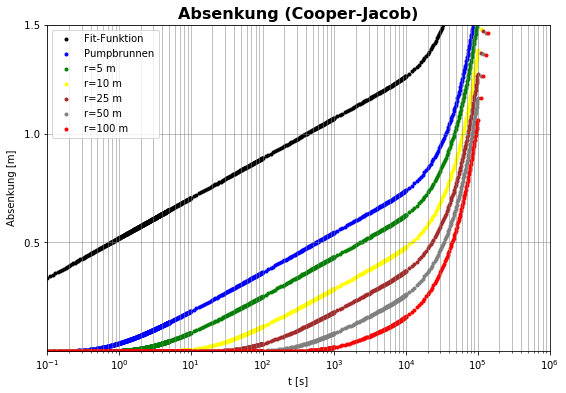

In [84]:
#Plot Function
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(time3, r_w3,marker='.', color='black')
ax.scatter(time3, r_53,marker='.', color='blue')
ax.scatter(time3, r_103,marker='.', color='green')
ax.scatter(time3, r_253,marker='.', color='yellow')
ax.scatter(time3, r_503,marker='.', color='brown')
ax.scatter(time3, r_1003,marker='.', color='grey')
ax.scatter(time3, r_2003,marker='.', color='red')
3
plt.xscale("log")
plt.axis([1E-1,1E6,1E-3,1.5])
ax.set(xlabel='t [s]', ylabel='Absenkung [m]')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.1f'))
plt.title('Absenkung (Cooper-Jacob)',fontweight='bold', fontsize=16)
ax.grid(which="both", color='grey',linewidth=0.5)
plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
plt.show()

In [85]:
#Berechnen der zentralen Differenz
t_diff3 = []

sw3_diff = []
s53_diff = []
s103_diff = []
s253_diff = []
s503_diff = []
s1003_diff = []
s2003_diff = []

cw3_diff = []
c53_diff = []
c103_diff = []
c253_diff = []
c503_diff = []
c1003_diff = []
c2003_diff = []
    
for x in range(len(time3)-1):
    if x>0:
        i = time3[x+1]-time3[x-1]
        t_diff3.append(i)
for x in range(len(r_w3)-1):
    if x>0:
        i = r_w3[x+1]-r_w3[x-1]
        sw3_diff.append(i)
        j = r_53[x+1]-r_53[x-1]
        s53_diff.append(j)
        k = r_103[x+1]-r_103[x-1]
        s103_diff.append(k)
        l = r_253[x+1]-r_253[x-1]
        s253_diff.append(l)
        m = r_503[x+1]-r_503[x-1]
        s503_diff.append(m)
        n = r_1003[x+1]-r_1003[x-1]
        s1003_diff.append(n)
        o = r_2003[x+1]-r_2003[x-1]
        s2003_diff.append(o)
for x in range(len(t_diff3)):
    i = sw3_diff[x]/t_diff3[x]
    j = s53_diff[x]/t_diff3[x]
    k = s103_diff[x]/t_diff3[x]
    l = s253_diff[x]/t_diff3[x]
    m = s503_diff[x]/t_diff3[x]
    n = s1003_diff[x]/t_diff3[x]
    o = s2003_diff[x]/t_diff3[x]
    cw3_diff.append(i)
    c53_diff.append(j)
    c103_diff.append(k)
    c253_diff.append(l)
    c503_diff.append(m)
    c1003_diff.append(n)
    c2003_diff.append(o)

#new points in time:
t_av3= []
for x in range (len(cw3_diff)):
    i = (time3[x+2]+time3[x])/2
    t_av3.append(i)
#central difference multiplied with new points in time:
bw3_diff = []
b53_diff = []
b103_diff = []
b253_diff = []
b503_diff = []
b1003_diff = []
b2003_diff = []
for x in range(len(t_av3)):
    i = cw3_diff[x]*t_av3[x]
    j = c53_diff[x]*t_av3[x]
    k = c103_diff[x]*t_av3[x]
    l = c253_diff[x]*t_av3[x]
    m = c503_diff[x]*t_av3[x]
    n = c1003_diff[x]*t_av3[x]
    o = c2003_diff[x]*t_av3[x]
    bw3_diff.append(i)
    b53_diff.append(j)
    b103_diff.append(k)
    b253_diff.append(l)
    b503_diff.append(m)
    b1003_diff.append(n)
    b2003_diff.append(o)

print(len(t_av3))
print(len(b53_diff))

999
999


In [87]:
#Plot Function
def splot(T, S, r, Q):
    tmax = 1000000
    r_max = 1000000
    s = [0 for x in range(r_max)]
    t = [1 for x in range(r_max)]
    
    for x in range(1,tmax,1):
        if x>0:
            s[x] = Q/(4*math.pi*T)*math.exp(-(S*r**2)/(4*T*x))
            t[x] = x
    #PLOT
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, s, 'red')
    ax.scatter(t_av3, bw3_diff,marker='.', color='black')
    ax.scatter(t_av3, b53_diff,marker='.', color='blue')
    ax.scatter(t_av3, b103_diff,marker='.', color='green')
    ax.scatter(t_av3, b253_diff,marker='.', color='orange')
    ax.scatter(t_av3, b503_diff,marker='.', color='lime')
    ax.scatter(t_av3, b1003_diff,marker='.', color='grey')
    ax.scatter(t_av3, b2003_diff,marker='.', color='violet')
    3
    plt.yscale("log")
    plt.xscale("log")
    plt.axis([1E0,1E6,1E-3,1E1])
    ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot')
    plt.title('Auswertung mit diagnostischem Plot',fontweight='bold', fontsize=16)
    ax.grid(which="both", color='grey',linewidth=0.5)
    plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
    plt.show()
# Computation
interact(splot,
         r = widgets.FloatSlider(value=200, min=0, max=200, step=5, description='r [m]:', continuous_update=False, disabled=False, readout_format='.1d'),
         Q = widgets.FloatLogSlider(value=1E-3, base=10, min=-4, max=-1, step=0.001, description='Q [m³/s]:', continuous_update=False, readout_format='.0e'),
         T = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=2, step=0.1,readout=True,description='T [m²/s]:', continuous_update=False,readout_format='.1e'),
         S = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=0, step=0.1,readout=True,description='S [ - ]:', continuous_update=False,readout_format='.1e'))

interactive(children=(FloatLogSlider(value=0.0001, continuous_update=False, description='T [m²/s]:', max=2.0, …

<function __main__.splot(T, S, r, Q)>

## Pumpversuch 5-3

In [90]:
#Pumprate [m3/s]:
Q = 1E-3
# Zeit nach Pumpbeginn in Sekunden
time4 = [0.00E+00,1.00E-02,2.00E-02,3.00E-02,4.00E-02,5.00E-02,6.00E-02,7.00E-02,8.00E-02,9.00E-02,1.00E-01,1.10E-01,1.20E-01,1.30E-01,1.40E-01,1.50E-01,1.60E-01,1.70E-01,1.80E-01,1.90E-01,2.00E-01,2.10E-01,2.20E-01,2.30E-01,2.40E-01,2.50E-01,2.60E-01,2.70E-01,2.80E-01,2.90E-01,3.00E-01,3.10E-01,3.20E-01,3.30E-01,3.40E-01,3.50E-01,3.60E-01,3.70E-01,3.80E-01,3.90E-01,4.00E-01,4.10E-01,4.20E-01,4.30E-01,4.40E-01,4.50E-01,4.60E-01,4.70E-01,4.80E-01,4.90E-01,5.00E-01,5.10E-01,5.20E-01,5.30E-01,5.40E-01,5.50E-01,5.60E-01,5.70E-01,5.80E-01,5.90E-01,6.00E-01,6.10E-01,6.20E-01,6.30E-01,6.40E-01,6.50E-01,6.60E-01,6.70E-01,6.80E-01,6.90E-01,7.00E-01,7.10E-01,7.20E-01,7.30E-01,7.40E-01,7.50E-01,7.60E-01,7.70E-01,7.80E-01,7.90E-01,8.00E-01,8.10E-01,8.20E-01,8.30E-01,8.40E-01,8.50E-01,8.60E-01,8.70E-01,8.80E-01,8.90E-01,9.00E-01,9.10E-01,9.20E-01,9.30E-01,9.40E-01,9.50E-01,9.60E-01,9.70E-01,9.80E-01,9.90E-01,1.00E+00,1.01E+00,1.02E+00,1.03E+00,1.04E+00,1.05E+00,1.06E+00,1.07E+00,1.08E+00,1.09E+00,1.10E+00,1.11E+00,1.12E+00,1.13E+00,1.14E+00,1.15E+00,1.16E+00,1.17E+00,1.18E+00,1.19E+00,1.20E+00,1.21E+00,1.22E+00,1.23E+00,1.24E+00,1.25E+00,1.26E+00,1.27E+00,1.28E+00,1.29E+00,1.30E+00,1.31E+00,1.32E+00,1.33E+00,1.34E+00,1.35E+00,1.36E+00,1.37E+00,1.38E+00,1.39E+00,1.40E+00,1.41E+00,1.42E+00,1.43E+00,1.44E+00,1.45E+00,1.46E+00,1.47E+00,1.48E+00,1.49E+00,1.50E+00,1.51E+00,1.52E+00,1.53E+00,1.54E+00,1.55E+00,1.56E+00,1.57E+00,1.58E+00,1.59E+00,1.60E+00,1.61E+00,1.62E+00,1.63E+00,1.64E+00,1.65E+00,1.66E+00,1.67E+00,1.68E+00,1.69E+00,1.70E+00,1.71E+00,1.72E+00,1.73E+00,1.74E+00,1.75E+00,1.76E+00,1.77E+00,1.78E+00,1.79E+00,1.80E+00,1.81E+00,1.82E+00,1.83E+00,1.84E+00,1.85E+00,1.86E+00,1.87E+00,1.88E+00,1.89E+00,1.90E+00,1.91E+00,1.92E+00,1.93E+00,1.94E+00,1.95E+00,1.96E+00,1.97E+00,1.98E+00,1.99E+00,2.00E+00,2.01E+00,2.02E+00,2.03E+00,2.04E+00,2.05E+00,2.06E+00,2.07E+00,2.08E+00,2.09E+00,2.10E+00,2.11E+00,2.12E+00,2.13E+00,2.14E+00,2.15E+00,2.16E+00,2.17E+00,2.18E+00,2.19E+00,2.20E+00,2.21E+00,2.22E+00,2.23E+00,2.24E+00,2.25E+00,2.26E+00,2.27E+00,2.28E+00,2.29E+00,2.30E+00,2.31E+00,2.32E+00,2.33E+00,2.34E+00,2.35E+00,2.36E+00,2.37E+00,2.38E+00,2.39E+00,2.40E+00,2.41E+00,2.42E+00,2.43E+00,2.44E+00,2.45E+00,2.46E+00,2.47E+00,2.48E+00,2.49E+00,2.50E+00,2.51E+00,2.52E+00,2.53E+00,2.54E+00,2.55E+00,2.56E+00,2.57E+00,2.58E+00,2.59E+00,2.60E+00,2.61E+00,2.62E+00,2.63E+00,2.64E+00,2.65E+00,2.66E+00,2.67E+00,2.68E+00,2.69E+00,2.70E+00,2.71E+00,2.72E+00,2.73E+00,2.74E+00,2.75E+00,2.76E+00,2.77E+00,2.78E+00,2.79E+00,2.80E+00,2.81E+00,2.82E+00,2.83E+00,2.84E+00,2.85E+00,2.86E+00,2.87E+00,2.88E+00,2.89E+00,2.90E+00,2.91E+00,2.92E+00,2.93E+00,2.94E+00,2.95E+00,2.96E+00,2.97E+00,2.98E+00,2.99E+00,3.00E+00,3.01E+00,3.02E+00,3.03E+00,3.04E+00,3.05E+00,3.06E+00,3.07E+00,3.08E+00,3.09E+00,3.10E+00,3.11E+00,3.12E+00,3.13E+00,3.14E+00,3.15E+00,3.16E+00,3.17E+00,3.18E+00,3.19E+00,3.20E+00,3.21E+00,3.22E+00,3.23E+00,3.24E+00,3.25E+00,3.26E+00,3.27E+00,3.28E+00,3.29E+00,3.30E+00,3.31E+00,3.32E+00,3.33E+00,3.34E+00,3.35E+00,3.36E+00,3.37E+00,3.38E+00,3.39E+00,3.40E+00,3.41E+00,3.42E+00,3.43E+00,3.44E+00,3.45E+00,3.46E+00,3.47E+00,3.48E+00,3.49E+00,3.50E+00,3.51E+00,3.52E+00,3.53E+00,3.54E+00,3.55E+00,3.56E+00,3.57E+00,3.58E+00,3.59E+00,3.60E+00,3.61E+00,3.62E+00,3.63E+00,3.64E+00,3.65E+00,3.66E+00,3.67E+00,3.68E+00,3.69E+00,3.70E+00,3.71E+00,3.72E+00,3.73E+00,3.74E+00,3.75E+00,3.76E+00,3.77E+00,3.78E+00,3.79E+00,3.80E+00,3.81E+00,3.82E+00,3.83E+00,3.84E+00,3.85E+00,3.86E+00,3.87E+00,3.88E+00,3.89E+00,3.90E+00,3.91E+00,3.92E+00,3.93E+00,3.94E+00,3.95E+00,3.96E+00,3.97E+00,3.98E+00,3.99E+00,4.00E+00,4.01E+00,4.02E+00,4.03E+00,4.04E+00,4.05E+00,4.06E+00,4.07E+00,4.08E+00,4.09E+00,4.10E+00,4.11E+00,4.12E+00,4.13E+00,4.14E+00,4.15E+00,4.16E+00,4.17E+00,4.18E+00,4.19E+00,4.20E+00,4.21E+00,4.22E+00,4.23E+00,4.24E+00,4.25E+00,4.26E+00,4.27E+00,4.28E+00,4.29E+00,4.30E+00,4.31E+00,4.32E+00,4.33E+00,4.34E+00,4.35E+00,4.36E+00,4.37E+00,4.38E+00,4.39E+00,4.40E+00,4.41E+00,4.42E+00,4.43E+00,4.44E+00,4.45E+00,4.46E+00,4.47E+00,4.48E+00,4.49E+00,4.50E+00,4.51E+00,4.52E+00,4.53E+00,4.54E+00,4.55E+00,4.56E+00,4.57E+00,4.58E+00,4.59E+00,4.60E+00,4.61E+00,4.62E+00,4.63E+00,4.64E+00,4.65E+00,4.66E+00,4.67E+00,4.68E+00,4.69E+00,4.70E+00,4.71E+00,4.72E+00,4.73E+00,4.74E+00,4.75E+00,4.76E+00,4.77E+00,4.78E+00,4.79E+00,4.80E+00,4.81E+00,4.82E+00,4.83E+00,4.84E+00,4.85E+00,4.86E+00,4.87E+00,4.88E+00,4.89E+00,4.90E+00,4.91E+00,4.92E+00,4.93E+00,4.94E+00,4.95E+00,4.96E+00,4.97E+00,4.98E+00,4.99E+00,5.00E+00,5.10E+00,5.20E+00,5.30E+00,5.40E+00,5.50E+00,5.60E+00,5.70E+00,5.80E+00,5.90E+00,6.00E+00,6.10E+00,6.20E+00,6.30E+00,6.40E+00,6.50E+00,6.60E+00,6.70E+00,6.80E+00,6.90E+00,7.00E+00,7.10E+00,7.20E+00,7.30E+00,7.40E+00,7.50E+00,7.60E+00,7.70E+00,7.80E+00,7.90E+00,8.00E+00,8.10E+00,8.20E+00,8.30E+00,8.40E+00,8.50E+00,8.60E+00,8.70E+00,8.80E+00,8.90E+00,9.00E+00,9.10E+00,9.20E+00,9.30E+00,9.40E+00,9.50E+00,9.60E+00,9.70E+00,9.80E+00,9.90E+00,1.00E+01,1.10E+01,1.20E+01,1.30E+01,1.40E+01,1.50E+01,1.60E+01,1.70E+01,1.80E+01,1.90E+01,2.00E+01,2.10E+01,2.20E+01,2.30E+01,2.40E+01,2.50E+01,2.60E+01,2.70E+01,2.80E+01,2.90E+01,3.00E+01,3.10E+01,3.20E+01,3.30E+01,3.40E+01,3.50E+01,3.60E+01,3.70E+01,3.80E+01,3.90E+01,4.00E+01,4.10E+01,4.20E+01,4.30E+01,4.40E+01,4.50E+01,4.60E+01,4.70E+01,4.80E+01,4.90E+01,5.00E+01,5.10E+01,5.20E+01,5.30E+01,5.40E+01,5.50E+01,5.60E+01,5.70E+01,5.80E+01,5.90E+01,6.00E+01,6.10E+01,6.20E+01,6.30E+01,6.40E+01,6.50E+01,6.60E+01,6.70E+01,6.80E+01,6.90E+01,7.00E+01,7.10E+01,7.20E+01,7.30E+01,7.40E+01,7.50E+01,7.60E+01,7.70E+01,7.80E+01,7.90E+01,8.00E+01,8.10E+01,8.20E+01,8.30E+01,8.40E+01,8.50E+01,8.60E+01,8.70E+01,8.80E+01,8.90E+01,9.00E+01,9.10E+01,9.20E+01,9.30E+01,9.40E+01,9.50E+01,9.60E+01,9.70E+01,9.80E+01,9.90E+01,1.00E+02,1.10E+02,1.20E+02,1.30E+02,1.40E+02,1.50E+02,1.60E+02,1.70E+02,1.80E+02,1.90E+02,2.00E+02,2.10E+02,2.20E+02,2.30E+02,2.40E+02,2.50E+02,2.60E+02,2.70E+02,2.80E+02,2.90E+02,3.00E+02,3.10E+02,3.20E+02,3.30E+02,3.40E+02,3.50E+02,3.60E+02,3.70E+02,3.80E+02,3.90E+02,4.00E+02,4.10E+02,4.20E+02,4.30E+02,4.40E+02,4.50E+02,4.60E+02,4.70E+02,4.80E+02,4.90E+02,5.00E+02,5.10E+02,5.20E+02,5.30E+02,5.40E+02,5.50E+02,5.60E+02,5.70E+02,5.80E+02,5.90E+02,6.00E+02,6.10E+02,6.20E+02,6.30E+02,6.40E+02,6.50E+02,6.60E+02,6.70E+02,6.80E+02,6.90E+02,7.00E+02,7.10E+02,7.20E+02,7.30E+02,7.40E+02,7.50E+02,7.60E+02,7.70E+02,7.80E+02,7.90E+02,8.00E+02,8.10E+02,8.20E+02,8.30E+02,8.40E+02,8.50E+02,8.60E+02,8.70E+02,8.80E+02,8.90E+02,9.00E+02,9.10E+02,9.20E+02,9.30E+02,9.40E+02,9.50E+02,9.60E+02,9.70E+02,9.80E+02,9.90E+02,1.00E+03,1.10E+03,1.20E+03,1.30E+03,1.40E+03,1.50E+03,1.60E+03,1.70E+03,1.80E+03,1.90E+03,2.00E+03,2.10E+03,2.20E+03,2.30E+03,2.40E+03,2.50E+03,2.60E+03,2.70E+03,2.80E+03,2.90E+03,3.00E+03,3.10E+03,3.20E+03,3.30E+03,3.40E+03,3.50E+03,3.60E+03,3.70E+03,3.80E+03,3.90E+03,4.00E+03,4.10E+03,4.20E+03,4.30E+03,4.40E+03,4.50E+03,4.60E+03,4.70E+03,4.80E+03,4.90E+03,5.00E+03,5.10E+03,5.20E+03,5.30E+03,5.40E+03,5.50E+03,5.60E+03,5.70E+03,5.80E+03,5.90E+03,6.00E+03,6.10E+03,6.20E+03,6.30E+03,6.40E+03,6.50E+03,6.60E+03,6.70E+03,6.80E+03,6.90E+03,7.00E+03,7.10E+03,7.20E+03,7.30E+03,7.40E+03,7.50E+03,7.60E+03,7.70E+03,7.80E+03,7.90E+03,8.00E+03,8.10E+03,8.20E+03,8.30E+03,8.40E+03,8.50E+03,8.60E+03,8.70E+03,8.80E+03,8.90E+03,9.00E+03,9.10E+03,9.20E+03,9.30E+03,9.40E+03,9.50E+03,9.60E+03,9.70E+03,9.80E+03,9.90E+03,1.00E+04,1.10E+04,1.20E+04,1.30E+04,1.40E+04,1.50E+04,1.60E+04,1.70E+04,1.80E+04,1.90E+04,2.00E+04,2.10E+04,2.20E+04,2.30E+04,2.40E+04,2.50E+04,2.60E+04,2.70E+04,2.80E+04,2.90E+04,3.00E+04,3.10E+04,3.20E+04,3.30E+04,3.40E+04,3.50E+04,3.60E+04,3.70E+04,3.80E+04,3.90E+04,4.00E+04,4.10E+04,4.20E+04,4.30E+04,4.40E+04,4.50E+04,4.60E+04,4.70E+04,4.80E+04,4.90E+04,5.00E+04,5.10E+04,5.20E+04,5.30E+04,5.40E+04,5.50E+04,5.60E+04,5.70E+04,5.80E+04,5.90E+04,6.00E+04,6.10E+04,6.20E+04,6.30E+04,6.40E+04,6.50E+04,6.60E+04,6.70E+04,6.80E+04,6.90E+04,7.00E+04,7.10E+04,7.20E+04,7.30E+04,7.40E+04,7.50E+04,7.60E+04,7.70E+04,7.80E+04,7.90E+04,8.00E+04,8.10E+04,8.20E+04,8.30E+04,8.40E+04,8.50E+04,8.60E+04,8.70E+04,8.80E+04,8.90E+04,9.00E+04,9.10E+04,9.20E+04,9.30E+04,9.40E+04,9.50E+04,9.60E+04,9.70E+04,9.80E+04,9.90E+04,1.00E+05,1.10E+05,1.20E+05,1.30E+05,1.40E+05,1.50E+05,1.60E+05,1.70E+05,1.80E+05,1.90E+05,2.00E+05,2.10E+05,2.20E+05,2.30E+05,2.40E+05,2.50E+05,2.60E+05,2.70E+05,2.80E+05,2.90E+05,3.00E+05,3.10E+05,3.20E+05,3.30E+05,3.40E+05,3.50E+05,3.60E+05,3.70E+05,3.80E+05,3.90E+05,4.00E+05,4.10E+05,4.20E+05,4.30E+05,4.40E+05,4.50E+05,4.60E+05,4.70E+05,4.80E+05,4.90E+05,5.00E+05,5.10E+05,5.20E+05,5.30E+05,5.40E+05,5.50E+05,5.60E+05,5.70E+05,5.80E+05,5.90E+05,6.00E+05,6.10E+05,6.20E+05,6.30E+05,6.40E+05,6.50E+05,6.60E+05,6.70E+05,6.80E+05,6.90E+05,7.00E+05,7.10E+05,7.20E+05,7.30E+05,7.40E+05,7.50E+05,7.60E+05,7.70E+05,7.80E+05,7.90E+05,8.00E+05,8.10E+05,8.20E+05,8.30E+05,8.40E+05,8.50E+05,8.60E+05,8.70E+05,8.80E+05,8.90E+05,9.00E+05,9.10E+05,9.20E+05,9.30E+05,9.40E+05,9.50E+05,9.60E+05,9.70E+05,9.80E+05,9.90E+05,1.00E+06]
#Wasserstände im Pumpbrunnen (Radius: 0.1 m) und in den Beobachtungsstellen (Entfernung zum Pumpbrunnen: 5, 10, 25, 50, 100, 200 m)
r_w4 = [0,0.131513596,0.197067261,0.235728264,0.261796951,0.281135559,0.296448708,0.309130669,0.319969177,0.329446793,0.337877274,0.345476151,0.352397919,0.358756065,0.364636421,0.370108604,0.375225067,0.380030632,0.384560585,0.38884449,0.39290905,0.396775246,0.400461197,0.40398407,0.407356262,0.410591125,0.41369915,0.416690826,0.41957283,0.422354698,0.425042152,0.427641869,0.430158615,0.432598114,0.434965134,0.437264442,0.439497948,0.441670418,0.443785667,0.445845604,0.447854042,0.449812889,0.451724052,0.453591347,0.455414772,0.457198143,0.45894146,0.460647583,0.46231842,0.463954926,0.465558052,0.467129707,0.468670845,0.470182419,0.471666336,0.473122597,0.474553108,0.47595787,0.477337837,0.478694916,0.480029106,0.481342316,0.482632637,0.483902931,0.485154152,0.486384392,0.487596512,0.488790512,0.489967346,0.491127014,0.492269516,0.493396759,0.494506836,0.495602608,0.496683121,0.497749329,0.498802185,0.499840736,0.500864983,0.501876831,0.502876282,0.503863335,0.50483799,0.505801201,0.506752968,0.507693291,0.508623123,0.509541512,0.510449409,0.511347771,0.512235641,0.513113976,0.513982773,0.514842033,0.515691757,0.516532898,0.517365456,0.518188477,0.519004822,0.51981163,0.520610809,0.521402359,0.522185326,0.522960663,0.523729324,0.524490356,0.525243759,0.525990486,0.526730537,0.527462959,0.528189659,0.528909683,0.529623032,0.530329704,0.531030655,0.531725883,0.532414436,0.533097267,0.533774376,0.534445763,0.535111427,0.53577137,0.536426544,0.53707695,0.53772068,0.538359642,0.538993835,0.53962326,0.540246964,0.540866852,0.541481018,0.54209137,0.542696953,0.543297768,0.543893814,0.544486046,0.545073509,0.545656204,0.546235085,0.54681015,0.547381401,0.547947884,0.548510551,0.549069405,0.549624443,0.550175667,0.550723076,0.55126667,0.551807404,0.552343369,0.552876472,0.553405762,0.55393219,0.55445385,0.554973602,0.555488586,0.556001663,0.556510925,0.557017326,0.557519913,0.558019638,0.558515549,0.559008598,0.559499741,0.559987068,0.560471535,0.56095314,0.561432838,0.561908722,0.562381744,0.562851906,0.563319206,0.563784599,0.564246178,0.564705849,0.565162659,0.565617561,0.566069603,0.566518784,0.566965103,0.567409515,0.567851067,0.56829071,0.568728447,0.569162369,0.569595337,0.570025444,0.57045269,0.570878029,0.57130146,0.571722984,0.572141647,0.572558403,0.572972298,0.573385239,0.573795319,0.574203491,0.574609756,0.575013161,0.575415611,0.575815201,0.576213837,0.576609612,0.577004433,0.577396393,0.577787399,0.578175545,0.578562737,0.578947067,0.579330444,0.57971096,0.580090523,0.580468178,0.580843925,0.581217766,0.581589699,0.581960678,0.58232975,0.582696915,0.583062172,0.583426476,0.583788872,0.584149361,0.584507942,0.58486557,0.585221291,0.585576057,0.585928917,0.586279869,0.586628914,0.586977959,0.587324142,0.587669373,0.588013649,0.588355064,0.58869648,0.589035988,0.589373589,0.589710236,0.590044975,0.590378761,0.590711594,0.591042519,0.591371536,0.5916996,0.592026711,0.592352867,0.592677116,0.592999458,0.5933218,0.593642235,0.593961716,0.594279289,0.594595909,0.594911575,0.595225334,0.595539093,0.595849991,0.596160889,0.596469879,0.59677887,0.597085953,0.597391129,0.597696304,0.597999573,0.598301888,0.598603249,0.598903656,0.599202156,0.599500656,0.599797249,0.600092888,0.600387573,0.600681305,0.600974083,0.601265907,0.601555824,0.601845741,0.602133751,0.602420807,0.602707863,0.602993011,0.603277206,0.603560448,0.603842735,0.604124069,0.604404449,0.604683876,0.604962349,0.605239868,0.605516434,0.605792046,0.606066704,0.606340408,0.606613159,0.606884956,0.6071558,0.607426643,0.60769558,0.607963562,0.608231544,0.60849762,0.608763695,0.609027863,0.60929203,0.609555244,0.609817505,0.610078812,0.610339165,0.610598564,0.610857964,0.611115456,0.611372948,0.611628532,0.611884117,0.612139702,0.612393379,0.612646103,0.612898827,0.613150597,0.613400459,0.613651276,0.613900185,0.61414814,0.614396095,0.614643097,0.614889145,0.615134239,0.615379333,0.615623474,0.615866661,0.616108894,0.616350174,0.616591454,0.616831779,0.617071152,0.617310524,0.617547989,0.617785454,0.618022919,0.618258476,0.618494034,0.618728638,0.618962288,0.619195938,0.619428635,0.619660378,0.61989212,0.620121956,0.620352745,0.620581627,0.620810509,0.621038437,0.621265411,0.621492386,0.621718407,0.621943474,0.622168541,0.622393608,0.622616768,0.622839928,0.623062134,0.62328434,0.623504639,0.623724937,0.623945236,0.624164581,0.624382973,0.624601364,0.624818802,0.62503624,0.625252724,0.625468254,0.625682831,0.625898361,0.626111984,0.626325607,0.626538277,0.626750946,0.626962662,0.627174377,0.627384186,0.627594948,0.627804756,0.628013611,0.628221512,0.628429413,0.628637314,0.628844261,0.629050255,0.629256248,0.629461288,0.629666328,0.629870415,0.630074501,0.630277634,0.630480766,0.630682945,0.630884171,0.631085396,0.631286621,0.631486893,0.631686211,0.631885529,0.632083893,0.632282257,0.632480621,0.632677078,0.632874489,0.633069992,0.633266449,0.633460999,0.633656502,0.633851051,0.634044647,0.634238243,0.634430885,0.634623528,0.63481617,0.635007858,0.635198593,0.635389328,0.635580063,0.635769844,0.635958672,0.636147499,0.636336327,0.6365242,0.636712074,0.636898994,0.637085915,0.637271881,0.637457848,0.637643814,0.637828827,0.638012886,0.638196945,0.638381004,0.63856411,0.638747215,0.638929367,0.639111519,0.639293671,0.639474869,0.639655113,0.639836311,0.640015602,0.640195847,0.640374184,0.640553474,0.640731812,0.640910149,0.641087532,0.641264915,0.641441345,0.641617775,0.641794205,0.641969681,0.642145157,0.642319679,0.642494202,0.642668724,0.642842293,0.643015862,0.643188477,0.643361092,0.643533707,0.643705368,0.643877029,0.644048691,0.644219398,0.644389153,0.64455986,0.644729614,0.644898415,0.645067215,0.645236015,0.645404816,0.645572662,0.645740509,0.645907402,0.646074295,0.646241188,0.646407127,0.646573067,0.646739006,0.646903992,0.647068977,0.647233009,0.647397041,0.647561073,0.647725105,0.647888184,0.648051262,0.648213387,0.648375511,0.648536682,0.648698807,0.648859978,0.649021149,0.64918232,0.650756836,0.652300835,0.653817177,0.655305862,0.656766891,0.658203125,0.659613609,0.661000252,0.662363052,0.663703918,0.66502285,0.666319847,0.667596817,0.66885376,0.670091629,0.671310425,0.672511101,0.673694611,0.674860001,0.676010132,0.677143097,0.678260803,0.679362297,0.680449486,0.681522369,0.682580948,0.683625221,0.684656143,0.685674667,0.68667984,0.687672615,0.688652992,0.689621925,0.690579414,0.691524506,0.692459106,0.693383217,0.694296837,0.695199966,0.696092606,0.696975708,0.697849274,0.698713303,0.699567795,0.70041275,0.701250076,0.702077866,0.702898026,0.703708649,0.704511642,0.711853981,0.718610764,0.724865913,0.73068428,0.736122131,0.741223335,0.746026993,0.750563622,0.754860878,0.758943558,0.762830734,0.766539574,0.770086288,0.773483276,0.776750565,0.779878616,0.782904625,0.785805702,0.788620949,0.791326523,0.793955803,0.796490669,0.798958778,0.801342964,0.803667068,0.805916786,0.808114052,0.810243607,0.812326431,0.814349175,0.816329002,0.818253517,0.820139885,0.821976662,0.823778152,0.825533867,0.827257156,0.828939438,0.830592155,0.832205772,0.833792686,0.835344315,0.836870193,0.838363647,0.839834213,0.841273308,0.842691422,0.844080925,0.845450401,0.846793175,0.848117828,0.849416733,0.850698471,0.851956367,0.853198051,0.854417801,0.855622292,0.856805801,0.857975006,0.859125137,0.860260963,0.86137867,0.862483025,0.863570213,0.864645004,0.865702629,0.866749763,0.867780685,0.868801117,0.86980629,0.870800018,0.871780396,0.872751236,0.873707771,0.874655724,0.875590324,0.876515388,0.877429008,0.878333092,0.879226685,0.880110741,0.880984306,0.881849289,0.882704735,0.883551598,0.88438797,0.885217667,0.886036873,0.886850357,0.887653351,0.895002365,0.901783943,0.908041954,0.913890839,0.919335365,0.924466133,0.929279327,0.933843613,0.938153267,0.942263603,0.946164131,0.949890137,0.953467369,0.956882477,0.960173607,0.963372231,0.966389656,0.969311714,0.972145081,0.974895477,0.977523804,0.980075836,0.982561111,0.984983444,0.987286568,0.98957634,0.991798401,0.9939394,0.996021271,0.998066902,1.000062943,1.00198555,1.003892899,1.005759239,1.007544518,1.009324074,1.011071205,1.012742996,1.014410973,1.016052246,1.017623901,1.019193649,1.020740509,1.022222519,1.023715973,1.025150299,1.026589394,1.027975082,1.029364586,1.030703545,1.032046318,1.033342361,1.034640312,1.035895348,1.037153244,1.038370132,1.039588928,1.040769577,1.041952133,1.043099403,1.044248581,1.045362473,1.046480179,1.047563553,1.048650742,1.049706459,1.050764084,1.051792145,1.052823067,1.053825378,1.054830551,1.055808067,1.056788445,1.057743073,1.058699608,1.059632301,1.060566902,1.061477661,1.062390327,1.063281059,1.064174652,1.065045357,1.065918922,1.066771507,1.067625999,1.068460464,1.069297791,1.070116043,1.070935249,1.071736336,1.079128265,1.085913658,1.092217445,1.098061562,1.103541374,1.108670235,1.113505363,1.118096352,1.122415543,1.12651825,1.130467415,1.134207726,1.137805939,1.141249657,1.144561768,1.147738457,1.15080452,1.153748512,1.156599045,1.159339905,1.161999702,1.164566994,1.167063713,1.169476509,1.171825409,1.174103737,1.176325798,1.178481102,1.180586815,1.182635307,1.184638023,1.18658638,1.188494682,1.190357208,1.192180634,1.193961143,1.195707321,1.197415352,1.199090958,1.200736046,1.202344894,1.203929901,1.205477715,1.206999779,1.208498955,1.209972382,1.211421013,1.212841034,1.214244843,1.215622902,1.216978073,1.218318939,1.219635963,1.220937729,1.222218513,1.223484993,1.224733353,1.225961685,1.22717762,1.228376389,1.229559898,1.230732918,1.231888771,1.233029366,1.234161377,1.235281944,1.236379623,1.237475395,1.238555908,1.239629745,1.240688324,1.241736412,1.242776871,1.243806839,1.244825363,1.245838165,1.24683857,1.247832298,1.248815537,1.249792099,1.250758171,1.251718521,1.252668381,1.253615379,1.254548073,1.255480766,1.256398201,1.257317543,1.25822258,1.259128571,1.267595291,1.275608063,1.283249855,1.290565491,1.297581673,1.304326057,1.310822487,1.31710434,1.323176384,1.329057693,1.334740639,1.340280533,1.345639229,1.350846291,1.355917931,1.360834122,1.36560154,1.37025547,1.374806404,1.379203796,1.383460045,1.387625694,1.391665459,1.395611763,1.399449348,1.403189659,1.406814575,1.4103508,1.413801193,1.417161942,1.42041111,1.423581123,1.426671028,1.429697037,1.432623863,1.435466766,1.438245773,1.440946579,1.443540573,1.446135521,1.448596954,1.451050758,1.453383446,1.455706596,1.457914352,1.460116386,1.462206841,1.464294434,1.466273308,1.468252182,1.470126152,1.472002029,1.473775864,1.47555542,1.47723484,1.478923798,1.480510712,1.482115746,1.483613968,1.485139847,1.486556053,1.488002777,1.489345551,1.490714073,1.491989136,1.493282318,1.494493485,1.495717049,1.49686718,1.498023033,1.499115944,1.500208855,1.501246452,1.502280235,1.503265381,1.504242897,1.505177498,1.506102562,1.506990433,1.507865906,1.508707047,1.509535789,1.510334015,1.511118889,1.511875153,1.512619019,1.513336182,1.514039993,1.514719963,1.515386581,1.520601273,1.524749756,1.527945518,1.530475616,1.532484055,1.534041405,1.535272598,1.536226273,1.536960602,1.537566185,1.538025856,1.53838253,1.538678169,1.538895607,1.539075851,1.539203644,1.539241791,1.539237976,1.539255142,1.539255142,1.539273262,1.539272308,1.539286613,1.539287567,1.539299965,1.539300919,1.539312363,1.539313316,1.539323807,1.539325714,1.539335251,1.539336205,1.539345741,1.539346695,1.539356232,1.539357185,1.539365768,1.539366722,1.539374352,1.539376259,1.539383888,1.539385796,1.539392471,1.539394379,1.539401054,1.539402962,1.539408684,1.539410591,1.539417267,1.539419174,1.539424896,1.539426804,1.539432526,1.539433479,1.539439201,1.539441109,1.539446831,1.539447784,1.539453506,1.539455414,1.539460182,1.53946209,1.539466858,1.539468765,1.539473534,1.539474487,1.539479256,1.539481163,1.539484978,1.539486885,1.539491653,1.539492607,1.539497375,1.539498329,1.539503098,1.539504051,1.539507866,1.539509773,1.539513588,1.539514542,1.539518356,1.539520264,1.539524078,1.539525032,1.539528847,1.5395298,1.539533615,1.539534569,1.539538383,1.539539337]
r_54 = [0,0,9.53674E-07,2.86102E-06,7.62939E-06,1.62125E-05,3.14713E-05,5.34058E-05,8.58307E-05,0.000127792,0.000184059,0.000253677,0.000338554,0.00043869,0.000555992,0.00069046,0.000843048,0.001012802,0.001199722,0.001404762,0.001626015,0.001864433,0.002119064,0.002388954,0.002674103,0.002973557,0.003286362,0.003612518,0.003950119,0.004300117,0.00466156,0.005032539,0.005414009,0.005804062,0.006202698,0.006609917,0.007024765,0.007445335,0.007873535,0.008307457,0.008747101,0.009190559,0.00963974,0.010093689,0.010550499,0.011011124,0.011475563,0.011942863,0.012412071,0.01288414,0.013358116,0.013834,0.01431179,0.014790535,0.015271187,0.015751839,0.016234398,0.016716957,0.01720047,0.017683029,0.018167496,0.018651009,0.019134521,0.019618034,0.020101547,0.020584106,0.021066666,0.021548271,0.022028923,0.022509575,0.022989273,0.023467064,0.023944855,0.024421692,0.024896622,0.025371552,0.025844574,0.026315689,0.026786804,0.027256012,0.027724266,0.028190613,0.028656006,0.029119492,0.02958107,0.030041695,0.030501366,0.030959129,0.031414986,0.031869888,0.032322884,0.032773972,0.033224106,0.033671379,0.034118652,0.034563065,0.035005569,0.035447121,0.035886765,0.036325455,0.036761284,0.037196159,0.037629128,0.038060188,0.038490295,0.038917542,0.039343834,0.039768219,0.04019165,0.040612221,0.041031837,0.041449547,0.041865349,0.042280197,0.042693138,0.043104172,0.043513298,0.043920517,0.044326782,0.04473114,0.045133591,0.045534134,0.045933723,0.046332359,0.046728134,0.047122955,0.047515869,0.047906876,0.048296928,0.048685074,0.049072266,0.04945755,0.049840927,0.050222397,0.050602913,0.050981522,0.051359177,0.051734924,0.052109718,0.052482605,0.052853584,0.05322361,0.053591728,0.053958893,0.054325104,0.054688454,0.05505085,0.055412292,0.055771828,0.056130409,0.056487083,0.056842804,0.057196617,0.057549477,0.057900429,0.058250427,0.058599472,0.058946609,0.05929184,0.05963707,0.059980392,0.060321808,0.06066227,0.061001778,0.061339378,0.061676025,0.062011719,0.062345505,0.062678337,0.063010216,0.063341141,0.063670158,0.063998222,0.064324379,0.064650536,0.064974785,0.06529808,0.065619469,0.065940857,0.066260338,0.066578865,0.066896439,0.067212105,0.067526817,0.067840576,0.068153381,0.068465233,0.068775177,0.069085121,0.069393158,0.069700241,0.070005417,0.070310593,0.070614815,0.07091713,0.071219444,0.071519852,0.071819305,0.072117805,0.072415352,0.072711945,0.073007584,0.073302269,0.073596001,0.073887825,0.074179649,0.074469566,0.074759483,0.075047493,0.075335503,0.075621605,0.075907707,0.076191902,0.076476097,0.076759338,0.077040672,0.077322006,0.077601433,0.077880859,0.078158379,0.078435898,0.078712463,0.078987122,0.07926178,0.079535484,0.079808235,0.080080032,0.080350876,0.080621719,0.080890656,0.081159592,0.08142662,0.081693649,0.081958771,0.082223892,0.08248806,0.082751274,0.083013535,0.083275795,0.083536148,0.083796501,0.084055901,0.0843153,0.084572792,0.08482933,0.085085869,0.085341454,0.085596085,0.085849762,0.086102486,0.086355209,0.086606026,0.086856842,0.087106705,0.087356567,0.087604523,0.087852478,0.08809948,0.088346481,0.088591576,0.08883667,0.089080811,0.089323997,0.089567184,0.089809418,0.090050697,0.090291023,0.090531349,0.090770721,0.09100914,0.091246605,0.09148407,0.091720581,0.091956139,0.092191696,0.0924263,0.09265995,0.0928936,0.093126297,0.09335804,0.093588829,0.093819618,0.094049454,0.094278336,0.094507217,0.094735146,0.094963074,0.095190048,0.095416069,0.095641136,0.095866203,0.09609127,0.09631443,0.09653759,0.09676075,0.096982002,0.097204208,0.097424507,0.097644806,0.097864151,0.098083496,0.098301888,0.098519325,0.098736763,0.098954201,0.099169731,0.099385262,0.099600792,0.099815369,0.100028992,0.100242615,0.100455284,0.100667,0.100878716,0.101090431,0.101301193,0.101511002,0.10172081,0.101929665,0.102137566,0.102345467,0.102553368,0.102760315,0.102966309,0.103172302,0.103377342,0.103582382,0.103786469,0.103990555,0.104193687,0.10439682,0.104598999,0.104801178,0.105002403,0.105202675,0.105402946,0.105603218,0.105802536,0.1060009,0.106200218,0.106397629,0.106595039,0.10679245,0.106988907,0.107185364,0.107380867,0.107575417,0.107769966,0.107964516,0.108158112,0.108350754,0.108543396,0.108736038,0.108927727,0.109119415,0.10931015,0.109500885,0.10969162,0.109881401,0.110070229,0.110259056,0.110447884,0.110634804,0.110822678,0.111009598,0.111196518,0.111382484,0.111568451,0.111753464,0.111938477,0.112123489,0.112307549,0.112490654,0.112674713,0.112857819,0.11303997,0.113222122,0.113404274,0.113585472,0.113765717,0.113945961,0.114126205,0.114305496,0.114484787,0.114664078,0.114842415,0.115020752,0.115198135,0.115375519,0.115551949,0.115729332,0.115904808,0.116081238,0.116256714,0.116431236,0.116605759,0.116780281,0.11695385,0.117127419,0.117300987,0.117473602,0.117646217,0.117817879,0.11798954,0.118161201,0.118331909,0.118502617,0.118673325,0.118843079,0.119011879,0.119181633,0.119350433,0.11951828,0.11968708,0.119853973,0.12002182,0.120188713,0.120355606,0.120522499,0.120688438,0.120853424,0.121019363,0.121184349,0.121348381,0.121513367,0.121677399,0.121840477,0.122004509,0.122167587,0.122329712,0.122491837,0.122653961,0.122816086,0.122977257,0.123138428,0.123299599,0.123459816,0.123620033,0.123780251,0.123939514,0.124098778,0.124258041,0.124416351,0.124574661,0.124732018,0.124889374,0.125047684,0.125204086,0.125361443,0.125517845,0.125674248,0.125829697,0.125985146,0.126140594,0.12629509,0.126450539,0.126605034,0.126758575,0.126912117,0.127065659,0.1272192,0.127371788,0.127524376,0.127676964,0.127828598,0.127980232,0.128131866,0.128283501,0.128434181,0.128584862,0.128735542,0.128885269,0.129034996,0.129184723,0.129333496,0.129482269,0.129631042,0.129779816,0.129927635,0.130075455,0.130223274,0.13037014,0.130517006,0.130663872,0.130810738,0.13095665,0.131102562,0.131248474,0.131393433,0.131538391,0.13168335,0.131828308,0.131972313,0.132117271,0.132261276,0.132404327,0.132548332,0.132691383,0.132833481,0.132976532,0.133119583,0.134518623,0.135894775,0.137248039,0.138578415,0.139888763,0.141177177,0.142446518,0.143695831,0.144926071,0.146138191,0.147332191,0.148509026,0.149668694,0.150812149,0.151939392,0.153051376,0.154148102,0.155230522,0.156298637,0.157352448,0.158391953,0.15941906,0.160433769,0.161435127,0.162424088,0.16340065,0.164365768,0.165319443,0.166262627,0.167194366,0.168114662,0.169025421,0.16992569,0.170816422,0.171696663,0.172567368,0.173428535,0.17428112,0.175125122,0.175959587,0.176785469,0.177602768,0.178411484,0.17921257,0.180006027,0.180791855,0.181569099,0.182338715,0.183101654,0.183857918,0.19080162,0.197218895,0.203181267,0.208745956,0.213959694,0.218863487,0.223491669,0.227871895,0.232028961,0.235984802,0.239756584,0.243360519,0.246810913,0.250120163,0.253300667,0.256362915,0.259309769,0.262156487,0.264902115,0.267560959,0.270130157,0.272623062,0.275038719,0.277385712,0.279663086,0.281880379,0.284035683,0.286136627,0.288181305,0.290177345,0.292123795,0.294024467,0.295880318,0.29769516,0.29946804,0.301204681,0.302902222,0.304566383,0.306195259,0.307792664,0.309357643,0.310894012,0.312399864,0.313879013,0.315330505,0.316757202,0.318157196,0.319535255,0.320887566,0.322219849,0.32352829,0.324816704,0.326084137,0.327332497,0.328560829,0.329771042,0.330963135,0.332138062,0.333294868,0.334436417,0.335561752,0.336670876,0.33776474,0.338844299,0.339909554,0.340960503,0.3419981,0.343022346,0.344033241,0.345031738,0.346017838,0.346992493,0.34795475,0.348905563,0.349845886,0.350774765,0.351693153,0.352601051,0.353498459,0.35438633,0.35526371,0.356132507,0.356991768,0.357841492,0.358682632,0.35951519,0.360338211,0.361153603,0.361960411,0.36275959,0.370073318,0.376806259,0.383049965,0.388858795,0.394294739,0.399393082,0.4041996,0.40873909,0.41304493,0.417133331,0.421030045,0.424757004,0.428312302,0.43173027,0.435002327,0.438169479,0.441198349,0.444139481,0.446947098,0.449681282,0.452309608,0.454877853,0.457343102,0.459749222,0.462085724,0.464343071,0.466556549,0.468695641,0.47079277,0.472819328,0.474811554,0.476746559,0.478639603,0.48048687,0.48229599,0.484065056,0.485790253,0.487483978,0.489145279,0.490765572,0.492357254,0.49392128,0.495448112,0.496949196,0.49842453,0.499875069,0.501296997,0.502696991,0.504069328,0.505421638,0.506748199,0.508056641,0.509340286,0.510606766,0.511850357,0.51307869,0.514284134,0.515475273,0.516646385,0.517803192,0.518939972,0.520064354,0.521169662,0.522263527,0.523339272,0.524403572,0.525450706,0.52648735,0.527508736,0.528518677,0.529514313,0.530499458,0.531471252,0.532432556,0.533381462,0.534320831,0.535246849,0.536164284,0.537069321,0.537966728,0.538851738,0.539729118,0.540596008,0.541454315,0.542302132,0.543142319,0.543972969,0.54479599,0.545609474,0.546416283,0.553801537,0.560573578,0.566878319,0.572717667,0.578198433,0.583347321,0.588167191,0.592741013,0.597076416,0.601183891,0.605130196,0.608855247,0.612454414,0.615895271,0.619218826,0.622385025,0.625459671,0.628393173,0.631253242,0.633984566,0.636651993,0.639210701,0.641716003,0.644119263,0.646476746,0.64874649,0.650976181,0.653123856,0.655236244,0.657277107,0.659286499,0.66122818,0.663144112,0.664998055,0.666828156,0.66860199,0.670353889,0.672055244,0.673736572,0.675367355,0.676980972,0.678565979,0.680116653,0.68165493,0.683139801,0.684617043,0.686052322,0.687478065,0.688882828,0.690275192,0.691624641,0.692968369,0.694282532,0.695585251,0.696864128,0.698121071,0.699374199,0.700600624,0.701820374,0.703025818,0.704204559,0.705371857,0.706533432,0.707681656,0.708805084,0.70991993,0.711026192,0.712125778,0.713202477,0.714269638,0.715334892,0.716387749,0.717423439,0.718448639,0.719474792,0.720480919,0.721487999,0.722476959,0.723464966,0.724437714,0.725408554,0.726365089,0.727319717,0.728260994,0.729200363,0.730125427,0.731051445,0.731964111,0.732875824,0.733775139,0.742243767,0.750267029,0.757914543,0.765238762,0.772231102,0.77898407,0.785492897,0.791788101,0.797838211,0.803715706,0.809417725,0.814959526,0.820299149,0.82551384,0.830584526,0.835501671,0.840284348,0.844937325,0.849473953,0.853899002,0.858137131,0.862301826,0.866337776,0.870303154,0.874137878,0.877861023,0.8814888,0.885037422,0.88848114,0.891827583,0.89509201,0.898272514,0.901350975,0.904359818,0.907302856,0.910135269,0.91292572,0.915608406,0.918218613,0.920801163,0.923275948,0.925719261,0.928061485,0.930375099,0.932593346,0.934785843,0.936885834,0.93896389,0.940951347,0.942922592,0.944804192,0.94667244,0.948453903,0.950226784,0.951911926,0.953594208,0.955186844,0.956786156,0.958289146,0.959810257,0.961229324,0.962674141,0.964017868,0.965386391,0.9666605,0.967956543,0.969164848,0.970392227,0.97153759,0.972700119,0.973786354,0.974886894,0.975916862,0.976958275,0.977934837,0.97892189,0.979847908,0.980781555,0.981660843,0.982544899,0.983377457,0.984215736,0.985004425,0.985797882,0.986546516,0.987298012,0.988007545,0.98871994,0.989392281,0.990066528,0.995281219,0.99943161,1.002628326,1.005155563,1.007164001,1.008721352,1.009952545,1.010904312,1.011639595,1.012245178,1.012703896,1.013061523,1.013357162,1.013573647,1.013753891,1.01388073,1.01391983,1.013915062,1.013933182,1.013933182,1.013950348,1.013950348,1.013964653,1.013964653,1.013978004,1.013978004,1.013990402,1.013991356,1.014001846,1.0140028,1.01401329,1.014014244,1.014023781,1.014024735,1.014033318,1.014035225,1.014042854,1.014044762,1.014052391,1.014054298,1.014061928,1.014062881,1.014070511,1.014071465,1.01407814,1.014080048,1.014086723,1.014088631,1.014094353,1.01409626,1.014101982,1.014103889,1.014109612,1.014111519,1.014117241,1.014119148,1.014123917,1.014125824,1.014131546,1.0141325,1.014138222,1.014139175,1.014143944,1.014145851,1.01415062,1.014152527,1.014157295,1.014158249,1.014163017,1.014164925,1.014168739,1.014170647,1.014174461,1.014176369,1.014180183,1.014182091,1.014185905,1.014186859,1.014190674,1.014192581,1.014196396,1.01419735,1.014201164,1.014202118,1.014205933,1.01420784,1.014210701,1.014212608,1.014215469,1.014217377]
r_104 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,2.86102E-06,3.8147E-06,4.76837E-06,6.67572E-06,7.62939E-06,9.53674E-06,1.23978E-05,1.43051E-05,1.71661E-05,2.09808E-05,2.38419E-05,2.76566E-05,3.24249E-05,3.71933E-05,4.3869E-05,5.05447E-05,5.72205E-05,6.48499E-05,7.34329E-05,8.2016E-05,9.15527E-05,0.000102043,0.000114441,0.000126839,0.00014019,0.000154495,0.000169754,0.000185966,0.000203133,0.000221252,0.000240326,2.60E-04,2.82E-04,3.04E-04,3.27E-04,3.52E-04,3.78E-04,4.04E-04,4.33E-04,4.62E-04,4.92E-04,5.24E-04,5.56E-04,5.90E-04,6.26E-04,6.62E-04,7.00E-04,7.38E-04,7.78E-04,8.19E-04,8.62E-04,9.05E-04,9.50E-04,9.96E-04,1.04E-03,1.09E-03,1.14E-03,1.19E-03,1.24E-03,1.30E-03,1.35E-03,1.41E-03,1.46E-03,1.52E-03,0.001578331,1.64E-03,1.70E-03,1.76E-03,0.001824379,0.001888275,0.001953125,0.002018929,0.002086639,0.00215435,0.002223969,0.002293587,0.002365112,0.002437592,0.002511024,0.002584457,0.002659798,0.002735138,0.002812386,0.002890587,0.002968788,0.003048897,0.003129005,0.003210068,0.003292084,0.003375053,0.003458977,0.003543854,0.003628731,0.003715515,0.003802299,0.003890038,0.003977776,0.004067421,0.004157066,0.004247665,0.004339218,0.004431725,0.004524231,0.004616737,0.004711151,0.004805565,0.004900932,0.004997253,0.005093575,0.005190849,0.005289078,0.005387306,0.005486488,0.00558567,0.005685806,0.005785942,0.005887032,0.005988121,0.006091118,0.006193161,0.006297112,0.006400108,0.006504059,0.006608963,0.006713867,0.006818771,0.006924629,0.007031441,0.007138252,0.007245064,0.007352829,0.007460594,0.007569313,0.007678032,0.007786751,0.007896423,0.008006096,0.008115768,0.008226395,0.008337021,0.008448601,0.008560181,0.008671761,0.00878334,0.008895874,0.009008408,0.009121895,0.009234428,0.009347916,0.009462357,0.009575844,0.009690285,0.009804726,0.009919167,0.010034561,0.010149956,0.01026535,0.010380745,0.010497093,0.010612488,0.010728836,0.010845184,0.010962486,0.011078835,0.011196136,0.011313438,0.01143074,0.011548996,0.011666298,0.011784554,0.011902809,0.012020111,0.01213932,0.012257576,0.012375832,0.012495041,0.01261425,0.012732506,0.012851715,0.012970924,0.013091087,0.013209343,0.013329506,0.013448715,0.013568878,0.013688087,0.01380825,0.013928413,0.014048576,0.014168739,0.014288902,0.014410019,0.014530182,0.014650345,0.014770508,0.014891624,0.015011787,0.015132904,0.015253067,0.015374184,0.0154953,0.015615463,0.01573658,0.015857697,0.015978813,0.01609993,0.016221046,0.016342163,0.01646328,0.016584396,0.016705513,0.01682663,0.016947746,0.017068863,0.01718998,0.017311096,0.017432213,0.017553329,0.017674446,0.017795563,0.017916679,0.018037796,0.018159866,0.018280983,0.0184021,0.018523216,0.018644333,0.01876545,0.018886566,0.019006729,0.019128799,0.019249916,0.019370079,0.019491196,0.019612312,0.019732475,0.019853592,0.019974709,0.020094872,0.020215988,0.020336151,0.020457268,0.020577431,0.020698547,0.02081871,0.020939827,0.02105999,0.021181107,0.02130127,0.021421432,0.021541595,0.021661758,0.021781921,0.021903038,0.022023201,0.02214241,0.022262573,0.022382736,0.022502899,0.022623062,0.022742271,0.022861481,0.022981644,0.023100853,0.023221016,0.023340225,0.023459435,0.023578644,0.023697853,0.023817062,0.023936272,0.024055481,0.024173737,0.024292946,0.024411201,0.024530411,0.024648666,0.024767876,0.024886131,0.025004387,0.025122643,0.025240898,0.025359154,0.025476456,0.025594711,0.025712967,0.025830269,0.025948524,0.026065826,0.026184082,0.026301384,0.026418686,0.026535988,0.02665329,0.026770592,0.026887894,0.027005196,0.027121544,0.027238846,0.027355194,0.027472496,0.027588844,0.027705193,0.027821541,0.027937889,0.028053284,0.028169632,0.02828598,0.028401375,0.028517723,0.028633118,0.028748512,0.028863907,0.028979301,0.029094696,0.029210091,0.029325485,0.02944088,0.029555321,0.029669762,0.029784203,0.029899597,0.030014038,0.030128479,0.03024292,0.030357361,0.030470848,0.030585289,0.03069973,0.030813217,0.030926704,0.031040192,0.031153679,0.031267166,0.031380653,0.031494141,0.031606674,0.031720161,0.031832695,0.031946182,0.032058716,0.032171249,0.032283783,0.032396317,0.032507896,0.03262043,0.03273201,0.032844543,0.032956123,0.033067703,0.033180237,0.033291817,0.033403397,0.033514977,0.033625603,0.033737183,0.033847809,0.033958435,0.034069061,0.034179688,0.034290314,0.03440094,0.034511566,0.034622192,0.034731865,0.034842491,0.034952164,0.035061836,0.035171509,0.035281181,0.035390854,0.035500526,0.035609245,0.035718918,0.03582859,0.035937309,0.036046028,0.036154747,0.036263466,0.036372185,0.036480904,0.036588669,0.036697388,0.036806107,0.036913872,0.037021637,0.037129402,0.037237167,0.037344933,0.037452698,0.037559509,0.037667274,0.037774086,0.037880898,0.037988663,0.038095474,0.038202286,0.038309097,0.038415909,0.038521767,0.038627625,0.038733482,0.03883934,0.038945198,0.03905201,0.039157867,0.039262772,0.039368629,0.039474487,0.039580345,0.039685249,0.039790154,0.039895058,0.039999962,0.040104866,0.04020977,0.040313721,0.040418625,0.040523529,0.04062748,0.04073143,0.040835381,0.040939331,0.041043282,0.041147232,0.041251183,0.041354179,0.04145813,0.041561127,0.041665077,0.041768074,0.041871071,0.041974068,0.042076111,0.042179108,0.042282104,0.042384148,0.042487144,0.042589188,0.042691231,0.042793274,0.042895317,0.04299736,0.043099403,0.043200493,0.043302536,0.043403625,0.043504715,0.043606758,0.043707848,0.043808937,0.043910027,0.044011116,0.044111252,0.044211388,0.044312477,0.044412613,0.044512749,0.044612885,0.04471302,0.044813156,0.044913292,0.045013428,0.04511261,0.045212746,0.045311928,0.04541111,0.045510292,0.045609474,0.045707703,0.045806885,0.045906067,0.046005249,0.046103477,0.04620266,0.046300888,0.046399117,0.046496391,0.046595573,0.047567368,0.048528671,0.049480438,0.050422668,0.051356316,0.052279472,0.053193092,0.054098129,0.054994583,0.0558815,0.056760788,0.057630539,0.058491707,0.059345245,0.060190201,0.061027527,0.061857224,0.062678337,0.063491821,0.064297676,0.065095901,0.065887451,0.066672325,0.067448616,0.068219185,0.068982124,0.069738388,0.070487976,0.071230888,0.071968079,0.072698593,0.073422432,0.074140549,0.07485199,0.075557709,0.076258659,0.076951981,0.077640533,0.078323364,0.079001427,0.079672813,0.080339432,0.081000328,0.081656456,0.082307816,0.082953453,0.083594322,0.084229469,0.084860802,0.085487366,0.091329575,0.096800804,0.101942062,0.106788635,0.11137104,0.115715027,0.119843483,0.123775482,0.127529144,0.131118774,0.134557724,0.137857437,0.141029358,0.144082069,0.147026062,0.149867058,0.152611732,0.155267715,0.157837868,0.160328865,0.162746429,0.165092468,0.16737175,0.169589043,0.171746254,0.173848152,0.175895691,0.177892685,0.179841042,0.181742668,0.183601379,0.185417175,0.187192917,0.188930511,0.190630913,0.192296028,0.193927765,0.195527077,0.197093964,0.19863224,0.200139999,0.201621056,0.203074455,0.204503059,0.205905914,0.207283974,0.208640099,0.209972382,0.211283684,0.212573051,0.213843346,0.215092659,0.216322899,0.217535019,0.218728065,0.2199049,0.221063614,0.222206116,0.223332405,0.224443436,0.225539207,0.22661972,0.227686882,0.228738785,0.229777336,0.23080349,0.231815338,0.232815742,0.233802795,0.234778404,0.235741615,0.236694336,0.237635612,0.238565445,0.239484787,0.240393639,0.241292953,0.242180824,0.243060112,0.243929863,0.244790077,0.245640755,0.246482849,0.24731636,0.248141289,0.248957634,0.249765396,0.250565529,0.251357079,0.252140999,0.259331703,0.265962601,0.2721138,0.277845383,0.283209801,0.288249016,0.293000221,0.297492027,0.301753044,0.305803299,0.309663773,0.313352585,0.316885948,0.320270538,0.323522568,0.326659203,0.329672813,0.332586288,0.335382462,0.338094711,0.340711594,0.34325695,0.345713615,0.348104477,0.350426674,0.352677345,0.354869843,0.357005119,0.359090805,0.361109734,0.3630867,0.365022659,0.366900444,0.368745804,0.370546341,0.372302055,0.374027252,0.375714302,0.377362251,0.37898159,0.380568504,0.382120132,0.383646011,0.38514328,0.386611938,0.388056755,0.389473915,0.390868187,0.39223671,0.393584251,0.394906998,0.39621067,0.397490501,0.398753166,0.399992943,0.401216507,0.402420044,0.403607368,0.404774666,0.405927658,0.407062531,0.408183098,0.409286499,0.410376549,0.411450386,0.412511826,0.413557053,0.414590836,0.41560936,0.416617393,0.417610168,0.418593407,0.41956234,0.420521736,0.421468735,0.422405243,0.423330307,0.424245834,0.425148964,0.42604351,0.426927567,0.42780304,0.428668022,0.429524422,0.430370331,0.431209564,0.432038307,0.432859421,0.433671951,0.434476852,0.44182682,0.448618889,0.45489502,0.460743904,0.46620369,0.47134304,0.47617054,0.480729103,0.485059738,0.489182472,0.493097305,0.49684906,0.500444412,0.503870964,0.507177353,0.510355949,0.513413429,0.51636219,0.519205093,0.521949768,0.52460289,0.527173042,0.52966404,0.532078743,0.534423828,0.536704063,0.53892231,0.541078568,0.543181419,0.545230865,0.547230721,0.549180031,0.551086426,0.552948952,0.554771423,0.556551933,0.558297157,0.560005188,0.56167984,0.563317299,0.564932823,0.566513062,0.568063736,0.569589615,0.571087837,0.572559357,0.574000359,0.575427055,0.576828957,0.578208923,0.579567909,0.580905914,0.5822258,0.583524704,0.584807396,0.586071014,0.587317467,0.58854866,0.589763641,0.590965271,0.592149734,0.593319893,0.5944767,0.595621109,0.596751213,0.597867966,0.598971367,0.600068092,0.601146698,0.602219582,0.60327816,0.604330063,0.605368614,0.606398582,0.607419968,0.608430862,0.609433174,0.610425949,0.611411095,0.612386703,0.613354683,0.614314079,0.615265846,0.616210938,0.617147446,0.618075371,0.618999481,0.619914055,0.62082386,0.621725082,0.630196571,0.638227463,0.64587307,0.653185844,0.660188675,0.666958809,0.67345047,0.67974472,0.685793877,0.691684723,0.697379112,0.702913284,0.708263397,0.713492393,0.718550682,0.723478317,0.728250504,0.732899666,0.737429619,0.741847038,0.74610424,0.750265121,0.754313469,0.758273125,0.76210022,0.765833855,0.769462585,0.772990227,0.776453018,0.779799461,0.783056259,0.786230087,0.789322853,0.792324066,0.795271873,0.798107147,0.80089283,0.803582191,0.806189537,0.808771133,0.811247826,0.813686371,0.816034317,0.818342209,0.820565224,0.822752953,0.824857712,0.826930046,0.828923225,0.830888748,0.83277607,0.834638596,0.836424828,0.838191986,0.839882851,0.841560364,0.843157768,0.844751358,0.846260071,0.847776413,0.849200249,0.850640297,0.851987839,0.853352547,0.854629517,0.855922699,0.857133865,0.858358383,0.859505653,0.860665321,0.861753464,0.862852097,0.863883972,0.864923477,0.865901947,0.866887093,0.867814064,0.868746758,0.869626999,0.870510101,0.871343613,0.872179985,0.872970581,0.873763084,0.874511719,0.875263214,0.875972748,0.876684189,0.877356529,0.878030777,0.883248329,0.887393951,0.890591621,0.893118858,0.89512825,0.896682739,0.89791584,0.898868561,0.899601936,0.900208473,0.900667191,0.901022911,0.901319504,0.901535988,0.901716232,0.901843071,0.901880264,0.901877403,0.901894569,0.901894569,0.901911736,0.901911736,0.901925087,0.901926994,0.901938438,0.901940346,0.901950836,0.901952744,0.901963234,0.901965141,0.901973724,0.901976585,0.901984215,0.901987076,0.901994705,0.901996613,0.902004242,0.902007103,0.902013779,0.902015686,0.902022362,0.902025223,0.902031898,0.902033806,0.902039528,0.902042389,0.902048111,0.902050018,0.90205574,0.902058601,0.90206337,0.902066231,0.902070999,0.90207386,0.902078629,0.902080536,0.902085304,0.902088165,0.902092934,0.902094841,0.902099609,0.902101517,0.902105331,0.902108192,0.902112007,0.902113914,0.902118683,0.90212059,0.902124405,0.902126312,0.902130127,0.902132034,0.902135849,0.902137756,0.902141571,0.902143478,0.902147293,0.9021492,0.902152061,0.902153969,0.902157784,0.902159691,0.902162552,0.902164459,0.90216732,0.902169228,0.902172089,0.902173996,0.902176857,0.902178764]
r_254 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,2.86102E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,3.8147E-06,4.76837E-06,4.76837E-06,4.76837E-06,5.72205E-06,5.72205E-06,6.67572E-06,6.67572E-06,7.62939E-06,7.62939E-06,7.62939E-06,8.58307E-06,9.53674E-06,9.53674E-06,9.53674E-06,1.04904E-05,1.04904E-05,1.14441E-05,1.14441E-05,1.23978E-05,1.23978E-05,1.33514E-05,1.33514E-05,1.43051E-05,1.52588E-05,1.52588E-05,1.52588E-05,1.62125E-05,1.62125E-05,1.71661E-05,1.81198E-05,1.90735E-05,2.09808E-05,2.09808E-05,2.28882E-05,2.38419E-05,2.47955E-05,2.57492E-05,2.67029E-05,2.76566E-05,2.86102E-05,3.05176E-05,3.14713E-05,3.14713E-05,3.33786E-05,3.43323E-05,3.52859E-05,3.71933E-05,3.71933E-05,3.91006E-05,4.00543E-05,4.1008E-05,4.19617E-05,4.3869E-05,4.48227E-05,4.57764E-05,4.673E-05,4.76837E-05,4.95911E-05,5.05447E-05,5.14984E-05,5.24521E-05,5.43594E-05,5.53131E-05,5.62668E-05,5.81741E-05,5.91278E-05,6.00815E-05,6.10352E-05,6.29425E-05,6.48499E-05,6.58035E-05,6.67572E-05,6.86646E-05,6.96182E-05,7.15256E-05,7.24792E-05,7.43866E-05,7.53403E-05,7.72476E-05,7.9155E-05,8.01086E-05,8.2016E-05,8.39233E-05,8.58307E-05,8.7738E-05,8.96454E-05,9.05991E-05,9.25064E-05,9.44138E-05,9.63211E-05,9.82285E-05,0.000100136,0.000102043,0.000103951,0.000105858,0.000107765,0.000110626,0.000112534,0.000114441,0.000116348,0.000118256,0.000120163,0.000123024,0.000124931,0.000126839,0.000128746,0.000130653,0.000133514,0.000135422,0.000138283,0.00014019,0.000142097,0.000144958,0.000146866,0.000149727,0.000151634,0.000153542,0.000156403,0.000159264,0.000161171,0.000164032,0.000165939,0.0001688,0.000170708,0.000172615,0.000175476,0.000178337,0.000180244,0.000183105,0.000185966,0.000188828,0.000191689,0.000193596,0.000197411,0.000200272,0.000203133,0.000205994,0.000208855,0.000212669,0.00021553,0.000218391,0.000221252,0.000225067,0.000228882,0.000231743,0.000234604,0.000238419,0.00024128,0.000245094,0.000247955,0.00025177,0.000254631,0.000258446,0.000261307,0.000265121,0.000268936,0.000271797,0.000274658,0.000278473,0.000282288,0.000285149,0.000288963,0.000292778,0.000296593,0.000300407,0.000304222,0.000307083,0.000310898,0.000314713,0.000318527,0.000322342,0.000326157,0.000329971,0.00033474,0.000338554,0.000342369,0.000346184,0.000350952,0.000354767,0.000358582,0.000362396,0.000367165,0.000370979,0.000375748,0.000379562,0.000384331,0.000389099,0.000392914,0.000397682,0.000401497,0.000406265,0.00041008,0.000414848,0.000419617,0.000424385,0.0004282,0.000432968,0.000436783,0.000441551,0.000445366,0.000450134,0.000454903,0.000459671,0.000465393,0.000470161,0.00047493,0.000479698,0.000484467,0.000489235,0.000494003,0.000499725,0.000504494,0.000509262,0.000514984,0.000519753,0.000525475,0.000530243,0.000535965,0.000540733,0.000546455,0.000551224,0.000556946,0.000562668,0.000567436,0.000573158,0.00057888,0.000583649,0.000589371,0.000594139,0.000599861,0.000605583,0.000610352,0.000616074,0.000621796,0.000627518,0.00063324,0.000638962,0.000644684,0.000650406,0.000656128,0.00066185,0.000667572,0.000673294,0.000679016,0.000685692,0.000691414,0.000697136,0.000703812,0.000709534,0.000716209,0.000721931,0.000728607,0.000734329,0.000741005,0.000747681,0.000754356,0.000760078,0.000766754,0.00077343,0.000779152,0.000785828,0.000792503,0.000798225,0.000804901,0.000811577,0.000818253,0.000823975,0.00083065,0.00083828,0.000844955,0.000851631,0.000857353,0.000864983,0.000871658,0.000878334,0.000885963,0.000892639,0.000899315,0.000906944,0.00091362,0.000921249,0.000928879,0.000936508,0.000943184,0.000950813,0.000957489,0.000965118,0.000971794,0.000979424,0.000987053,0.000993729,0.001001358,0.001008987,0.001016617,0.001024246,0.001030922,0.001038551,0.001046181,0.001123428,0.001204491,0.001288414,0.001374245,0.001462936,0.001554489,0.001648903,0.001746178,0.00184536,0.001947403,0.002052307,0.002159119,0.002268791,0.002380371,0.002493858,0.002610207,0.002729416,0.002850533,0.002973557,0.003098488,0.003225327,0.003355026,0.00348568,0.003619194,0.003753662,0.003890038,0.00402832,0.00416851,0.004310608,0.004454613,0.004599571,0.004745483,0.004894257,0.005043983,0.005194664,0.005347252,0.005501747,0.005656242,0.005813599,0.005970955,0.006130219,0.006290436,0.006451607,0.006614685,0.006777763,0.006942749,0.007107735,0.007274628,0.007442474,0.007611275,0.009363174,0.011164665,0.012999535,0.014854431,0.016720772,0.01858902,0.020452499,0.022306442,0.02414608,0.025969505,0.027773857,0.029556274,0.031316757,0.033052444,0.03476429,0.036450386,0.03811264,0.039749146,0.041361809,0.042948723,0.044511795,0.046051025,0.04756546,0.049057007,0.050525665,0.051971436,0.053395271,0.054797173,0.056177139,0.057537079,0.058876991,0.060195923,0.061496735,0.062777519,0.064041138,0.065285683,0.066513062,0.067723274,0.068916321,0.070093155,0.07125473,0.072400093,0.073530197,0.074645996,0.075746536,0.076833725,0.077906609,0.078965187,0.080011368,0.081045151,0.082065582,0.08307457,0.084070206,0.085055351,0.086028099,0.086989403,0.087940216,0.088880539,0.089810371,0.09072876,0.091638565,0.092536926,0.093426704,0.094306946,0.095176697,0.096038818,0.096891403,0.097735405,0.09856987,0.099396706,0.100215912,0.101026535,0.101828575,0.102622986,0.103410721,0.104189873,0.104962349,0.105727196,0.106485367,0.107235909,0.107979774,0.108716965,0.109448433,0.110172272,0.110890388,0.11160183,0.112307549,0.113006592,0.113699913,0.114387512,0.120760918,0.126692772,0.132238388,0.137442589,0.142343521,0.146972656,0.151358604,0.155524254,0.159490585,0.163274765,0.166893005,0.170361519,0.173689842,0.17688942,0.179966927,0.182940483,0.185804367,0.188575745,0.19124794,0.193840027,0.196345329,0.198781967,0.201141357,0.203437805,0.205670357,0.207839012,0.209954262,0.212013245,0.21402359,0.215979576,0.2178936,0.219761848,0.221587181,0.223373413,0.225119591,0.226827621,0.228502274,0.230140686,0.231746674,0.233322144,0.234866142,0.236380577,0.237867355,0.239326477,0.240760803,0.24216938,0.243555069,0.244915962,0.246254921,0.247570992,0.248866081,0.250141144,0.251395226,0.252630234,0.253846169,0.255044937,0.256224632,0.257388115,0.258534431,0.259664536,0.260779381,0.261878014,0.262962341,0.264032364,0.265088081,0.266129494,0.267157555,0.268173218,0.269176483,0.270166397,0.271144867,0.272110939,0.273065567,0.274008751,0.274941444,0.275863647,0.276774406,0.277675629,0.27856636,0.279447556,0.280319214,0.281182289,0.282034874,0.282878876,0.283714294,0.28454113,0.285359383,0.286169052,0.286971092,0.287765503,0.295040131,0.301744461,0.30796051,0.313746452,0.319161415,0.324252129,0.329041481,0.333573341,0.337867737,0.341954231,0.345851898,0.349570274,0.353147507,0.356549263,0.359836578,0.362992287,0.366033554,0.36895752,0.371780396,0.374503136,0.377138138,0.379685402,0.382154465,0.38454628,0.386869431,0.389122963,0.39131546,0.393444061,0.395519257,0.397536278,0.399503708,0.401418686,0.403289795,0.405110359,0.406891823,0.408635139,0.410328865,0.411995888,0.413621902,0.415212631,0.416769028,0.418292046,0.419784546,0.421246529,0.422676086,0.424079895,0.42545414,0.426803589,0.428126335,0.42942524,0.430699348,0.431949615,0.433176994,0.434383392,0.435566902,0.436730385,0.437874794,0.438997269,0.440101624,0.441186905,0.44225502,0.443304062,0.444337845,0.445352554,0.446352959,0.447336197,0.448304176,0.449255943,0.450195313,0.451117516,0.452027321,0.452922821,0.45380497,0.454673767,0.455530167,0.456373215,0.457203865,0.458023071,0.45882988,0.459626198,0.460410118,0.461181641,0.461943626,0.462694168,0.463434219,0.464165688,0.464886665,0.465597153,0.46629715,0.466988564,0.473072052,0.478458405,0.483207703,0.487434387,0.491193771,0.494527817,0.497498512,0.500135422,0.502486229,0.504571915,0.506433487,0.508103371,0.509568214,0.510901451,0.512069702,0.513113022,0.514038086,0.514860153,0.515595436,0.516246796,0.516829491,0.517345428,0.517807961,0.518216133,0.518583298,0.51890564,0.519197464,0.519454956,0.519686699,0.5198946,0.520075798,0.52023983,0.520382881,0.520513535,0.520625114,0.520730019,0.520813942,0.520868301,0.52085495,0.520882607,0.52087307,0.520897865,0.520888329,0.520911217,0.520903587,0.520924568,0.520917892,0.52093792,0.520931244,0.520950317,0.520943642,0.520961761,0.520956039,0.520973206,0.520967484,0.52098465,0.520979881,0.520996094,0.520991325,0.521007538,0.521001816,0.521018028,0.52101326,0.521028519,0.52102375,0.521039009,0.521034241,0.521048546,0.521043777,0.521058083,0.521054268,0.521068573,0.521063805,0.52107811,0.521073341,0.521086693,0.521082878,0.52109623,0.521092415,0.521105766,0.521100998,0.521114349,0.521110535,0.521122932,0.521119118,0.521131516,0.521127701,0.521140099,0.521136284,0.521147728,0.521377563,0.521382332,0.521391869,0.521393776,0.521404266,0.52140522,0.52141571,0.52141571,0.521426201,0.521426201,0.521435738,0.521435738,0.521445274,0.521445274,0.521453857,0.521453857,0.521461487,0.521461487,0.521469116,0.521469116,0.521475792,0.521475792,0.521482468,0.521482468,0.521489143,0.521489143,0.521494865,0.521494865,0.521499634,0.521499634,0.521504402,0.521504402,0.521509171,0.521509171,0.521512985,0.521512985,0.521517754,0.521517754,0.521520615,0.521520615,0.521524429,0.521524429,0.52152729,0.52152729,0.521530151,0.521530151,0.521533012,0.521533012,0.521535873,0.521535873,0.521538734,0.521537781,0.521540642,0.521540642,0.521542549,0.521542549,0.521544456,0.521544456,0.521546364,0.521546364,0.521548271,0.521548271,0.521549225,0.521549225,0.521551132,0.521551132,0.521552086,0.521552086,0.521553993,0.52155304,0.521554947,0.521554947,0.521555901,0.521555901,0.521556854,0.521556854,0.521557808,0.521557808,0.521558762,0.521558762,0.521559715,0.521559715,0.521559715,0.521559715,0.521560669,0.521560669,0.521561623,0.521561623,0.521562576,0.521561623]
r_504 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,3.8147E-06,4.76837E-06,5.72205E-06,6.67572E-06,6.67572E-06,7.62939E-06,8.58307E-06,9.53674E-06,1.04904E-05,1.23978E-05,1.33514E-05,1.43051E-05,1.62125E-05,1.71661E-05,1.90735E-05,2.09808E-05,2.28882E-05,2.38419E-05,2.57492E-05,2.76566E-05,2.95639E-05,3.14713E-05,6.38962E-05,0.000109673,0.000169754,0.000245094,0.000338554,0.000448227,0.000576973,0.000722885,0.000886917,0.001068115,0.001267433,0.001483917,0.001716614,0.001965523,0.002227783,0.002505302,0.002797127,0.003101349,0.003418922,0.003748894,0.004089355,0.004441261,0.004802704,0.005173683,0.005554199,0.005942345,0.00633812,0.006741524,0.007151604,0.007568359,0.007989883,0.00841713,0.008849144,0.009285927,0.009726524,0.010170937,0.010619164,0.011070251,0.0115242,0.011980057,0.012438774,0.012900352,0.013362885,0.01382637,0.014291763,0.014759064,0.015226364,0.015694618,0.016163826,0.016633987,0.017104149,0.01757431,0.018044472,0.018514633,0.018984795,0.019454956,0.019924164,0.020393372,0.020861626,0.02132988,0.02179718,0.022263527,0.022729874,0.023194313,0.023658752,0.024121284,0.024583817,0.025044441,0.025504112,0.02596283,0.02641964,0.026875496,0.027330399,0.027783394,0.028235435,0.028686523,0.029135704,0.029583931,0.030030251,0.030474663,0.030918121,0.031360626,0.031801224,0.032239914,0.03267765,0.03311348,0.033547401,0.03398037,0.03441143,0.034840584,0.038977623,0.042959213,0.046791077,0.050477982,0.054027557,0.05744648,0.060743332,0.063922882,0.066993713,0.069960594,0.0728302,0.075609207,0.078300476,0.080909729,0.083440781,0.085899353,0.088289261,0.090613365,0.092873573,0.095074654,0.09721756,0.09930706,0.101345062,0.103334427,0.105276108,0.107172012,0.109025955,0.11083889,0.112612724,0.114346504,0.116045952,0.117711067,0.11934185,0.120941162,0.122509956,0.124047279,0.125557899,0.127039909,0.128495216,0.129925728,0.13133049,0.132710457,0.134068489,0.135403633,0.136716843,0.138010025,0.139282227,0.140535355,0.141769409,0.14298439,0.144181252,0.145359993,0.146522522,0.147668839,0.148797989,0.149912834,0.151011467,0.152095795,0.153164864,0.154220581,0.155262947,0.156291008,0.157306671,0.158309937,0.15929985,0.160279274,0.161245346,0.162200928,0.163145065,0.164077759,0.164999962,0.165912628,0.16681385,0.167705536,0.168587685,0.169459343,0.170322418,0.17117691,0.172021866,0.172857285,0.173685074,0.17450428,0.175314903,0.176116943,0.176912308,0.177699089,0.178478241,0.179249763,0.18001461,0.180771828,0.18773365,0.194177628,0.200165749,0.205757141,0.210998535,0.215938568,0.220591545,0.225003242,0.229188919,0.233179092,0.23698616,0.240623474,0.24412632,0.247459412,0.250681877,0.253779411,0.256762505,0.259636879,0.262413025,0.26509285,0.267686844,0.270196915,0.272630692,0.274990082,0.277281761,0.279506683,0.281671524,0.283776283,0.285826683,0.287820816,0.289767265,0.291664124,0.293515205,0.295319557,0.297083855,0.298810005,0.300494194,0.302143097,0.30375576,0.305334091,0.30687809,0.308391571,0.309872627,0.311325073,0.312746048,0.31414032,0.315507889,0.316849709,0.318164825,0.3194561,0.320724487,0.321969032,0.323190689,0.324391365,0.32557106,0.326729774,0.327868462,0.328988075,0.330088615,0.331171036,0.332235336,0.333282471,0.334312439,0.335325241,0.336322784,0.337304115,0.338270187,0.339221001,0.340156555,0.341078758,0.341986656,0.342881203,0.343761444,0.344629288,0.345484734,0.346326828,0.347157478,0.347974777,0.348781586,0.34957695,0.350359917,0.351132393,0.351893425,0.352643967,0.353384018,0.354115486,0.35483551,0.355545998,0.356245995,0.356937408,0.363019943,0.368406296,0.373163223,0.37739563,0.381155014,0.38449955,0.387469292,0.390113831,0.392460823,0.394552231,0.396410942,0.398069382,0.399546623,0.40087986,0.402049065,0.403095245,0.404018402,0.404844284,0.405576706,0.406229973,0.406811714,0.407329559,0.407791138,0.408201218,0.408567429,0.408891678,0.409183502,0.409440994,0.409671783,0.409878731,0.410061836,0.410223961,0.410369873,0.410497665,0.41061306,0.410714149,0.410801888,0.410837173,0.410844803,0.410857201,0.410862923,0.410872459,0.410879135,0.410887718,0.410894394,0.410902023,0.410908699,0.410915375,0.41092205,0.410927773,0.410934448,0.41094017,0.410946846,0.410952568,0.410959244,0.410964012,0.410970688,0.410975456,0.410982132,0.4109869,0.410993576,0.410998344,0.411004066,0.411008835,0.411014557,0.411019325,0.411025047,0.411028862,0.411035538,0.411039352,0.411045074,0.411048889,0.411055565,0.411058426,0.411065102,0.411067963,0.411073685,0.411077499,0.411083221,0.411087036,0.411092758,0.411095619,0.411101341,0.411104202,0.411109924,0.411112785,0.411118507,0.411121368,0.41112709,0.411129951,0.411363602,0.411365509,0.411377907,0.411377907,0.411389351,0.411389351,0.411399841,0.411400795,0.411410332,0.411411285,0.411420822,0.411421776,0.411430359,0.411430359,0.411438942,0.411439896,0.411446571,0.411447525,0.411454201,0.411455154,0.41146183,0.41146183,0.411468506,0.411468506,0.411474228,0.411475182,0.41147995,0.411480904,0.411485672,0.411485672,0.41149044,0.411491394,0.411495209,0.411495209,0.411499023,0.411499977,0.411503792,0.411503792,0.411507607,0.411507607,0.411510468,0.411511421,0.411514282,0.411514282,0.411517143,0.411517143,0.411520004,0.411520004,0.411521912,0.411522865,0.411524773,0.411524773,0.41152668,0.411527634,0.411529541,0.411529541,0.411531448,0.411531448,0.411532402,0.411533356,0.411534309,0.411534309,0.411536217,0.411536217,0.41153717,0.411538124,0.411539078,0.411539078,0.411540031,0.411540031,0.411540985,0.411541939,0.411542892,0.411542892,0.411543846,0.411543846,0.4115448,0.4115448,0.411545753,0.411545753,0.411546707,0.411546707,0.411546707,0.411546707,0.411547661,0.411547661,0.411548615,0.411548615,0.411548615,0.411549568]
r_1004 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,3.8147E-06,5.72205E-06,7.62939E-06,9.53674E-06,1.14441E-05,1.33514E-05,1.62125E-05,2.00272E-05,2.38419E-05,2.76566E-05,3.14713E-05,3.62396E-05,4.19617E-05,4.86374E-05,5.53131E-05,6.29425E-05,7.05719E-05,7.9155E-05,8.86917E-05,9.91821E-05,0.000109673,0.00012207,0.000134468,0.00014782,0.000162125,0.000177383,0.000192642,0.000209808,0.000227928,0.000247002,0.000266075,0.000287056,0.00030899,0.000331879,0.000355721,0.000380516,0.000406265,0.000432968,0.000461578,0.000490189,0.000520706,0.000551224,0.000583649,0.000617027,0.000652313,0.000687599,0.000723839,0.000761986,0.000801086,0.000840187,0.000881195,0.000923157,0.000967026,0.001010895,0.001055717,0.001102448,0.001150131,0.001197815,0.001247406,0.001297951,0.001349449,0.001402855,0.001456261,0.00151062,0.001566887,0.001623154,0.001681328,0.001739502,0.001799583,0.001859665,0.001921654,0.001984596,0.002047539,0.002112389,0.002177238,0.002906799,0.003710747,0.004577637,0.005500793,0.006471634,0.007482529,0.008527756,0.009600639,0.010696411,0.011810303,0.012938499,0.014074326,0.015217781,0.016365051,0.01751709,0.018658638,0.01981163,0.020955086,0.022106171,0.023244858,0.024388313,0.02551651,0.02664566,0.027761459,0.02887249,0.029977798,0.031070709,0.032158852,0.033233643,0.034305573,0.035363197,0.036412239,0.037452698,0.038481712,0.039503098,0.040514946,0.04151535,0.042508125,0.043491364,0.044464111,0.045428276,0.046382904,0.047328949,0.048265457,0.049192429,0.050110817,0.051019669,0.051919937,0.052812576,0.053696632,0.054571152,0.055438995,0.056297302,0.05714798,0.057991028,0.058826447,0.059654236,0.060474396,0.061286926,0.062091827,0.062889099,0.063679695,0.064463615,0.065239906,0.066009521,0.066773415,0.067529678,0.068279266,0.069023132,0.069759369,0.070490837,0.07121563,0.071933746,0.072646141,0.073352814,0.074053764,0.074748993,0.075438499,0.076122284,0.0768013,0.077474594,0.078142166,0.078804016,0.079462051,0.080114365,0.080760956,0.081403732,0.082040787,0.082674026,0.083301544,0.089175224,0.09467411,0.099843025,0.104717255,0.109327316,0.113703728,0.117858887,0.121821404,0.125603676,0.129224777,0.132695198,0.136026382,0.139234543,0.142316818,0.145293236,0.148166656,0.15094471,0.153629303,0.156227112,0.158743858,0.161184311,0.163551331,0.165851593,0.168086052,0.170260429,0.172375679,0.174435616,0.1764431,0.178401947,0.180311203,0.182174683,0.183995247,0.185773849,0.187511444,0.189210892,0.1908741,0.192501068,0.194094658,0.195655823,0.197185516,0.198683739,0.200152397,0.201592445,0.203004837,0.204390526,0.205749512,0.207084656,0.208394051,0.209680557,0.210944176,0.21218586,0.213405609,0.214604378,0.215783119,0.216941833,0.218081474,0.219202042,0.220303535,0.221387863,0.222455025,0.223504066,0.224537849,0.225554466,0.226555824,0.227541924,0.22851181,0.229468346,0.230409622,0.231336594,0.232250214,0.233150482,0.234037399,0.234911919,0.235773087,0.236621857,0.237459183,0.238284111,0.239096642,0.239898682,0.240689278,0.241469383,0.242238045,0.242996216,0.243742943,0.244481087,0.245207787,0.245925903,0.24663353,0.247332573,0.248021126,0.254092216,0.259472847,0.264240265,0.268468857,0.272231102,0.275576591,0.278553963,0.281200409,0.283555031,0.285648346,0.287511826,0.289173126,0.290653229,0.291970253,0.293148041,0.29419136,0.295120239,0.295946121,0.296681404,0.297336578,0.297920227,0.298439026,0.298902512,0.299314499,0.299681664,0.30000782,0.300299644,0.300559044,0.300789833,0.300995827,0.301179886,0.301343918,0.301488876,0.30161953,0.301733017,0.30183506,0.301923752,0.301961899,0.301965714,0.301979065,0.301983833,0.301995277,0.302000046,0.302010536,0.302015305,0.302024841,0.30202961,0.302038193,0.302042961,0.302050591,0.302055359,0.302062988,0.302067757,0.302075386,0.302080154,0.30208683,0.302091599,0.302098274,0.302103043,0.302109718,0.302114487,0.302120209,0.302124977,0.302131653,0.302136421,0.302142143,0.302146912,0.30215168,0.302156448,0.30216217,0.302166939,0.302171707,0.302176476,0.302181244,0.302186012,0.302190781,0.302195549,0.302200317,0.302205086,0.302209854,0.302213669,0.302218437,0.302223206,0.30222702,0.302231789,0.302235603,0.302240372,0.302244186,0.302248955,0.302252769,0.30247879,0.30248642,0.302492142,0.302499771,0.302504539,0.302511215,0.302515984,0.302522659,0.302527428,0.30253315,0.302537918,0.30254364,0.302547455,0.302553177,0.302556992,0.30256176,0.302565575,0.302570343,0.302573204,0.302577972,0.302580833,0.302584648,0.302587509,0.302591324,0.302594185,0.302598,0.302600861,0.302603722,0.302605629,0.302609444,0.302611351,0.302614212,0.302616119,0.30261898,0.302620888,0.302622795,0.302624702,0.302627563,0.302628517,0.302631378,0.302632332,0.302634239,0.302636147,0.302638054,0.302639008,0.302640915,0.302641869,0.302643776,0.30264473,0.302645683,0.302647591,0.302648544,0.302649498,0.302650452,0.302651405,0.302653313,0.302654266,0.30265522,0.302656174,0.302657127,0.302657127,0.302658081,0.302659035,0.302659988,0.302660942,0.302661896,0.302661896,0.302662849,0.302663803,0.302663803,0.302664757,0.30266571,0.30266571,0.302666664,0.302666664,0.302667618,0.302667618,0.302668571,0.302668571,0.302669525,0.302669525,0.302670479,0.302670479,0.302671432,0.302671432,0.302671432,0.302672386,0.302672386,0.302672386,0.30267334]
r_2004 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,9.53674E-07,1.90735E-06,1.90735E-06,1.90735E-06,1.90735E-06,2.86102E-06,2.86102E-06,2.86102E-06,3.8147E-06,3.8147E-06,8.58307E-06,1.52588E-05,2.57492E-05,3.91006E-05,5.72205E-05,7.9155E-05,0.000106812,0.000139236,0.000177383,0.000222206,0.000273705,0.000329971,0.000393867,0.000463486,0.00053978,0.000620842,0.000711441,0.000805855,0.000911713,0.001020432,0.001139641,0.001261711,0.001394272,0.001529694,0.001673698,0.001825333,0.001979828,0.002142906,0.002309799,0.002486229,0.00266552,0.002849579,0.003040314,0.003234863,0.003435135,0.003640175,0.00384903,0.004062653,0.004281044,0.004502296,0.004729271,0.004959106,0.005191803,0.005429268,0.005669594,0.005911827,0.006157875,0.006406784,0.006658554,0.006913185,0.007170677,0.007430077,0.007692337,0.007956505,0.008223534,0.008491516,0.00876236,0.00903511,0.009308815,0.009584427,0.009861946,0.010141373,0.010421753,0.010703087,0.010986328,0.011270523,0.011555672,0.011841774,0.012129784,0.012417793,0.012706757,0.012996674,0.013287544,0.013579369,0.013871193,0.014163971,0.014456749,0.014750481,0.015044212,0.015338898,0.015633583,0.015929222,0.016223907,0.016519547,0.016816139,0.017111778,0.017408371,0.01770401,0.018000603,0.018297195,0.021230698,0.024134636,0.026997566,0.029809952,0.032568932,0.035263062,0.037903786,0.040480614,0.042999268,0.045454979,0.047852516,0.05019474,0.052475929,0.054713249,0.056893349,0.059024811,0.061108589,0.063148499,0.065144539,0.067097664,0.069010735,0.070883751,0.07271862,0.07451725,0.076280594,0.078009605,0.079706192,0.081370354,0.083003998,0.084607124,0.086182594,0.087730408,0.089250565,0.090744972,0.092213631,0.093657494,0.095078468,0.096475601,0.097849846,0.09920311,0.100534439,0.101844788,0.103135109,0.104406357,0.105657578,0.106889725,0.108103752,0.109300613,0.110478401,0.111639977,0.112784386,0.113912582,0.115024567,0.116120338,0.117200851,0.118267059,0.119317055,0.120352745,0.121375084,0.122382164,0.123375893,0.12435627,0.125323296,0.12627697,0.127218246,0.128146172,0.129062653,0.129965782,0.130857468,0.131737709,0.132605553,0.133462906,0.134308815,0.13514328,0.135966301,0.136779785,0.137581825,0.138373375,0.139155388,0.13992691,0.140688896,0.141441345,0.142183304,0.142915726,0.143639565,0.144352913,0.145058632,0.145754814,0.14644146,0.147120476,0.153144836,0.158491135,0.163243294,0.167466164,0.171220779,0.174560547,0.177532196,0.180178642,0.182535172,0.184633255,0.186501503,0.188160896,0.189640999,0.190955162,0.192131042,0.193179131,0.19411087,0.194942474,0.195681572,0.196341515,0.196928024,0.197451591,0.197917938,0.198332787,0.198702812,0.19903183,0.199325562,0.199586868,0.199819565,0.200026512,0.200211525,0.200376511,0.200522423,0.200653076,0.200768471,0.200870514,0.200960159,0.200997353,0.201001167,0.201015472,0.201020241,0.201032639,0.201037407,0.201047897,0.201052666,0.201061249,0.201066971,0.2010746,0.201080322,0.201087952,0.20109272,0.201100349,0.201105118,0.201112747,0.201117516,0.201124191,0.201129913,0.201135635,0.201141357,0.201147079,0.201151848,0.201158524,0.201163292,0.201169014,0.201173782,0.201179504,0.201184273,0.201189995,0.201194763,0.201199532,0.201205254,0.201210022,0.20121479,0.201219559,0.201224327,0.201229095,0.201233864,0.201238632,0.201243401,0.201248169,0.201251984,0.201256752,0.20126152,0.201266289,0.201270103,0.201274872,0.201278687,0.201283455,0.20128727,0.201291084,0.201505661,0.20151329,0.20152092,0.201528549,0.201534271,0.201541901,0.201547623,0.201554298,0.20156002,0.201565742,0.201571465,0.201577187,0.201581955,0.201586723,0.201591492,0.20159626,0.201601028,0.201605797,0.201609612,0.201613426,0.201617241,0.201621056,0.20162487,0.201628685,0.201631546,0.201635361,0.201638222,0.201641083,0.201643944,0.201646805,0.201649666,0.201652527,0.201654434,0.201657295,0.201659203,0.201662064,0.201663971,0.201665878,0.201668739,0.201670647,0.201672554,0.201674461,0.201675415,0.201677322,0.20167923,0.201681137,0.201682091,0.201683998,0.201684952,0.201686859,0.201687813,0.201688766,0.201690674,0.201691628,0.201692581,0.201693535,0.201694489,0.201695442,0.201696396,0.20169735,0.201698303,0.201699257,0.201700211,0.201701164,0.201702118,0.201703072,0.201703072,0.201704025,0.201704979,0.201705933,0.201705933,0.201706886,0.20170784,0.20170784,0.201708794,0.201708794,0.201709747,0.201709747,0.201710701,0.201710701,0.201711655,0.201711655,0.201712608,0.201712608,0.201713562,0.201713562,0.201713562,0.201714516,0.201714516,0.201714516]


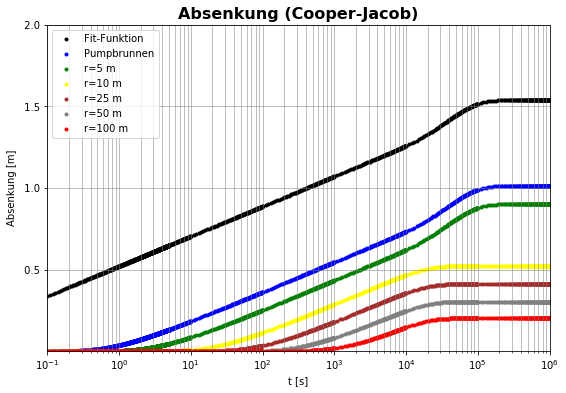

In [94]:
#Plot Function
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(time4, r_w4,marker='.', color='black')
ax.scatter(time4, r_54,marker='.', color='blue')
ax.scatter(time4, r_104,marker='.', color='green')
ax.scatter(time4, r_254,marker='.', color='yellow')
ax.scatter(time4, r_504,marker='.', color='brown')
ax.scatter(time4, r_1004,marker='.', color='grey')
ax.scatter(time4, r_2004,marker='.', color='red')
3
plt.xscale("log")
plt.axis([1E-1,1E6,1E-3,2])
ax.set(xlabel='t [s]', ylabel='Absenkung [m]')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.1f'))
plt.title('Absenkung (Cooper-Jacob)',fontweight='bold', fontsize=16)
ax.grid(which="both", color='grey',linewidth=0.5)
plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
plt.show()

In [91]:
#Berechnen der zentralen Differenz
t_diff4 = []

sw4_diff = []
s54_diff = []
s104_diff = []
s254_diff = []
s504_diff = []
s1004_diff = []
s2004_diff = []

cw4_diff = []
c54_diff = []
c104_diff = []
c254_diff = []
c504_diff = []
c1004_diff = []
c2004_diff = []
    
for x in range(len(time4)-1):
    if x>0:
        i = time4[x+1]-time4[x-1]
        t_diff4.append(i)
for x in range(len(r_w4)-1):
    if x>0:
        i = r_w4[x+1]-r_w4[x-1]
        sw4_diff.append(i)
        j = r_54[x+1]-r_54[x-1]
        s54_diff.append(j)
        k = r_104[x+1]-r_104[x-1]
        s104_diff.append(k)
        l = r_254[x+1]-r_254[x-1]
        s254_diff.append(l)
        m = r_504[x+1]-r_504[x-1]
        s504_diff.append(m)
        n = r_1004[x+1]-r_1004[x-1]
        s1004_diff.append(n)
        o = r_2004[x+1]-r_2004[x-1]
        s2004_diff.append(o)
for x in range(len(t_diff4)):
    i = sw4_diff[x]/t_diff4[x]
    j = s54_diff[x]/t_diff4[x]
    k = s104_diff[x]/t_diff4[x]
    l = s254_diff[x]/t_diff4[x]
    m = s504_diff[x]/t_diff4[x]
    n = s1004_diff[x]/t_diff4[x]
    o = s2004_diff[x]/t_diff4[x]
    cw4_diff.append(i)
    c54_diff.append(j)
    c104_diff.append(k)
    c254_diff.append(l)
    c504_diff.append(m)
    c1004_diff.append(n)
    c2004_diff.append(o)

#new points in time:
t_av4= []
for x in range (len(cw4_diff)):
    i = (time4[x+2]+time4[x])/2
    t_av4.append(i)
#central difference multiplied with new points in time:
bw4_diff = []
b54_diff = []
b104_diff = []
b254_diff = []
b504_diff = []
b1004_diff = []
b2004_diff = []
for x in range(len(t_av4)):
    i = cw4_diff[x]*t_av4[x]
    j = c54_diff[x]*t_av4[x]
    k = c104_diff[x]*t_av4[x]
    l = c254_diff[x]*t_av4[x]
    m = c504_diff[x]*t_av4[x]
    n = c1004_diff[x]*t_av4[x]
    o = c2004_diff[x]*t_av4[x]
    bw4_diff.append(i)
    b54_diff.append(j)
    b104_diff.append(k)
    b254_diff.append(l)
    b504_diff.append(m)
    b1004_diff.append(n)
    b2004_diff.append(o)

print(len(t_av4))
print(len(b54_diff))

999
999


In [92]:
#Plot Function
def splot(T, S, r, Q):
    tmax = 1000000
    r_max = 1000000
    s = [0 for x in range(r_max)]
    t = [1 for x in range(r_max)]
    
    for x in range(1,tmax,1):
        if x>0:
            s[x] = Q/(4*math.pi*T)*math.exp(-(S*r**2)/(4*T*x))
            t[x] = x
    #PLOT
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, s, 'red')
    ax.scatter(t_av4, bw4_diff,marker='.', color='black')
    ax.scatter(t_av4, b54_diff,marker='.', color='blue')
    ax.scatter(t_av4, b104_diff,marker='.', color='green')
    ax.scatter(t_av4, b254_diff,marker='.', color='orange')
    ax.scatter(t_av4, b504_diff,marker='.', color='lime')
    ax.scatter(t_av4, b1004_diff,marker='.', color='grey')
    ax.scatter(t_av4, b2004_diff,marker='.', color='violet')
    3
    plt.yscale("log")
    plt.xscale("log")
    plt.axis([1E0,1E6,1E-3,1E1])
    ax.set(xlabel='t [s]', ylabel='Diagnostischer Plot')
    plt.title('Auswertung mit diagnostischem Plot',fontweight='bold', fontsize=16)
    ax.grid(which="both", color='grey',linewidth=0.5)
    plt.legend(('Fit-Funktion','Pumpbrunnen', 'r=5 m', 'r=10 m', 'r=25 m', 'r=50 m', 'r=100 m', 'r=200 m'),loc=0)
    plt.show()
# Computation
interact(splot,
         r = widgets.FloatSlider(value=200, min=0, max=200, step=5, description='r [m]:', continuous_update=False, disabled=False, readout_format='.1d'),
         Q = widgets.FloatLogSlider(value=1E-3, base=10, min=-4, max=-1, step=0.001, description='Q [m³/s]:', continuous_update=False, readout_format='.0e'),
         T = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=2, step=0.1,readout=True,description='T [m²/s]:', continuous_update=False,readout_format='.1e'),
         S = widgets.FloatLogSlider(value=0.0001,base=10,min=-6, max=0, step=0.1,readout=True,description='S [ - ]:', continuous_update=False,readout_format='.1e'))

interactive(children=(FloatLogSlider(value=0.0001, continuous_update=False, description='T [m²/s]:', max=2.0, …

<function __main__.splot(T, S, r, Q)>